<div style="display: flex; background-color: RGB(255,114,0);" >

# PROJET - Cojoden
</div>

<div style="display: flex; background-color: blue;" >

# 1.La mission
</div>

La Coopérative des Joyeux Denisoviens, la CoJoDen, une agence de voyages engagée vient de vous embaucher pour créer un prototype informatique.

La CoJoDen a pour objectif d'étoffer son offre et monter en gamme en proposant à ses clients des séjours culturels thématiques. Ces séjours seront définis dynamiquement en fonction des souhaits du client.

Par exemple notre nouvelle cliente italienne Mme Gherardini souhaite organiser un petit périple pour découvrir les oeuvres de Gaston Chaissac. Elle ne dispose que d'un weekend et voudrait limiter ses déplacements à deux musées. Si vous regardez dans https://www.pop.culture.gouv.fr/ et vous faites une recherche sur Gaston Chaissac (plusieurs auteurs avec des casses différentes), vous trouverez des oeuvres principalement sur Nantes et Colmar. Vous pourrez proposer un séjour à cette dame en lui indiquant le temps estimé pour aller d'un lieu à l'autre (à vous de trouver un moyen de récupérer le temps de trajet, ce denier point est optionnel dans un premier temps).

A partir d'un extrait la base de donnée Joconde accessible au grand public, vous modéliserez une base de données relationnelle MySQL qui regroupera les informations que vous jugerez nécessaires.

Vous peuplerez la base avec les oeuvres disponibles en nettoyant et en homogénéisant au maximum les infos.
Vous créerez un code python qui servira de démonstrateur sur quelques exemples simples.

### Livrables

- Faites un démonstrateur python de faisabilité avec quelques références (stockage et accès aux
données)
- Au niveau des livrables, voici ce qu'il faudra: Script python du démonstrateur, pdf de modèle de base (PAS DE NOTEBOOK)
Si on a le temps cette semaine vous ferez une présentation de 10 min de votre programme.
Si c'est trop court pour vous, on fera ça lors de notre prochaine semaine de formation

- NoSQL pour la sauvegarde des PDF et images

### Ressources

- https://www.data.gouv.fr/fr/datasets/collections-des-musees-de-france-base-joconde/


Nomenclature des champs :
Ce jeu de données comprend l’intégralité du catalogue collectif des musées de France. Les notices d’objets des musées de France sont de toute nature (archéologie, beaux-arts, ethnologie…).
Le détail de la nomenclature de la liste des champs de la base Joconde est téléchargeable ci-dessous, voir "Pièce jointe".

<div style="display: flex; background-color: blue;" >

# 2.Exploration des données
</div>

<div style="display: flex; background-color: Green; padding: 7px;" >

### 2.1. Chargement des données
</div>

In [947]:
from os import getcwd
from os.path import join
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import csv
from IPython.core.display import HTML
from cojoden_functions import color_graph_background, get_na_columns_classement
try:
    from cojoden_functions import convert_string_to_search_string, convert_df_string_to_search_string
except:
    pass
from collections import Counter

In [42]:
# ---------------------------------------------------------------------------------------------
#                               MAIN
# ---------------------------------------------------------------------------------------------
verbose = 0

# Récupère le répertoire du programme
file_path = getcwd() + "\\"
data_set_path = file_path + "dataset\\"

data_set_file_name = "base-joconde-extrait.csv"

print(f"Current execution path : {file_path}")
print(f"Dataset path : {data_set_path}")

Current execution path : c:\Users\User\WORK\workspace-ia\PROJETS\projet_cojoden\
Dataset path : c:\Users\User\WORK\workspace-ia\PROJETS\projet_cojoden\dataset\


In [620]:
skiprows = 0
nrows = 250000 + skiprows
# Pour éviter de charger le fichier complet pour faire nos tests, mettre en commentaire la ligne ci-dessous
nrows = 0

usecols = ['ref', 'pop_coordonnees', 
       'autr', 'bibl', 'comm', 'deno', 'desc',
       'dims', 'domn', 'dpt', 'ecol', 
       'hist',  'lieux', 'loca', 'loca2', 'mill', 'nomoff', 
       'paut', 'peri', 'pins', 'prep', 
       'region', 'repr',  'tech', 'titr', 'ville_', 'museo']

# Suppression des colonnes avec plus de 75% de NAN 
# 'adpt','nsda','geohi', 'manquant', 'manquant_com', 'milu','onom','refmem', 'refmer','refpal', 'retif',
# 'peoc','peru','plieux','refmis','srep','attr','puti', 'ddpt','pdec','appl','drep','depo','epoq','decv',
# 'expo', 'etat', 'gene', 'larc', 

# Suppression des colonnes non nécessaire :
# 'www','base','contient_image', 'dacq','dmaj','copy','pop_contient_geolocalisation','aptn', 
# 'dmis', 'msgcom','museo', 'producteur', 'image','inv', 'phot', 'stat', 'label', 'historique','util','insc',

In [621]:
df_origin = None
if nrows > 0:
    print("(", skiprows, "to", nrows,"rows)")
    df_origin = pd.read_csv(join(data_set_path,data_set_file_name), skiprows=skiprows, quoting=csv.QUOTE_NONNUMERIC, sep=';', low_memory=False, usecols=usecols)
else:
    df_origin = pd.read_csv(join(data_set_path,data_set_file_name), quoting=csv.QUOTE_NONNUMERIC, sep=';', low_memory=False, usecols=usecols)

print(f"{df_origin.shape} données chargées ------> {list(df_origin.columns)}")

display(HTML(df_origin.head().to_html()))

(650853, 27) données chargées ------> ['ref', 'pop_coordonnees', 'autr', 'bibl', 'comm', 'deno', 'desc', 'dims', 'domn', 'dpt', 'ecol', 'hist', 'lieux', 'loca', 'loca2', 'mill', 'museo', 'nomoff', 'paut', 'peri', 'pins', 'prep', 'region', 'repr', 'tech', 'titr', 'ville_']


,ref,pop_coordonnees,autr,bibl,comm,deno,desc,dims,domn,dpt,ecol,hist,lieux,loca,loca2,mill,museo,nomoff,paut,peri,pins,prep,region,repr,tech,titr,ville_
0,M0435002007,"49.112285,2.21638",LE GULUCHE Joseph Marie,33 ; 196 ; 44,NaN,statuette,"Terre cuite d'édition ; terre cuite, naturel","l. 30 cm ; H. 65 cm ; P. 22 cm ; VOLUM. 0,0429",sculpture,Val-d'Oise,France,"voir aussi : 2010.0.4, 2010.0.87 En Détresse",France;Ile-de-France;Val d'Oise;L'Isle-Adam (lieu de création),L'Isle-Adam;musée Louis Senlecq,NaN,1890 entre;1908 et,M0435,musée d'Art et d'Histoire Louis Senlecq,"Plourivo, 1849; Villejuif, 1915",4e quart 19e siècle;1er quart 20e siècle,Signé sur la terrasse au revers de la pièce : J. Le Guluche ; Cachet : Alphonse Hanne n°92 ; Inscription à l'avant de la pièce : En Détresse,groupe de deux pêcheurs et un enfant en détresse à la proue d'une embarcation en difficulté,Ile-de-France,"scène (naufrage, tempête, vague, bateau, marin pêcheur, homme, enfant, peur)",terre cuite,En Détresse,L'Isle-Adam
1,M0435001924,"49.112285,2.21638",THOMSEN Constant,NaN,NaN,buste,"terre cuite, naturel","l. 30 CM ; H. 62 CM ; P. 23 CM ; VOLUM. 0,0428",sculpture,Val-d'Oise,Danemark,voir aussi : n° 2010.0.25 Buste de Renet Tener,NaN,L'Isle-Adam;musée Louis Senlecq,NaN,NaN,M0435,musée d'Art et d'Histoire Louis Senlecq,"né en 1860 ; mort en 1921, actif vers 1893",4e quart 19e siècle;1er quart 20e siècle,"Signé au revers de la pièce sur l'épaule droite : C. Thomsen ; Cachet au revers de la pièce : Union Artistique de la Sculpture Française, et en dessous cachet rectangulaire : 8016 LE MFI PARIS ; Inscription à l'avant de la pièce : BAZEILLES","le titre : Bazeilles, fait peut-être un rappel de l'épisode de la guerre de 1870 : la bataille à Bazeilles",Ile-de-France,"portrait (homme, en buste, expression du visage, douleur)",terre cuite,Bazeilles,L'Isle-Adam
2,M0435002028,"49.112285,2.21638",FJERDINGSTAD Christian (orfèvre),NaN,NaN,vase,Vase ovoïde sur talon en étain,"H. 16,4 cm",orfèvrerie,Val-d'Oise,Danemark,"voir aussi : 2010.5.1, 2010.5.2, 2010.5.3, 2010.5.4, 2010.5.5",France;Ile-de-France;Val d'Oise;L'Isle-Adam (lieu de création),L'Isle-Adam;musée Louis Senlecq,NaN,1920 entre;1930 et,M0435,musée d'Art et d'Histoire Louis Senlecq,"né en 1891 ; mort en 1968 ; Christian Fjerginstad avait son atelier d'orfèvrerie à L'Isle-Adam de 1921 à 1960, 19 rue Martel, il travailla pour Christofle de 1921 à 1941",1ère moitié 20e siècle,Poinçon : Etain de L'Isle-Adam ; n° 10-89 à l'intérieur du talon de la pièce ; signé à l'intérieur du talon : FJERGINSTAD,NaN,Ile-de-France,NaN,étain,NaN,L'Isle-Adam
3,08120020599,"49.890413,2.295968",DUTHOIT Louis,NaN,NaN,NaN,Encre sur papier calque collé sur papier blanc,Hauteur en cm 10.7 ; Largeur en cm 8,dessin,Somme,France,NaN,NaN,Amiens;musée de Picardie,Picardie ; Somme,1850,M0812,musée de Picardie,"DUTHOIT : Amiens, 1807/04/15 ; Amiens, 1874/12/30 ; nationalité : Française",3e quart 19e siècle,"monogrammé, en bas à gauche : L D ; annoté, sur le montage, en haut. Cette annotation correspond à l'intitulé de la planche : DAOURS ; annoté, sur le montage, en bas : Porte","Ce dessin représente une porte d'édifice à Daours (Somme), avec tympan et archivolte sculptée.",Hauts-de-France,"vue d'architecture (Daours, porte, archivolte)","encre, papier calque, papier (blanc)","Porte d'un édifice, à Daours ; Daours : Porte (autre titre)",Amiens
4,08120020608,"49.890413,2.295968",DUTHOIT Aimé;DUTHOIT Louis,NaN,NaN,NaN,Encre sur papier calque collé sur papier blanc,Hauteur en cm 9.4 ; Largeur en cm 12.8,dessin,Somme,France,NaN,NaN,Amiens;musée de Picardie,Picardie ; Somme,1850,M0812,musée de Picardie,"DUTHOIT Aimé : Amiens, 1803/11/24 ; Amiens, 1869/02/20 ; nationalité : Française#DUTHOIT Louis : Amiens, 1807/04/15 ; Amiens, 1874/12/30 ; nationalité : Française ; Les deux attributions sont plausibles",3e quart 19e siècle,"annoté, en bas à gauche : Demuin ; annoté, sur le montage, en haut. Cette annotation correspond à l'intitulé de la planch

In [45]:
to_rename = {
    'autr':'auteur',
    'comm':'commentaires', 
    'deno':'type_oeuvre', 
    'desc':'description',
    'dims':'dimensions', 
    'domn':'domaine', 
    'dpt':'geo_departement', 
    'ecol':'geo_ecole_pays', 
    'lieux':'creation_lieux', 
    'loca':'lieux_conservation', 
    'loca2':'geo_pays_region_ville', 
    'mill':'creation_millesime', 
    'nomoff':'nom_officiel_musee', 
    'paut':'auteur_precisions', 
    'peri':'creation_periode', 
    'pins':'inscription_precisions',
    'prep':'sujet_precisions', 
    'repr':'sujet',  
    'tech':'materiaux_technique',
    'titr':'titre',
    'ville_':'geo_ville',
    'region' : 'geo_region',
    # 'bibl':'bibliographie',
    # 'insc':'inscription',
    # 'inv':'no_inventaire', 
    # 'label':'label_musee_fr',  
    # 'phot':'credit_photo', 
    # 'producteur':'data_producteur', 
    # 'stat':'statut_juridique', 
    # 'util':'utilisation', 
}

In [622]:
df_origin = df_origin.rename(columns=to_rename)

In [623]:
df_origin.columns

Index(['ref', 'pop_coordonnees', 'auteur', 'bibl', 'commentaires',
       'type_oeuvre', 'description', 'dimensions', 'domaine',
       'geo_departement', 'geo_ecole_pays', 'hist', 'creation_lieux',
       'lieux_conservation', 'geo_pays_region_ville', 'creation_millesime',
       'museo', 'nom_officiel_musee', 'auteur_precisions', 'creation_periode',
       'inscription_precisions', 'sujet_precisions', 'geo_region', 'sujet',
       'materiaux_technique', 'titre', 'geo_ville'],
      dtype='object')

In [624]:
# Réorganisation des colonnes.
df_origin = df_origin[['ref', 'titre', 'auteur', 'sujet_precisions', 'sujet', 'type_oeuvre', 'materiaux_technique', 'description', 'commentaires',
       'dimensions', 'domaine',
       'geo_ville', 'geo_departement', 'geo_region','geo_pays_region_ville',  'geo_ecole_pays', 'pop_coordonnees',
       'hist', 'museo','nom_officiel_musee','creation_periode', 'creation_millesime', 'creation_lieux', 'lieux_conservation',
       'auteur_precisions', 'inscription_precisions',
       ]]
       
display(HTML(df_origin.head().to_html()))

,ref,titre,auteur,sujet_precisions,sujet,type_oeuvre,materiaux_technique,description,commentaires,dimensions,domaine,geo_ville,geo_departement,geo_region,geo_pays_region_ville,geo_ecole_pays,pop_coordonnees,hist,museo,nom_officiel_musee,creation_periode,creation_millesime,creation_lieux,lieux_conservation,auteur_precisions,inscription_precisions
0,M0435002007,En Détresse,LE GULUCHE Joseph Marie,groupe de deux pêcheurs et un enfant en détresse à la proue d'une embarcation en difficulté,"scène (naufrage, tempête, vague, bateau, marin pêcheur, homme, enfant, peur)",statuette,terre cuite,"Terre cuite d'édition ; terre cuite, naturel",NaN,"l. 30 cm ; H. 65 cm ; P. 22 cm ; VOLUM. 0,0429",sculpture,L'Isle-Adam,Val-d'Oise,Ile-de-France,NaN,France,"49.112285,2.21638","voir aussi : 2010.0.4, 2010.0.87 En Détresse",M0435,musée d'Art et d'Histoire Louis Senlecq,4e quart 19e siècle;1er quart 20e siècle,1890 entre;1908 et,France;Ile-de-France;Val d'Oise;L'Isle-Adam (lieu de création),L'Isle-Adam;musée Louis Senlecq,"Plourivo, 1849; Villejuif, 1915",Signé sur la terrasse au revers de la pièce : J. Le Guluche ; Cachet : Alphonse Hanne n°92 ; Inscription à l'avant de la pièce : En Détresse
1,M0435001924,Bazeilles,THOMSEN Constant,"le titre : Bazeilles, fait peut-être un rappel de l'épisode de la guerre de 1870 : la bataille à Bazeilles","portrait (homme, en buste, expression du visage, douleur)",buste,terre cuite,"terre cuite, naturel",NaN,"l. 30 CM ; H. 62 CM ; P. 23 CM ; VOLUM. 0,0428",sculpture,L'Isle-Adam,Val-d'Oise,Ile-de-France,NaN,Danemark,"49.112285,2.21638",voir aussi : n° 2010.0.25 Buste de Renet Tener,M0435,musée d'Art et d'Histoire Louis Senlecq,4e quart 19e siècle;1er quart 20e siècle,NaN,NaN,L'Isle-Adam;musée Louis Senlecq,"né en 1860 ; mort en 1921, actif vers 1893","Signé au revers de la pièce sur l'épaule droite : C. Thomsen ; Cachet au revers de la pièce : Union Artistique de la Sculpture Française, et en dessous cachet rectangulaire : 8016 LE MFI PARIS ; Inscription à l'avant de la pièce : BAZEILLES"
2,M0435002028,NaN,FJERDINGSTAD Christian (orfèvre),NaN,NaN,vase,étain,Vase ovoïde sur talon en étain,NaN,"H. 16,4 cm",orfèvrerie,L'Isle-Adam,Val-d'Oise,Ile-de-France,NaN,Danemark,"49.112285,2.21638","voir aussi : 2010.5.1, 2010.5.2, 2010.5.3, 2010.5.4, 2010.5.5",M0435,musée d'Art et d'Histoire Louis Senlecq,1ère moitié 20e siècle,1920 entre;1930 et,France;Ile-de-France;Val d'Oise;L'Isle-Adam (lieu de création),L'Isle-Adam;musée Louis Senlecq,"né en 1891 ; mort en 1968 ; Christian Fjerginstad avait son atelier d'orfèvrerie à L'Isle-Adam de 1921 à 1960, 19 rue Martel, il travailla pour Christofle de 1921 à 1941",Poinçon : Etain de L'Isle-Adam ; n° 10-89 à l'intérieur du talon de la pièce ; signé à l'intérieur du talon : FJERGINSTAD
3,08120020599,"Porte d'un édifice, à Daours ; Daours : Porte (autre titre)",DUTHOIT Louis,"Ce dessin représente une porte d'édifice à Daours (Somme), avec tympan et archivolte sculptée.","vue d'architecture (Daours, porte, archivolte)",NaN,"encre, papier calque, papier (blanc)",Encre sur papier calque collé sur papier blanc,NaN,Hauteur en cm 10.7 ; Largeur en cm 8,dessin,Amiens,Somme,Hauts-de-France,Picardie ; Somme,France,"49.890413,2.295968",NaN,M0812,musée de Picardie,3e quart 19e siècle,1850,NaN,Amiens;musée de Picardie,"DUTHOIT : Amiens, 1807/04/15 ; Amiens, 1874/12/30 ; nationalité : Française","monogrammé, en bas à gauche : L D ; annoté, sur le montage, en haut. Cette annotation correspond à l'intitulé de la planche : DAOURS ; annoté, sur le montage, en bas : Porte"
4,08120020608,L'église de Démuin ; Demuin : L'église (autre titre),DUTHOIT Aimé;DUTHOIT Louis,"Ce dessin représente l'église de Démuin (Somme), côté sud-est.","paysage;vue d'architecture (Démuin, village, place, église, personnage)",NaN,"encre, papier calque, papier (blanc)",Encre sur papier calque collé sur papier blanc,NaN,Hauteur en cm 9.4 ; Largeur en cm 12.8,dessin,Amiens,Somme,Hauts-de-France,Picardie ; Somme,France,"49.890413,2

<div style="display: flex; background-color: Green; padding: 7px;" >

### 2.2. Analyse des NaN
</div>

Le shape initial est de `(650853, 65)`


Suite à un premier chargement et une première analyse, nous obtenons le pourcentage de NA présent par colonne tel que :

```
0 => 16 ['ref', 'pop_contient_geolocalisation', 'pop_coordonnees', 'base', 'contient_image', 'copy', 'domn', 'dpt', 'inv', 'loca', 'museo', 'nomoff', 'producteur', 'region', 'stat', 'ville_']
3 => 1 ['image']
8 => 1 ['label']
9 => 1 ['tech']
10 => 1 ['dims']
11 => 1 ['dmis']
13 => 1 ['loca2']
16 => 1 ['peri']
17 => 1 ['autr']
19 => 1 ['dacq']
21 => 1 ['titr']
31 => 2 ['aptn', 'phot']
34 => 1 ['deno']
36 => 1 ['paut']
37 => 1 ['ecol']
45 => 2 ['dmaj', 'repr']
49 => 1 ['msgcom']
50 => 1 ['desc']
57 => 1 ['mill']
61 => 2 ['historique', 'pins']
67 => 1 ['insc']
72 => 1 ['bibl']
73 => 3 ['lieux', 'prep', 'www']
75 => 2 ['comm', 'hist']
77 => 1 ['larc']
79 => 1 ['gene']
81 => 2 ['etat', 'util']
88 => 2 ['decv', 'expo']
90 => 1 ['epoq']
93 => 1 ['depo']
94 => 2 ['appl', 'drep']
95 => 2 ['ddpt', 'pdec']
96 => 2 ['attr', 'puti']
97 => 3 ['plieux', 'refmis', 'srep']
98 => 2 ['peoc', 'peru']
99 => 10 ['adpt', 'geohi', 'manquant', 'manquant_com', 'milu', 'onom', 'refmem', 'refmer', 'refpal', 'retif']
100 => 1 ['nsda']
```

![Heat map des NA](img/na_dataset.png)

Je décide donc de supprimer toutes les colonnes qui ont un pourcentage de NA > 75 %, pour cela, je vais les exclure dès le chargement des données.

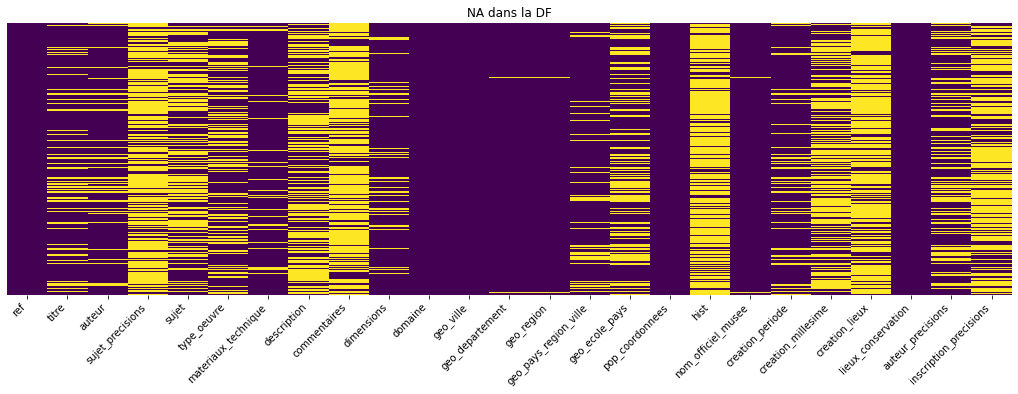

In [49]:
figure, ax = color_graph_background(1,1)
sns.heatmap(df_origin.isnull(), yticklabels=False,cbar=False, cmap='viridis')
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.title("NA dans la DF")
figure.set_size_inches(18, 5, forward=True)
plt.show()

In [50]:
# df_global_full_clean = remove_na_columns(df_global_full, max_na=85, verbose=verbose, inplace=False)
na_columns_class = get_na_columns_classement(df_origin.copy(), verbose=1)

0 => 8 ['ref', 'domaine', 'geo_ville', 'geo_departement', 'geo_region', 'pop_coordonnees', 'nom_officiel_musee', 'lieux_conservation']
9 => 1 ['materiaux_technique']
10 => 1 ['dimensions']
13 => 1 ['geo_pays_region_ville']
16 => 1 ['creation_periode']
17 => 1 ['auteur']
21 => 1 ['titre']
34 => 1 ['type_oeuvre']
36 => 1 ['auteur_precisions']
37 => 1 ['geo_ecole_pays']
45 => 1 ['sujet']
50 => 1 ['description']
57 => 1 ['creation_millesime']
61 => 1 ['inscription_precisions']
73 => 2 ['sujet_precisions', 'creation_lieux']
75 => 2 ['commentaires', 'hist']


<div style="display: flex; background-color: Green; padding: 7px;" >

### 2.3. Analyse des données
</div>

In [625]:
df_origin.describe()

,ref,titre,auteur,sujet_precisions,sujet,type_oeuvre,materiaux_technique,description,commentaires,dimensions,...,pop_coordonnees,hist,museo,nom_officiel_musee,creation_periode,creation_millesime,creation_lieux,lieux_conservation,auteur_precisions,inscription_precisions
count,650853,512385,538804,171724,351558,426375,587634,320511,159876,581866,...,650853,161007,650775,644769,544555,275279,171185,650803,414860,249738
unique,639325,346340,70076,123191,241899,21998,68499,202281,89749,361826,...,535,93962,488,428,1598,17425,14402,1048,51828,203663
top,08880000225,(Sans titre),anonyme,iconographie religieuse,paysage,tableau,mine de plomb,Mine de plomb sur papier,Datation : blog d'Antoine Sausverd : Topfferiana,H. 9 ; l. 14,...,"48.859903,2.340929",autres exemplaires conservés au musée Rodin,M5031,musée du Louvre,19e siècle,1880 entre;1917 et,France;Ile-de-France;Hauts-de-Seine;Sèvres (li...,Paris;musée du Louvre département des Arts gra...,"Paris, 1840 ; Meudon, 1917",L.1915 A
freq,2,4656,58279,1190,7147,63839,33202,1968,1155,2504,...,140845,2294,142102,142102,46937,2786,17098,133448,12720,1741


In [52]:
df_origin.describe(include="all")

,ref,titre,auteur,sujet_precisions,sujet,type_oeuvre,materiaux_technique,description,commentaires,dimensions,...,geo_ecole_pays,pop_coordonnees,hist,nom_officiel_musee,creation_periode,creation_millesime,creation_lieux,lieux_conservation,auteur_precisions,inscription_precisions
count,650853,512385,538804,171724,351558,426375,587634,320511,159876,581866,...,406998,650853,161007,644769,544555,275279,171185,650803,414860,249738
unique,639325,346340,70076,123191,241899,21998,68499,202281,89749,361826,...,2122,535,93962,428,1598,17425,14402,1048,51828,203663
top,08880000225,(Sans titre),anonyme,iconographie religieuse,paysage,tableau,mine de plomb,Mine de plomb sur papier,Datation : blog d'Antoine Sausverd : Topfferiana,H. 9 ; l. 14,...,France,"48.859903,2.340929",autres exemplaires conservés au musée Rodin,musée du Louvre,19e siècle,1880 entre;1917 et,France;Ile-de-France;Hauts-de-Seine;Sèvres (li...,Paris;musée du Louvre département des Arts gra...,"Paris, 1840 ; Meudon, 1917",L.1915 A
freq,2,4656,58279,1190,7147,63839,33202,1968,1155,2504,...,200508,140845,2294,142102,46937,2786,17098,133448,12720,1741


<div style="display: flex; background-color: indigo;" >

#### 2.3. Value counts
</div>

In [53]:
df_origin.columns

Index(['ref', 'titre', 'auteur', 'sujet_precisions', 'sujet', 'type_oeuvre',
       'materiaux_technique', 'description', 'commentaires', 'dimensions',
       'domaine', 'geo_ville', 'geo_departement', 'geo_region',
       'geo_pays_region_ville', 'geo_ecole_pays', 'pop_coordonnees', 'hist',
       'nom_officiel_musee', 'creation_periode', 'creation_millesime',
       'creation_lieux', 'lieux_conservation', 'auteur_precisions',
       'inscription_precisions'],
      dtype='object')

In [54]:
print(df_origin['lieux_conservation'].value_counts())

Paris;musée du Louvre département des Arts graphiques                  133448
Saint-Germain-en-Laye;musée d'Archéologie nationale                     35896
Marseille;musée des Civilisations de l'Europe et de la Méditerranée     21268
Sèvres;Sèvres - Cité de la céramique                                    17348
Chantilly;musée Condé                                                   13679
                                                                        ...  
Nîmes;musée des beaux -arts                                                 1
Vizille;Musée de la Révolution française                                    1
Nîmes;Muséum d'Histoire Naturelle                                           1
ParisÂ;musée de la musique;manquant                                         1
dépôt;Laon;musée archéologique municipal                                    1
Name: lieux_conservation, Length: 1048, dtype: int64


<div style="display: flex; background-color: indigo;" >

#### 2.5. Traitement de l'encodage
</div>

Suite à la première analyse, il y a un soucis d'encodage dans toute la DF, j'ai décidé de traiter l'encodage en ligne de commandes directement dans le fichier source, par exemple :
- `sed -i "s/Ã¹/ù/g" base-joconde-extrait_encoding.csv`
- `grep -E 'Ã' base-joconde-extrait_encoding.csv`
- `sed -i "s/àle-de-France/Ile-de-France/g" base-joconde-extrait_encoding.csv`

Cependant le à ne semble pas pouvoir être traité avec cette méthode, je le remplace donc dans la DF.

In [626]:
for col in df_origin.columns:
    no_na = df_origin[col].notna()
    df_origin.loc[no_na, col] = df_origin.loc[no_na, col].str.replace('Ã  ', 'à ')

<div style="display: flex; background-color: indigo;" >

#### 2.4. Doublons
</div>

Il semble y avoir des doublons sur la référence, il est préférable de vérifier : 
- aucun doublon sur la totalité de la ligne
- vérification des doublons sur la référence : `11528 rows` en doublon sur la référence

In [56]:
df_origin[df_origin.duplicated()]

,ref,titre,auteur,sujet_precisions,sujet,type_oeuvre,materiaux_technique,description,commentaires,dimensions,...,geo_ecole_pays,pop_coordonnees,hist,nom_officiel_musee,creation_periode,creation_millesime,creation_lieux,lieux_conservation,auteur_precisions,inscription_precisions
184868,08880000514,Portrait de William Wegman,ISLER Véra,NaN,NaN,tirage photographique,NaN,Photographie noir et blanc sur Papier Marouflé,NaN,"H. 165, L. 118",...,Suisse,"0.0,0.0",NaN,musée d'Art Moderne et d'Art Contemporain,4e quart 20e siècle,1991,NaN,Nice;musée d'art moderne et d'art contemporain,"Berlin, 1931 ; femme",NaN
185128,08880000100,Tango,GAINON Jacqueline,NaN,NaN,tableau,NaN,Acrylique sur toile,NaN,"H. 170, L. 140",...,France,"0.0,0.0",NaN,musée d'Art Moderne et d'Art Contemporain,4e quart 20e siècle,1984,NaN,Nice;musée d'art moderne et d'art contemporain,"Nice, 1951 ; femme",S.B.G.: J.Gainon
185140,08880001129,Sans titre,CHUBAC Albert,NaN,NaN,NaN,NaN,Collage,NaN,"H. 64, L. 49",...,Suisse,"0.0,0.0",NaN,musée d'Art Moderne et d'Art Contemporain,4e quart 20e siècle,1980,NaN,Nice;musée d'art moderne et d'art contemporain,"Genève, 1925",NaN
185388,04640008298,Villeneuve-lès-Avignon : mazet et olivier,anonyme (photographe);KODAK (éditeur),NaN,"paysage (Villeneuve-lès-Avignon, maison, olivier)",tirage photographique,"papier, noir et blanc",NaN,NaN,Hauteur en mm 95 ; Longueur en mm 136,...,NaN,"0.0,0.0",NaN,musée Pierre-de-Luxembourg,20e siècle,NaN,NaN,Villeneuve-lès-Avignon;musée Pierre-de-Luxembourg,NaN,"nom de l'éditeur, Verso : TRAITE PAR / KODAK /..."
185496,02470000389,La Colonne,GEORGIN François (graveur);PELLERIN (fabrique),NaN,NaN,NaN,"papier vergé (xylographie, couleur)",Chromoxylographie sur papier vergé,NaN,Hauteur en cm 63 ; Largeur en cm 48,...,NaN,"0.0,0.0",Graveur,musée Bertrand,19e siècle,NaN,"France, Grand Est, Vosges, Epinal (lieu de cré...",Châteauroux;musée Bertrand,"GEORGIN François : ?, 1801 ; ?, 1863#PELLERIN ...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649204,04640006777,Avignon : vue générale depuis Villeneuve,anonyme (photographe);RELLA (éditeur),NaN,vue d'architecture;paysage (Villeneuve-lès-Avi...,carte postale,"papier cartonné, imprimé, noir et blanc",NaN,NaN,Hauteur en mm 90 ; Longueur en mm 141,...,France,"0.0,0.0",NaN,musée Pierre-de-Luxembourg,20e siècle,NaN,NaN,Villeneuve-lès-Avignon;musée Pierre-de-Luxembourg,"Editions RELLA, Nice (A.-M.)","nom de l'éditeur, Bas et droite : Rella ; titr..."
649205,04640008157,Villeneuve-lès-Avignon : Le Couronnement de la...,MAROTTE (graveur);BULLOZ Jacques Ernest (éditeur),NaN,"paysage (Villeneuve-lès-Avignon, Vierge, Chris...",carte postale,"papier cartonné, héliogravure",NaN,NaN,Hauteur en mm 90 ; Longueur en mm 140,...,France,"0.0,0.0",NaN,musée Pierre-de-Luxembourg,20e siècle,NaN,France;Ile-de-France;Paris (lieu de création),Villeneuve-lès-Avignon;musée Pierre-de-Luxembourg,"BULLOZ : Paris, 1858 ; Paris, 1942 ; J.-E. Bul...","titre, Recto : N°20714. - ENGUERRAND CHARONTON..."
649210,05630030212,Main gauche,NaN,NaN,"(main, anneau)",statue;fragment,marbre,"Roschach 1865 p. 94 : ""Fragments de sculptures...",NaN,Hauteur en cm 8 ; Longueur en cm 21 ; Largeur ...,...,NaN,"43.608897,1.441776",NaN,musée Saint-Raymond,1er siècle av JC,NaN,NaN,Toulouse;musée Saint-Raymond,NaN,NaN
649224,50170013706,Gouvernement de Lectoure ; Carte géographique ...,"TASSIN Christophe (géographe, cartographe);TAV...",NaN,"(Lectoure, Rivière(s))",NaN,eau-forte,NaN,NaN,Largeur en cm 15.2,...,NaN,"43.294699,-0.374378",NaN,musée national du château de Pau,2e quart 17e siècle,1638,NaN,Pau;musée national du château de Pau,TASSIN : 17 ème siècle Commissaire des guerres...,NaN


In [627]:
# Suppression des 2246 rows strictement identiques
df_clean = df_origin.drop_duplicates()
print(df_origin.shape)
print(df_clean.shape)

(650853, 26)
(648607, 26)


In [628]:
df_clean[df_clean.duplicated(subset=['ref'])].shape

(9282, 26)

In [59]:
display(HTML(df_clean[df_clean['ref']=="M0537066268"].to_html()))

,ref,titre,auteur,sujet_precisions,sujet,type_oeuvre,materiaux_technique,description,commentaires,dimensions,domaine,geo_ville,geo_departement,geo_region,geo_pays_region_ville,geo_ecole_pays,pop_coordonnees,hist,nom_officiel_musee,creation_periode,creation_millesime,creation_lieux,lieux_conservation,auteur_precisions,inscription_precisions
31666,M0537066268,COUCHES ET CHASSIS (titre inscrit),FÉRAT Jules (dessinateur);HACHETTE & Cie (éditeur);FRAILLERY E. (imprimeur);Librairies - imprimeries réunies (imprimeur),NaN,"scène (jardin potager, homme, groupe : jardinier, penché, serre, cloche de verre, soin des plantes, arrosoir, dépendance agricole, silo, ville)",carte réclame,carton (chromolithographie),NaN,NaN,H. 8.4 cm ; l. 12.4 cm,estampe,Epinal,Vosges,Grand Est,NaN,NaN,"48.183628,6.445992",NaN,musée de l'Image,4e quart 19e siècle;1er quart 20e siècle,1890 entre;1914 et,France (lieu d’exécution) (lieu de création),Epinal;musée de l’Image,"FÉRAT Jules-Descartes (dessinateur) : Ham, 1829 ; Paris, 1906 ; HACHETTE & Cie (Actif à partir de 1846) ; FRAILLERY E. (Actif de 1878 à 1914) ; Librairies - imprimeries réunies (Actif à partir de 1890)","E. Fraillery Imp. (b.d.) ; LIBRAIRIE HACHETTE & Cie, BOULEVARD SAINT-GERMAIN, 79. (b.g., revers) ; PARIS, IMP. RÉUNIES, A. RUE MIGNON, 2 (b.d., revers) ; J. Ferat pinxt. (b.g.) ; [INDUSTRIES AGRICOLES] / COUCHES ET CHASSIS [...] plantes sont chaudement abritées. (c., revers) ; HACHETTE ET Cie (h.c.)"
184888,M0537066268,COUCHES ET CHASSIS (titre inscrit),FÉRAT Jules (dessinateur);HACHETTE & Cie (éditeur);FRAILLERY E. (imprimeur);Librairies - imprimeries réunies (imprimeur),NaN,"scène (jardin potager, homme, groupe : jardinier, penché, serre, cloche de verre, soin des plantes, arrosoir, dépendance agricole, silo, ville)",carte réclame,carton (chromolithographie),NaN,NaN,H. 8.4 cm ; l. 12.4 cm,estampe,Epinal,Vosges,Grand Est,NaN,NaN,"48.183628,6.445992",NaN,musée de l'Image,4e quart 19e siècle;1er quart 20e siècle,1890 entre;1914 et,France (lieu d'exécution) (lieu de création),Epinal;musée de l'Image,"FÉRAT Jules-Descartes (dessinateur) : Ham, 1829 ; Paris, 1906 ; HACHETTE & Cie (Actif Ã partir de 1846) ; FRAILLERY E. (Actif de 1878 Ã 1914) ; Librairies - imprimeries réunies (Actif Ã partir de 1890)","E. Fraillery Imp. (b.d.) ; LIBRAIRIE HACHETTE & Cie, BOULEVARD SAINT-GERMAIN, 79. (b.g., revers) ; PARIS, IMP. RÉUNIES, A. RUE MIGNON, 2 (b.d., revers) ; J. Ferat pinxt. (b.g.) ; [INDUSTRIES AGRICOLES] / COUCHES ET CHASSIS [...] plantes sont chaudement abritées. (c., revers) ; HACHETTE ET Cie (h.c.)"


In [629]:
df_clean = df_clean.drop_duplicates(subset=['ref'])
print(df_origin.shape)
print(df_clean.shape)
print(df_clean[df_clean.duplicated(subset=['ref'])].shape)

(650853, 26)
(639325, 26)
(0, 26)


In [61]:
df_clean.describe(include="all")

,ref,titre,auteur,sujet_precisions,sujet,type_oeuvre,materiaux_technique,description,commentaires,dimensions,...,geo_ecole_pays,pop_coordonnees,hist,nom_officiel_musee,creation_periode,creation_millesime,creation_lieux,lieux_conservation,auteur_precisions,inscription_precisions
count,639325,502878,528888,169752,343847,418429,576980,313611,157713,570480,...,402563,639325,158084,633241,534535,269204,165860,639286,407414,242304
unique,639325,345421,69938,122584,240637,21893,68347,199693,89513,361243,...,2116,535,93315,428,1598,17419,14386,1047,51597,200267
top,M0435002007,(Sans titre),anonyme,iconographie religieuse,paysage,tableau,mine de plomb,Mine de plomb sur papier,acquis pour 18 % par Etat-Région (FRAM Picardi...,H. 9 ; l. 14,...,France,"48.859903,2.340929",autres exemplaires conservés au musée Rodin,musée du Louvre,19e siècle,1880 entre;1917 et,France;Ile-de-France;Hauts-de-Seine;Sèvres (li...,Paris;musée du Louvre département des Arts gra...,"Paris, 1840 ; Meudon, 1917",L.1915 A
freq,1,4653,57802,1190,7135,62853,33201,1968,1137,2504,...,197097,140845,2294,142102,46461,2786,17098,133448,12718,1741


<div style="display: flex; background-color: indigo;" >

#### 2.4. Traitement des NA
</div>

<div style="display: flex; background-color: deeppink;" >

##### Remplacement des Sans Titre
</div>

In [62]:
display(HTML(df_clean[df_clean['titre']=='(Sans titre)'].head().to_html()))

,ref,titre,auteur,sujet_precisions,sujet,type_oeuvre,materiaux_technique,description,commentaires,dimensions,domaine,geo_ville,geo_departement,geo_region,geo_pays_region_ville,geo_ecole_pays,pop_coordonnees,hist,nom_officiel_musee,creation_periode,creation_millesime,creation_lieux,lieux_conservation,auteur_precisions,inscription_precisions
2230,05060000286,(Sans titre),HAUSMANN Raoul,NaN,NaN,photogramme,NaN,NaN,NaN,"H. 27.7, L. 35.2",photographie,Rochechouart,Haute-Vienne,Nouvelle-Aquitaine,Limousin ; Haute-Vienne,Autriche,"45.821684,0.819875",NaN,musée départemental d'Art Contemporain,2e quart 20e siècle,1947,NaN,Rochechouart;musée départemental d'art contemporain,"Vienne, 1886 ; Limoges, 1971",R.D. 1947
3787,05060000137,(Sans titre),HAUSMANN Raoul,NaN,NaN,NaN,NaN,Photopictogramme,NaN,"H. 39, L. 30",photographie,Rochechouart,Haute-Vienne,Nouvelle-Aquitaine,Limousin ; Haute-Vienne,Autriche,"45.821684,0.819875",NaN,musée départemental d'Art Contemporain,3e quart 20e siècle,1954,NaN,Rochechouart;musée départemental d'art contemporain,"Vienne, 1886 ; Limoges, 1971",R.S.D. R. Hausmann photopictogramme original 1954
3789,05060000121,(Sans titre),HAUSMANN Raoul,NaN,NaN,tableau,peinture à l'huile (toile),NaN,NaN,"H. 92, L. 72",peinture,Rochechouart,Haute-Vienne,Nouvelle-Aquitaine,Limousin ; Haute-Vienne,Autriche,"45.821684,0.819875",NaN,musée départemental d'Art Contemporain,3e quart 20e siècle,1964,NaN,Rochechouart;musée départemental d'art contemporain,"Vienne, 1886 ; Limoges, 1971",MO.D.B.G.R. R.H. 1964#R.N. 2 VII No 107
3795,05060000866,(Sans titre),HAUSMANN Raoul,NaN,NaN,NaN,NaN,Feutre,NaN,"H. 32, L. 24",dessin,Rochechouart,Haute-Vienne,Nouvelle-Aquitaine,Limousin ; Haute-Vienne,Autriche,"45.821684,0.819875",NaN,musée départemental d'Art Contemporain,3e quart 20e siècle,1969,NaN,Rochechouart;musée départemental d'art contemporain,"Vienne, 1886 ; Limoges, 1971",NaN
7072,05060000156,(Sans titre),HAUSMANN Raoul,NaN,NaN,NaN,NaN,NaN,NaN,"H. 24, L. 18.2",photographie,Rochechouart,Haute-Vienne,Nouvelle-Aquitaine,Limousin ; Haute-Vienne,Autriche,"45.821684,0.819875",NaN,musée départemental d'Art Contemporain,2e quart 20e siècle,1931,NaN,Rochechouart;musée départemental d'art contemporain,"Vienne, 1886 ; Limoges, 1971",NaN


In [630]:
print(df_clean[df_clean['titre']=='(Sans titre)'].shape)
print(df_clean['titre'].isna().sum())
df_clean.loc[df_clean['titre']=='(Sans titre)', 'titre'] = np.nan
df_clean['titre'].isna().sum()

(4653, 26)
136447


141100

<div style="display: flex; background-color: deeppink;" >

##### Remplacement des anonyme
</div>

In [631]:
print(df_clean[df_clean['auteur']=='anonyme'].shape)

(57802, 26)


In [632]:
display(HTML(df_clean[df_clean['auteur']=='anonyme'].head().to_html()))

,ref,titre,auteur,sujet_precisions,sujet,type_oeuvre,materiaux_technique,description,commentaires,dimensions,domaine,geo_ville,geo_departement,geo_region,geo_pays_region_ville,geo_ecole_pays,pop_coordonnees,hist,museo,nom_officiel_musee,creation_periode,creation_millesime,creation_lieux,lieux_conservation,auteur_precisions,inscription_precisions
9,01390024277,NaN,anonyme,NaN,NaN,coiffe (type B),"fibre cellulosique, dentelle type Valenciennes, tuyauté, mousseline, jours à fils tirés, toile, broché","Coiffe Bressane type B dite kélire ou quellière à trois rangs en mousseline bordée dentelle tuyautée, montés sur lacette qui se prolongent en mentonnière ; fond en toile façonnée, rayé ton sur ton, constituée de bandes de mousseline alternées avec des bandes de toile brochée d'une frise d'arêtes de poisson flanquée et de jours, à couture médane, rabattu en lacette sur la nuque et la mentonnière ; pièce rapportée, finement plissée à la nuque ; boutonnière et bouton blanc sur la mentonnière",costume traditionnel,Hauteur en cm 31 ; Largeur en cm 20,costume - accessoires du costume;ethnologie,Dijon,Côte-d'Or,Bourgogne-Franche-Comté,Bourgogne ; Côte-d'Or,NaN,"47.317415,5.037131",NaN,M0139,musée de la vie bourguignonne,NaN,NaN,France;Auvergne-Rhône-Alpes;Ain;Pont-de-Vaux (lieu d'utilisation),Dijon;musée de la vie bourguignonne,NaN,NaN
16,07480012176,"Jeune fille à l'écharpe blanche ; Femme en buste, de face",anonyme,NaN,"portrait (femme, en buste, foulard)",élément d'ensemble;album,"mine de plomb, papier",Collé sur feuille et inséré dans un album par Jouin (?) puis démonté,NaN,Hauteur en m 0.126 ; Largeur en m 0.092,dessin,Angers,Maine-et-Loire,Pays-de-la-Loire,Pays de la Loire ; Maine-et-Loire,NaN,"47.469132,-0.554372",NaN,M0748,musée des beaux-arts et galerie David-d'Angers,2e quart 19e siècle,1829,France;Pays de la Loire;Loire-Atlantique;Nantes (lieu de création),Angers;musée des beaux-arts et galerie David-d'Angers,NaN,"inscription en bas au crayon : Amie de Pension / de M. E. Maillocheau ; inscription, Au verso : à la plume : Que du sentiment le plus doux / le portrait est pour toi le gage et l'assurance / Mais mon coeur en serait jaloux / s'il te consolait de l'absence / Nantes juillet 1829"
23,M0333009083,"Chronomètre de marine de Louis ARBEY, directeur de l'Observatoire de Besançon",anonyme,NaN,NaN,chronomètre de marine,métal;bois;verre,"Chronomètre de marine avec coffret en acajou, suspension à la cardan (?), deux poignées en laiton et cartouche vide en laiton sur le couvercle. Cadran argenté à chiffres romains pour les heures, chiffres arabes pour les cinq minutes avec deux aiguilles en métal doré, deux aiguilles en acier bleui et lunette vitrée. Le cadran supérieur indique la réserve de marche tandis que la partie basse affiche le chronomètre. (Donne les tops tous les 1/4 de secondes.)",NaN,"l. 18.2 cm ; H. 19 cm ; P. 18.2 cm ; VOLUM. 0,0063",horlogerie;métrologie - instruments de mesure,Besançon,Doubs,Bourgogne-Franche-Comté,Franche-Comté ; Doubs,NaN,"47.235776,6.025004",NaN,M0333,musée du Temps,4e quart 19e siècle;1er quart 20e siècle,NaN,NaN,Besançon;musée du Temps,NaN,sur le couvercle: INTERRUPTEUR 1/4 SECONDE sur le cadran: BAS HAUT
25,M0333010238,NaN,anonyme,NaN,NaN,pendule à crémaillère,bois;émail;acier,Pendule à crémaillère en bois doré. Support à deux niveaux avec partie basse représentant une figure allégorique du temps. Cadran horaire avec ornementation de candélabres et de guirlandes de fleurs en bronze dorés. Email blanc à chiffres arabes peints en rouge pour l'indication des heures et des quinze minutes et chiffres peints en noir pour le quantième du mois (31jours). Trois aiguilles dont deux en laiton doré et une en acier bleui,NaN,"l. 32 cm ; H. 81 cm ; P. 13.5 cm ; VOLUM. 0,035",horlogerie;métrologie - instruments de mesure,Besançon,Doubs,Bourgogne-Franche-Comté,Franche-Comté ; Doubs,NaN,"47.235776,6.025004",NaN,M0333,musée du Temps,19e siècle,NaN,NaN,Besançon;musée du Temps,NaN,sur le cadran : Non plus Ultra
38

In [633]:
print(df_clean[df_clean['auteur']=='anonyme'].shape)
print(df_clean['auteur'].isna().sum())
df_clean.loc[df_clean['auteur']=='anonyme'] = np.nan
df_clean['auteur'].isna().sum()

(57802, 26)
110437


168239

<div style="display: flex; background-color: deeppink;" >

##### Titre et Auteur
</div>

`151 647` lignes n'ont ni auteur, ni titre, il reste à statuer ce que l'on en fait.

In [634]:
print(df_clean[(df_clean["titre"].isna())&(df_clean["auteur"].isna())].shape)

(151647, 26)


In [635]:
df_clean[(df_clean["titre"].isna())&(df_clean["auteur"].isna())].head()

,ref,titre,auteur,sujet_precisions,sujet,type_oeuvre,materiaux_technique,description,commentaires,dimensions,...,pop_coordonnees,hist,museo,nom_officiel_musee,creation_periode,creation_millesime,creation_lieux,lieux_conservation,auteur_precisions,inscription_precisions
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,M0794014836,NaN,NaN,NaN,NaN,briquet,alliage cuivreux,briquet rectangulaire dont la molette et la mè...,NaN,"En cm : L. 7,4 cm ; l. 3,5 cm ; E. 1,15 cm",...,"49.384539,3.327233",NaN,M0794,musée municipal,1er quart 20e siècle,1914 entre;1918 et,NaN,Soissons;musée de Soissons,NaN,"sur une face, soudée : L / V ; sur la tranche ..."


In [636]:
df_clean[(df_clean["titre"].isna())&(df_clean["auteur"].isna())].tail()

,ref,titre,auteur,sujet_precisions,sujet,type_oeuvre,materiaux_technique,description,commentaires,dimensions,...,pop_coordonnees,hist,museo,nom_officiel_musee,creation_periode,creation_millesime,creation_lieux,lieux_conservation,auteur_precisions,inscription_precisions
650829,50520012371,NaN,NaN,NaN,NaN,pincette,métal,NaN,NaN,NaN,...,"49.19397,2.48522",NaN,M5052,musée Condé,NaN,NaN,NaN,Chantilly;musée Condé,NaN,NaN
650832,50520012332,NaN,NaN,NaN,NaN,fauteuil,"bois, velours",NaN,NaN,Hauteur en cm 89 ; Largeur en cm 57 ; Profonde...,...,"49.19397,2.48522",NaN,M5052,musée Condé,NaN,NaN,NaN,Chantilly;musée Condé,NaN,au dessous : CY HO couronné 90 (sous la peintu...
650833,50520012333,NaN,NaN,NaN,NaN,fauteuil,"bois, velours",NaN,NaN,Hauteur en cm 88.3 ; Largeur en cm 56.5 ; Prof...,...,"49.19397,2.48522",NaN,M5052,musée Condé,NaN,NaN,NaN,Chantilly;musée Condé,NaN,"91 ; Peinte sur le ceinture, illisible ; au de..."
650847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
650852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


A priori il serait possible de générer un titre pertient à partir des descriptions.
Dans un premier temps, suppression des lignes qui n'ont ni description, ni titre, ni auteur

In [637]:
df_clean[(df_clean["titre"].isna())&(df_clean["auteur"].isna())&(df_clean["description"].isna())].shape

(96279, 26)

In [638]:
df_clean[(df_clean["titre"].isna())&(df_clean["auteur"].isna())&(df_clean["description"].isna())&(df_clean["sujet_precisions"].isna())].shape

(95325, 26)

In [639]:
label_na = (df_clean["titre"].isna())&(df_clean["auteur"].isna())&(df_clean["description"].isna())&(df_clean["sujet_precisions"].isna())&(df_clean["sujet"].isna())
df_clean[label_na].shape

(91970, 26)

In [640]:
df_clean_old = df_clean

- `91 970` lignes n'ont ni auteur, ni titre, ni description, ni tout autre complément permettant de d'aboutir sur ces objets. je les supprime donc.
Pour les autres objets, il est possible de générer un titre à partir des autres colonnes.

In [641]:
df_clean = df_clean_old[~label_na]
print(f'{df_clean_old.shape[0]-df_clean.shape[0]} lignes supprimées')

91970 lignes supprimées


<div style="display: flex; background-color: deeppink;" >

##### Titre
</div>

In [642]:
is_na_titre_idx = df_clean['titre'].isna()
df_clean['titre'].isna().sum()

96893

In [643]:
# L'idée est de remplacer les NaN par le début de la description, à savoir jusqu'au premier séparateur identifié.
def nouveau_titre(description, type_oeuvre, sujet, precisions):
    titre = ""
    precision_done = False

    if precisions is not None and isinstance(precisions, str):
        titre = precisions.strip()
        precision_done = len(titre)>0
    

    if not precision_done and description is not None and isinstance(description, str):
        titre = description.split(".")[0]
        titre = titre.split(";")[0]
        titre = titre.split(",")[0]
        
    if not precision_done and type_oeuvre is not None and isinstance(type_oeuvre, str):
        start_type = type_oeuvre.split(" ")[0]
        if start_type.lower() not in titre.lower():
            titre = type_oeuvre + " " + titre

    if len(titre)==0 and sujet is not None and isinstance(sujet, str):
        start_type = sujet.split("(")[-1]
        start_type = start_type.split(")")[0]
        if len(start_type)>0:
            titre = start_type.strip()
    
    titre = titre.strip()

    return titre if len(titre)>0 else np.nan

In [644]:
df_clean.columns

Index(['ref', 'titre', 'auteur', 'sujet_precisions', 'sujet', 'type_oeuvre',
       'materiaux_technique', 'description', 'commentaires', 'dimensions',
       'domaine', 'geo_ville', 'geo_departement', 'geo_region',
       'geo_pays_region_ville', 'geo_ecole_pays', 'pop_coordonnees', 'hist',
       'museo', 'nom_officiel_musee', 'creation_periode', 'creation_millesime',
       'creation_lieux', 'lieux_conservation', 'auteur_precisions',
       'inscription_precisions'],
      dtype='object')

In [645]:
df_clean.loc[is_na_titre_idx,["description", 'type_oeuvre', 'sujet', 'sujet_precisions']].head()

,description,type_oeuvre,sujet,sujet_precisions
2,Vase ovoïde sur talon en étain,vase,NaN,NaN
18,Horloge de table en cuivre avec réveil. Boîtie...,horloge de table,NaN,NaN
19,"Pendule de cheminée style Empire, figurant Dio...",pendule de cheminée,Diomède,"Sur la plate-forme du char, Diomède, vêtu d'un..."
21,Mouvement de montre en laiton avec cadran en é...,mouvement (élément);montre,NaN,"Coq en laiton doré, ajouré et décoré de rinceaux"
22,Mouvement de montre avec cadran en émail blanc...,mouvement (élément);montre,NaN,Coq ajouré avec motifs de feuillages et de fleurs


In [646]:
df_clean.loc[is_na_titre_idx, "titre"] = df_clean.loc[is_na_titre_idx,["description", 'type_oeuvre', 'sujet', 'sujet_precisions']].apply(lambda x: nouveau_titre(description=x['description'], type_oeuvre=x['type_oeuvre'], sujet=x['sujet'], precisions=x['sujet_precisions']), axis=1)
df_clean['titre'].isna().sum()

C:\Users\User\AppData\Local\Temp\ipykernel_22160\1386797844.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[is_na_titre_idx, "titre"] = df_clean.loc[is_na_titre_idx,["description", 'type_oeuvre', 'sujet', 'sujet_precisions']].apply(lambda x: nouveau_titre(description=x['description'], type_oeuvre=x['type_oeuvre'], sujet=x['sujet'], precisions=x['sujet_precisions']), axis=1)


150

In [37]:
# display(HTML(df_clean[is_na_titre_idx].head(10).to_html()))
df_clean[is_na_titre_idx].head(5)

,ref,titre,auteur,sujet,type_oeuvre,materiaux_technique,description,commentaires,dimensions,domaine,...,pop_coordonnees,hist,nom_officiel_musee,creation_periode,creation_millesime,creation_lieux,lieux_conservation,auteur_precisions,inscription_precisions,sujet_precisions
2,M0435002028,Vase ovoïde sur talon en étain,FJERDINGSTAD Christian (orfèvre),NaN,vase,étain,Vase ovoïde sur talon en étain,NaN,"H. 16,4 cm",orfèvrerie,...,"49.112285,2.21638","voir aussi : 2010.5.1, 2010.5.2, 2010.5.3, 201...",musée d'Art et d'Histoire Louis Senlecq,1ère moitié 20e siècle,1920 entre;1930 et,France;Ile-de-France;Val d'Oise;L'Isle-Adam (l...,L'Isle-Adam;musée Louis Senlecq,né en 1891 ; mort en 1968 ; Christian Fjergins...,Poinçon : Etain de L'Isle-Adam ; n° 10-89 à l'...,NaN
18,M0333000821,Horloge de table en cuivre avec réveil,BADEN,NaN,horloge de table,bois;cuivre;métal,Horloge de table en cuivre avec réveil. Boîtie...,NaN,"L. 10 cm ; l. 10 cm ; H. 25 cm ; VOLUM. 0,0025",horlogerie;métrologie - instruments de mesure,...,"47.235776,6.025004",NaN,musée du Temps,4e quart 17e siècle,NaN,Allemagne (lieu de création),Besançon;musée du Temps,NaN,sur le mouvement : GST BADEN,NaN
19,M0333003316,Pendule de cheminée style Empire,AUBRAY Fils,Diomède,pendule de cheminée,bronze (doré);émail,"Pendule de cheminée style Empire, figurant Dio...",élément principal d'une garniture de cheminée ...,"l. 51 cm ; H. 46,5 cm ; P. 13 cm",horlogerie;métrologie - instruments de mesure,...,"47.235776,6.025004",NaN,musée du Temps,1er quart 19e siècle,1805 entre;1815 et,NaN,Besançon;musée du Temps,NaN,sur le cadran : AUBRAY FILS ; A PARIS,"Sur la plate-forme du char, Diomède, vêtu d'un..."
21,M0333004984,Mouvement de montre en laiton avec cadran en é...,HERIAUT Joachim,NaN,mouvement (élément);montre,laiton;émail;acier,Mouvement de montre en laiton avec cadran en é...,NaN,E. 1.4 cm ; D. 3.6 cm,horlogerie;métrologie - instruments de mesure,...,"47.235776,6.025004",NaN,musée du Temps,3e quart 18e siècle,1750 vers,NaN,Besançon;musée du Temps,NaN,Sur le mouvement : A L Joachim Beriau ; n° 460,"Coq en laiton doré, ajouré et décoré de rinceaux"
22,M0333005041,Mouvement de montre avec cadran en émail blanc...,WINDMILLS Joseph,NaN,mouvement (élément);montre,laiton;émail;émail (peint),Mouvement de montre avec cadran en émail blanc...,NaN,E. 2.1 cm ; D. 4.1 cm,horlogerie;métrologie - instruments de mesure,...,"47.235776,6.025004",NaN,musée du Temps,18e siècle,NaN,Londres;Angleterre (lieu de création),Besançon;musée du Temps,NaN,sur le mouvement : Joseph Windmills London,Coq ajouré avec motifs de feuillages et de fleurs


In [97]:
df_clean[is_na_titre_idx].tail()

,ref,titre,auteur,texte,sujet_precisions,sujet,type_oeuvre,materiaux_technique,description,commentaires,...,geo_ecole_pays,pop_coordonnees,hist,nom_officiel_musee,creation_periode,creation_millesime,creation_lieux,lieux_conservation,auteur_precisions,inscription_precisions
650837,50520013685,Fait partie d'un lot de 60 cuillers Ã café,Christofle Charles (1805-1863),Fait partie d'un lot de 60 cuillers Ã café. L...,NaN,NaN,cuiller Ã café,métal argenté,Fait partie d'un lot de 60 cuillers Ã café. L...,NaN,...,France,"49.19397,2.48522",NaN,musée Condé,2e moitié 19e siècle,1862 après,NaN,Chantilly;musée Condé,"Christofle Charles : PAUT : Lyon, 1805 ; ?",NaN
650838,50520013670,Fait partie d'un lot de 60 cuillers Ã café,Christofle Charles (1805-1863),Fait partie d'un lot de 60 cuillers Ã café. L...,NaN,NaN,cuiller Ã café,métal argenté,Fait partie d'un lot de 60 cuillers Ã café. L...,NaN,...,France,"49.19397,2.48522",NaN,musée Condé,2e moitié 19e siècle,1862 après,NaN,Chantilly;musée Condé,"Christofle Charles : PAUT : Lyon, 1805 ; ?",NaN
650839,50520013718,cuiller Fait partie d'un lot de 7 fourchettes,Christofle Charles (1805-1863),Fait partie d'un lot de 7 fourchettes. Modèle ...,NaN,NaN,cuiller,métal argenté,Fait partie d'un lot de 7 fourchettes. Modèle ...,NaN,...,France,"49.19397,2.48522",NaN,musée Condé,2e moitié 19e siècle,1862 après,NaN,Chantilly;musée Condé,"Christofle Charles : PAUT : Lyon, 1805 ; ?",NaN
650848,00660019748,Bol sur talon rond,SAINT-GERMAIN Marguerite (De) (céramiste),"Bol sur talon rond, décor extérieur de croisil...",NaN,(cerf),bol,faïence (lustrée),"Bol sur talon rond, décor extérieur de croisil...",NaN,...,NaN,"44.838956,-0.579686",NaN,musée des arts décoratifs et du design,2e quart 20e siècle,1930 vers,"Europe, France, Nouvelle-Aquitaine, Gironde, B...",Bordeaux;Musée des Arts décoratifs et du Design,"SAINT-GERMAIN Marguerite (De) : Bordeaux, 1864...",Signature au revers : S. Germain.
650850,00660020054,"Verre;Décor de ruines;Décor ""au coeur"" Cristal...",VERRERIE / FRANCE (cristallerie),Cristal incolore transparent soufflé dans un m...,NaN,NaN,"Verre;Décor de ruines;Décor ""au coeur""","cristal (taillé, soufflé-moulé, gravé)",Cristal incolore transparent soufflé dans un m...,NaN,...,NaN,"44.838956,-0.579686",NaN,musée des arts décoratifs et du design,19ème siècle 1er quart,NaN,"Europe, France (lieu de création)",Bordeaux;Musée des Arts décoratifs et du Design,NaN,NaN


<div style="display: flex; background-color: deeppink;" >

##### Type Oeuvre
</div>

In [647]:
is_na_type_oeuvre = df_clean['type_oeuvre'].isna()
df_clean['type_oeuvre'].isna().sum()

202745

In [648]:
def nouveau_type_oeuvre(description, materiaux_technique):
    titre = ""
    if description is not None and isinstance(description, str):
        titre = description.split(".")[0]
        titre = titre.split(";")[0]
        titre = titre.split(",")[0]
        
    if materiaux_technique is not None and isinstance(materiaux_technique, str):
        start_type = materiaux_technique.split(" ")[0]
        if start_type.lower() not in titre.lower():
            titre = materiaux_technique + " " + titre
    
    titre = titre.strip()

    return titre if len(titre)>0 else np.nan

In [649]:
df_clean.loc[is_na_type_oeuvre, "type_oeuvre"] = df_clean.loc[is_na_type_oeuvre,["description", 'materiaux_technique']].apply(lambda x: nouveau_type_oeuvre(description=x['description'], materiaux_technique=x['materiaux_technique']), axis=1)
print(df_clean['type_oeuvre'].isna().sum())

6580


C:\Users\User\AppData\Local\Temp\ipykernel_22160\3610106159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[is_na_type_oeuvre, "type_oeuvre"] = df_clean.loc[is_na_type_oeuvre,["description", 'materiaux_technique']].apply(lambda x: nouveau_type_oeuvre(description=x['description'], materiaux_technique=x['materiaux_technique']), axis=1)


In [650]:
df_clean['type_oeuvre'] = df_clean['type_oeuvre'].fillna(df_clean['description'])
df_clean['type_oeuvre'] = df_clean['type_oeuvre'].fillna(df_clean['materiaux_technique'])
print(df_clean['type_oeuvre'].isna().sum())

6575


C:\Users\User\AppData\Local\Temp\ipykernel_22160\653610250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['type_oeuvre'] = df_clean['type_oeuvre'].fillna(df_clean['description'])
C:\Users\User\AppData\Local\Temp\ipykernel_22160\653610250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['type_oeuvre'] = df_clean['type_oeuvre'].fillna(df_clean['materiaux_technique'])


In [651]:
df_clean['type_oeuvre'].value_counts()

album                                                                              59403
tableau                                                                            55426
élément d'ensemble                                                                 15895
carte postale                                                                      13156
tirage photographique                                                               8472
                                                                                   ...  
plume, lavis brun, pierre noire, papier (blanc)                                        1
papier (blanc), pierre noire, sanguine, craie blanche pierre noire et sanguine         1
encre, graphite, papier Encre sur fond jaune et dessin préparatoire au graphite        1
encre, graphite Encre et dessin préparatoire au graphite                               1
Verre;Décor de ruines;Décor "au coeur"                                                 1
Name: type_oeuvre, Le

<div style="display: flex; background-color: deeppink;" >

##### Création d'une colonne de texte avec toutes les colonnes de descriptions.
</div>

In [652]:
# L'idée est de remplacer les NaN par le début de la description, à savoir jusqu'au premier séparateur identifié.
def nouveau_texte(x):
    titre = ""
    
    for col in x.index:
        if isinstance(x[col], str):
            sep = " " if len(titre)>0 and titre.endswith(".") else ". " if len(titre)>0 else ""
            titre = titre + sep +  x[col].strip()

    titre = titre.strip()

    return titre

In [653]:
df_clean["texte"] = df_clean[['sujet_precisions', "description", 'sujet']].apply(lambda x: nouveau_texte(x=x), axis=1)
print(df_clean['texte'].isna().sum())

0


C:\Users\User\AppData\Local\Temp\ipykernel_22160\4022532442.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["texte"] = df_clean[['sujet_precisions', "description", 'sujet']].apply(lambda x: nouveau_texte(x=x), axis=1)


In [654]:
df_clean = df_clean[['ref', 'titre', 'auteur', 'texte', 'sujet_precisions', 'sujet', 'type_oeuvre',
       'materiaux_technique', 'description', 'commentaires', 'dimensions',
       'domaine', 'geo_ville', 'geo_departement', 'geo_region',
       'geo_pays_region_ville', 'geo_ecole_pays', 'pop_coordonnees', 'hist','museo',
       'nom_officiel_musee', 'creation_periode', 'creation_millesime',
       'creation_lieux', 'lieux_conservation', 'auteur_precisions',
       'inscription_precisions']]
display(HTML(df_clean.head().to_html()))

,ref,titre,auteur,texte,sujet_precisions,sujet,type_oeuvre,materiaux_technique,description,commentaires,dimensions,domaine,geo_ville,geo_departement,geo_region,geo_pays_region_ville,geo_ecole_pays,pop_coordonnees,hist,museo,nom_officiel_musee,creation_periode,creation_millesime,creation_lieux,lieux_conservation,auteur_precisions,inscription_precisions
0,M0435002007,En Détresse,LE GULUCHE Joseph Marie,"groupe de deux pêcheurs et un enfant en détresse à la proue d'une embarcation en difficulté. Terre cuite d'édition ; terre cuite, naturel. scène (naufrage, tempête, vague, bateau, marin pêcheur, homme, enfant, peur)",groupe de deux pêcheurs et un enfant en détresse à la proue d'une embarcation en difficulté,"scène (naufrage, tempête, vague, bateau, marin pêcheur, homme, enfant, peur)",statuette,terre cuite,"Terre cuite d'édition ; terre cuite, naturel",NaN,"l. 30 cm ; H. 65 cm ; P. 22 cm ; VOLUM. 0,0429",sculpture,L'Isle-Adam,Val-d'Oise,Ile-de-France,NaN,France,"49.112285,2.21638","voir aussi : 2010.0.4, 2010.0.87 En Détresse",M0435,musée d'Art et d'Histoire Louis Senlecq,4e quart 19e siècle;1er quart 20e siècle,1890 entre;1908 et,France;Ile-de-France;Val d'Oise;L'Isle-Adam (lieu de création),L'Isle-Adam;musée Louis Senlecq,"Plourivo, 1849; Villejuif, 1915",Signé sur la terrasse au revers de la pièce : J. Le Guluche ; Cachet : Alphonse Hanne n°92 ; Inscription à l'avant de la pièce : En Détresse
1,M0435001924,Bazeilles,THOMSEN Constant,"le titre : Bazeilles, fait peut-être un rappel de l'épisode de la guerre de 1870 : la bataille à Bazeilles. terre cuite, naturel. portrait (homme, en buste, expression du visage, douleur)","le titre : Bazeilles, fait peut-être un rappel de l'épisode de la guerre de 1870 : la bataille à Bazeilles","portrait (homme, en buste, expression du visage, douleur)",buste,terre cuite,"terre cuite, naturel",NaN,"l. 30 CM ; H. 62 CM ; P. 23 CM ; VOLUM. 0,0428",sculpture,L'Isle-Adam,Val-d'Oise,Ile-de-France,NaN,Danemark,"49.112285,2.21638",voir aussi : n° 2010.0.25 Buste de Renet Tener,M0435,musée d'Art et d'Histoire Louis Senlecq,4e quart 19e siècle;1er quart 20e siècle,NaN,NaN,L'Isle-Adam;musée Louis Senlecq,"né en 1860 ; mort en 1921, actif vers 1893","Signé au revers de la pièce sur l'épaule droite : C. Thomsen ; Cachet au revers de la pièce : Union Artistique de la Sculpture Française, et en dessous cachet rectangulaire : 8016 LE MFI PARIS ; Inscription à l'avant de la pièce : BAZEILLES"
2,M0435002028,Vase ovoïde sur talon en étain,FJERDINGSTAD Christian (orfèvre),Vase ovoïde sur talon en étain,NaN,NaN,vase,étain,Vase ovoïde sur talon en étain,NaN,"H. 16,4 cm",orfèvrerie,L'Isle-Adam,Val-d'Oise,Ile-de-France,NaN,Danemark,"49.112285,2.21638","voir aussi : 2010.5.1, 2010.5.2, 2010.5.3, 2010.5.4, 2010.5.5",M0435,musée d'Art et d'Histoire Louis Senlecq,1ère moitié 20e siècle,1920 entre;1930 et,France;Ile-de-France;Val d'Oise;L'Isle-Adam (lieu de création),L'Isle-Adam;musée Louis Senlecq,"né en 1891 ; mort en 1968 ; Christian Fjerginstad avait son atelier d'orfèvrerie à L'Isle-Adam de 1921 à 1960, 19 rue Martel, il travailla pour Christofle de 1921 à 1941",Poinçon : Etain de L'Isle-Adam ; n° 10-89 à l'intérieur du talon de la pièce ; signé à l'intérieur du talon : FJERGINSTAD
3,08120020599,"Porte d'un édifice, à Daours ; Daours : Porte (autre titre)",DUTHOIT Louis,"Ce dessin représente une porte d'édifice à Daours (Somme), avec tympan et archivolte sculptée. Encre sur papier calque collé sur papier blanc. vue d'architecture (Daours, porte, archivolte)","Ce dessin représente une porte d'édifice à Daours (Somme), avec tympan et archivolte sculptée.","vue d'architecture (Daours, porte, archivolte)","encre, papier calque, papier (blanc) Encre sur papier calque collé sur papier blanc","encre, papier calque, papier (blanc)",Encre sur papier calque collé sur papier blanc,NaN,Hauteur en cm 10.7 ; Largeur en cm 8,dessin,Amiens,Somme,Hauts-de-France,Picardie ; Somme,France,"49.890413,2.295968",NaN,M0812,musée de Picardie,

In [91]:
display(HTML(df_clean.tail().to_html()))

,ref,titre,auteur,texte,sujet_precisions,sujet,type_oeuvre,materiaux_technique,description,commentaires,dimensions,domaine,geo_ville,geo_departement,geo_region,geo_pays_region_ville,geo_ecole_pays,pop_coordonnees,hist,nom_officiel_musee,creation_periode,creation_millesime,creation_lieux,lieux_conservation,auteur_precisions,inscription_precisions
650846,00660020018,Portrait de Madame Lespade,ROSARIO WEISS Maria (Del) (d'après la peinture de),"Portrait de Mme Lespade, née Adèle Brunet, assise 3/4 gauche en médaillon ovale. (portrait de femme)#portrait (portrait)",NaN,(portrait de femme)#portrait (portrait),dessin,"papier (crayon), cadre en bois","Portrait de Mme Lespade, née Adèle Brunet, assise 3/4 gauche en médaillon ovale.",NaN,"Hauteur en cm 18,5 ; Largeur en cm 14,5",dessin;beaux-arts,Bordeaux,Gironde,Nouvelle-Aquitaine,NaN,NaN,"44.838956,-0.579686",Réplique de dessins qui se trouvaient chez Jacques de Rancourt.,musée des arts décoratifs et du design,19e siècle,NaN,"Europe, France, Nouvelle-Aquitaine, Gironde, Bordeaux (lieu de création)",Bordeaux;Musée des Arts décoratifs et du Design,"ROSARIO WEISS Maria (Del) : Madrid, 1814 ; Madrid, 1843 ; nationalité : Espagnole",Signé : Maria del Rosario Weiss.
650848,00660019748,NaN,SAINT-GERMAIN Marguerite (De) (céramiste),"Bol sur talon rond, décor extérieur de croisillons verts, médaillon intérieur orné d'un cerf sur fond marbré or et rouge. (cerf)",NaN,(cerf),bol,faïence (lustrée),"Bol sur talon rond, décor extérieur de croisillons verts, médaillon intérieur orné d'un cerf sur fond marbré or et rouge.",NaN,Hauteur en cm 9 ; Diamètre en cm 22,céramique;arts décoratifs;vie domestique,Bordeaux,Gironde,Nouvelle-Aquitaine,NaN,NaN,"44.838956,-0.579686",NaN,musée des arts décoratifs et du design,2e quart 20e siècle,1930 vers,"Europe, France, Nouvelle-Aquitaine, Gironde, Bordeaux (lieu de création)",Bordeaux;Musée des Arts décoratifs et du Design,"SAINT-GERMAIN Marguerite (De) : Bordeaux, 1864 ; Bordeaux, 1960",Signature au revers : S. Germain.
650849,50520013409,Cuiller Ã entremet,Christofle Charles (1805-1863),"Fait partie d'un lot de 35 Cuillers Ã entremet, Ã filets. Spatule décorée aux armes du duc d'Aumale couronnées Poinçons : C balance C encadré Bibl. : Lefébure, n°13, p. 9",NaN,NaN,cuiller,métal doré,"Fait partie d'un lot de 35 Cuillers Ã entremet, Ã filets. Spatule décorée aux armes du duc d'Aumale couronnées Poinçons : C balance C encadré Bibl. : Lefébure, n°13, p. 9",NaN,Longueur en cm 19.2,arts décoratifs,Chantilly,Oise,Hauts-de-France,NaN,NaN,"49.19397,2.48522",NaN,musée Condé,1ère moitié 19e siècle;2e moitié 19e siècle,1862 après,NaN,Chantilly;musée Condé,"CHRISTOFLE Charles : Paris, 1805 ; Paris, 1863",NaN
650850,00660020054,NaN,VERRERIE / FRANCE (cristallerie),"Cristal incolore transparent soufflé dans un moule ,taillé et gravé. ; Verre Ã jambe appelé aussi verre Ã cérémonie ou "" bocal"". Le verre est composé d'une coupe et d'un piédouche soufflés en deux paraisons. Le piédouche est monté sur un socle carré. la grande coupe de forme Médicis a sa base taillée d'un rangs d'olives surmontés d'un décor gravé représentant un portique Ã quatre colonnes avec un autel sur lequel est posé un coeur enflammé. En dessous du buvant, un ruban gravé est ornée d'oves taillés. Le piédouche de forme balustre est taillé Ã côtes plates.",NaN,NaN,"Verre;Décor de ruines;Décor ""au coeur""","cristal (taillé, soufflé-moulé, gravé)","Cristal incolore transparent soufflé dans un moule ,taillé et gravé. ; Verre Ã jambe appelé aussi verre Ã cérémonie ou "" bocal"". Le verre est composé d'une coupe et d'un piédouche soufflés en deux paraisons. Le piédouche est monté sur un socle carré. la grande coupe de forme Médicis a sa base taillée d'un rangs d'olives surmontés d'un décor gravé représentant un portique Ã quatre colonnes avec un autel sur lequel est posé un coeur enflammé. En dessous du buvant, un ruban gravé est ornée d'oves taillés. Le piédouche de forme balustre est taillé Ã côtes plates.",NaN

<div style="display: flex; background-color: deeppink;" >

##### Etat des lieux des NaN après traitement
</div>

In [655]:
df_clean = df_clean[['ref', 'titre', 'auteur', 'texte','type_oeuvre',
       'materiaux_technique', 'dimensions','museo',
       'nom_officiel_musee',
       'domaine', 'pop_coordonnees', 'geo_ville', 'geo_departement', 'geo_region',
       'geo_pays_region_ville', 'geo_ecole_pays', 'hist', 'creation_periode', 'creation_millesime',
       'creation_lieux', 'lieux_conservation', 'auteur_precisions',
       'inscription_precisions','sujet_precisions', 'sujet',  'description', 'commentaires']]

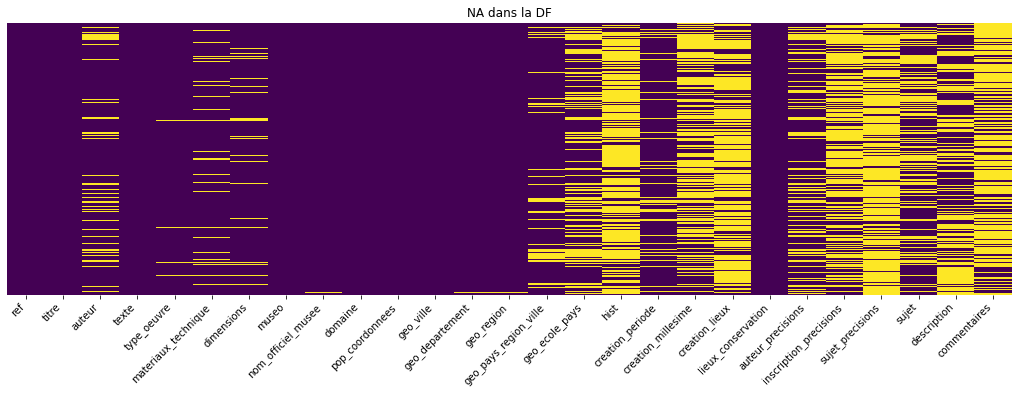

In [656]:
figure, ax = color_graph_background(1,1)
sns.heatmap(df_clean.isnull(), yticklabels=False,cbar=False, cmap='viridis')
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.title("NA dans la DF")
figure.set_size_inches(18, 5, forward=True)
plt.show()

In [657]:
df_clean.columns

Index(['ref', 'titre', 'auteur', 'texte', 'type_oeuvre', 'materiaux_technique',
       'dimensions', 'museo', 'nom_officiel_musee', 'domaine',
       'pop_coordonnees', 'geo_ville', 'geo_departement', 'geo_region',
       'geo_pays_region_ville', 'geo_ecole_pays', 'hist', 'creation_periode',
       'creation_millesime', 'creation_lieux', 'lieux_conservation',
       'auteur_precisions', 'inscription_precisions', 'sujet_precisions',
       'sujet', 'description', 'commentaires'],
      dtype='object')

In [125]:
display(HTML(df_clean[['ref', 'titre', 'auteur', 'texte', 'type_oeuvre', 'materiaux_technique',
       'dimensions', 'nom_officiel_musee', 'domaine', 'pop_coordonnees',
       'geo_ville', 'geo_departement', 'geo_region', 'geo_pays_region_ville',
       'geo_ecole_pays', 'hist', 'creation_periode', 'creation_millesime',
       'creation_lieux', 'lieux_conservation', 'auteur_precisions',
       'inscription_precisions', 'sujet_precisions', 'sujet', 'description',
       'commentaires']].head().to_html()))

,ref,titre,auteur,texte,type_oeuvre,materiaux_technique,dimensions,nom_officiel_musee,domaine,pop_coordonnees,geo_ville,geo_departement,geo_region,geo_pays_region_ville,geo_ecole_pays,hist,creation_periode,creation_millesime,creation_lieux,lieux_conservation,auteur_precisions,inscription_precisions,sujet_precisions,sujet,description,commentaires
0,M0435002007,En Détresse,LE GULUCHE Joseph Marie,"groupe de deux pêcheurs et un enfant en détresse à la proue d'une embarcation en difficulté. Terre cuite d'édition ; terre cuite, naturel. scène (naufrage, tempête, vague, bateau, marin pêcheur, homme, enfant, peur)",statuette,terre cuite,"l. 30 cm ; H. 65 cm ; P. 22 cm ; VOLUM. 0,0429",musée d'Art et d'Histoire Louis Senlecq,sculpture,"49.112285,2.21638",L'Isle-Adam,Val-d'Oise,Ile-de-France,NaN,France,"voir aussi : 2010.0.4, 2010.0.87 En Détresse",4e quart 19e siècle;1er quart 20e siècle,1890 entre;1908 et,France;Ile-de-France;Val d'Oise;L'Isle-Adam (lieu de création),L'Isle-Adam;musée Louis Senlecq,"Plourivo, 1849; Villejuif, 1915",Signé sur la terrasse au revers de la pièce : J. Le Guluche ; Cachet : Alphonse Hanne n°92 ; Inscription à l'avant de la pièce : En Détresse,groupe de deux pêcheurs et un enfant en détresse à la proue d'une embarcation en difficulté,"scène (naufrage, tempête, vague, bateau, marin pêcheur, homme, enfant, peur)","Terre cuite d'édition ; terre cuite, naturel",NaN
1,M0435001924,Bazeilles,THOMSEN Constant,"le titre : Bazeilles, fait peut-être un rappel de l'épisode de la guerre de 1870 : la bataille à Bazeilles. terre cuite, naturel. portrait (homme, en buste, expression du visage, douleur)",buste,terre cuite,"l. 30 CM ; H. 62 CM ; P. 23 CM ; VOLUM. 0,0428",musée d'Art et d'Histoire Louis Senlecq,sculpture,"49.112285,2.21638",L'Isle-Adam,Val-d'Oise,Ile-de-France,NaN,Danemark,voir aussi : n° 2010.0.25 Buste de Renet Tener,4e quart 19e siècle;1er quart 20e siècle,NaN,NaN,L'Isle-Adam;musée Louis Senlecq,"né en 1860 ; mort en 1921, actif vers 1893","Signé au revers de la pièce sur l'épaule droite : C. Thomsen ; Cachet au revers de la pièce : Union Artistique de la Sculpture Française, et en dessous cachet rectangulaire : 8016 LE MFI PARIS ; Inscription à l'avant de la pièce : BAZEILLES","le titre : Bazeilles, fait peut-être un rappel de l'épisode de la guerre de 1870 : la bataille à Bazeilles","portrait (homme, en buste, expression du visage, douleur)","terre cuite, naturel",NaN
2,M0435002028,Vase ovoïde sur talon en étain,FJERDINGSTAD Christian (orfèvre),Vase ovoïde sur talon en étain,vase,étain,"H. 16,4 cm",musée d'Art et d'Histoire Louis Senlecq,orfèvrerie,"49.112285,2.21638",L'Isle-Adam,Val-d'Oise,Ile-de-France,NaN,Danemark,"voir aussi : 2010.5.1, 2010.5.2, 2010.5.3, 2010.5.4, 2010.5.5",1ère moitié 20e siècle,1920 entre;1930 et,France;Ile-de-France;Val d'Oise;L'Isle-Adam (lieu de création),L'Isle-Adam;musée Louis Senlecq,"né en 1891 ; mort en 1968 ; Christian Fjerginstad avait son atelier d'orfèvrerie à L'Isle-Adam de 1921 à 1960, 19 rue Martel, il travailla pour Christofle de 1921 à 1941",Poinçon : Etain de L'Isle-Adam ; n° 10-89 à l'intérieur du talon de la pièce ; signé à l'intérieur du talon : FJERGINSTAD,NaN,NaN,Vase ovoïde sur talon en étain,NaN
3,08120020599,"Porte d'un édifice, à Daours ; Daours : Porte (autre titre)",DUTHOIT Louis,"Ce dessin représente une porte d'édifice à Daours (Somme), avec tympan et archivolte sculptée. Encre sur papier calque collé sur papier blanc. vue d'architecture (Daours, porte, archivolte)","encre, papier calque, papier (blanc) Encre sur papier calque collé sur papier blanc","encre, papier calque, papier (blanc)",Hauteur en cm 10.7 ; Largeur en cm 8,musée de Picardie,dessin,"49.890413,2.295968",Amiens,Somme,Hauts-de-France,Picardie ; Somme,France,NaN,3e quart 19e siècle,1850,NaN,Amiens;musée de Picardie,"DUTHOIT : Amiens, 1807/04/15 ; Amiens, 1874/12/30 ; nationalité : Française","monogrammé, en bas à gauche : L D ; annoté, sur le montage, en haut. Cette annotation correspo

In [128]:
df_clean['creation_periode'].value

0    4e quart 19e siècle;1er quart 20e siècle
1    4e quart 19e siècle;1er quart 20e siècle
2                      1ère moitié 20e siècle
3                         3e quart 19e siècle
4                         3e quart 19e siècle
Name: creation_periode, dtype: object

In [124]:
display(HTML(df_clean.loc[(df_clean['commentaires'].notna()), ['titre','auteur', 'commentaires']].head().to_html()))

,titre,auteur,commentaires
19,"Sur la plate-forme du char, Diomède, vêtu d'une tunique courte, debout, légèrement penché vers l'avant, tient les renes de deux chevaux fougueux qui se cabrent. Les deux animaux sont saisis dans des attitudes et des mouvement sensiblement différents. Il convient de remarquer le soin porté dans la réalisation des détails de l'attelage et de la tête de lion à l'avant du char. Le souci d'une finition minutieuse se retrouve aussi au niveau de la finesse d'exécution qui caractérise la cuirasse protégeant le buste d'Athéna et le décor de son bouclier",AUBRAY Fils,élément principal d'une garniture de cheminée comprenant également deux chandeliers (1984.3.2)
41,La Sainte Famille avec saint Jean-Baptiste et sainte Anne,MINGE Raphaël (d'après);LEVASSEUR Jean Charles (graveur),"les archives ayant brûlé pendant la deuxième guerre mondiale, les renseignements sur l'acquisition des oeuvres graphiques ne sont pas toujours connus"
42,L'amour sur les eaux ; Amours sur les eaux (autre titre) ; Putti sur les eaux (autre titre),BOUCHER François (d'après);LEVASSEUR Jean Charles (graveur),"les archives ayant brûlé pendant la deuxième guerre mondiale, les renseignements sur l'acquisition des oeuvres graphiques ne sont pas toujours connus"
78,Copie d'une frise,"BODINIER Guillaume (dessinateur, peintre)",Sur le même support que MTC 3060.2
112,L'île de Regatta près d'Henley-on-Thames,TURPIN DE CRISSE Lancelot Henri Roland;TURPIN DE CRISSE Père (dessinateur),ensemble de quatre vingt dix dessins


In [119]:
display(HTML(df_clean.loc[(df_clean['auteur'].notna())&(df_clean['auteur'].str.contains('DAUMIER')), ['auteur', 'auteur_precisions', 'commentaires']].head().to_html()))

,auteur,auteur_precisions,commentaires
1227,DAUMIER Honoré;AUBERT & Cie (imprimeur),"DAUMIER Honoré : Marseille, 1808 ; Valmondois (Val-d'Oise), 1879 ; AUBERT & Cie (imprimeur) : Paris, Place de la Bourse",NaN
2381,DAUMIER Honoré (caricaturiste);AUBERT & Cie (imprimeur),"DAUMIER : Marseille, 1808 ; Valmondois, 1879 ; AUBERT : Imprimeur Place de la Bourse, 29. Paris (?)",NaN
2382,DAUMIER Honoré (caricaturiste);AUBERT & Cie (imprimeur),"DAUMIER : Marseille, 1808 ; Valmondois, 1879 ; AUBERT : Imprimeur Place de la Bourse, 29. Paris (?)",NaN
3930,DAUMIER Honoré (caricaturiste);AUBERT & Cie (imprimeur),"DAUMIER : Marseille, 1808 ; Valmondois, 1879 ; AUBERT : Imprimeur Place de la Bourse, 29. Paris (?)",NaN
5581,DAUMIER Honoré (auteur);AUBERT & Cie (imprimeur),"DAUMIER Honoré (auteur) : Marseille, 1808 ; Valmondois (Val-d’Oise), 1879 ; AUBERT & Cie (imprimeur) : Paris, Place de la Bourse",NaN


In [45]:
na_columns_class = get_na_columns_classement(df_clean.copy(), verbose=1)

0 => 6 ['ref', 'titre', 'domaine', 'geo_ville', 'pop_coordonnees', 'lieux_conservation']
1 => 4 ['type_oeuvre', 'geo_departement', 'geo_region', 'nom_officiel_musee']
8 => 1 ['dimensions']
10 => 1 ['materiaux_technique']
11 => 2 ['geo_pays_region_ville', 'creation_periode']
13 => 1 ['auteur']
26 => 1 ['auteur_precisions']
32 => 1 ['geo_ecole_pays']
43 => 1 ['sujet']
46 => 1 ['description']
52 => 1 ['creation_millesime']
58 => 1 ['inscription_precisions']
71 => 1 ['sujet_precisions']
73 => 1 ['creation_lieux']
74 => 2 ['commentaires', 'hist']


In [56]:
display(HTML(df_clean[df_clean['type_oeuvre'].isna()].head().to_html()))

,ref,titre,auteur,sujet,type_oeuvre,materiaux_technique,description,commentaires,dimensions,domaine,geo_ville,geo_departement,geo_region,geo_pays_region_ville,geo_ecole_pays,pop_coordonnees,hist,nom_officiel_musee,creation_periode,creation_millesime,creation_lieux,lieux_conservation,auteur_precisions,inscription_precisions,sujet_precisions
1929,02110005094,Les Martyrs d'Agaune ; Supplice de guerriers (titre ancien) ; Martyre de deux Saints (titre ancien),SCHUT Cornelis I,"scène historique (soldat : saint Maurice d'Agaune, martyre, décollation, cadavre, bourreau, épée, foule, lance, putti : dans les airs, Gaulois)",NaN,NaN,NaN,NaN,mesures en cm : H. 29.5 ; l. 32.4,dessin,Rennes,Ille-et-Vilaine,Bretagne,Bretagne ; Ille-et-Vilaine,Flandres,"48.109837,-1.674981",NaN,musée des Beaux-Arts,1ère moitié 17e siècle,NaN,NaN,Rennes;musée des beaux-arts,"Anvers, 1553 ; Anvers, 1655","inscription, h. sur cadre encre brune : 1599 ; inscription, b.d. plume et encre brune : 120",NaN
2381,01720004006,Les représentants représentés ; Lanjuinais,DAUMIER Honoré (caricaturiste);AUBERT & Cie (imprimeur),"portrait charge (Lanjuinais Victor Ambroise, parlementaire, homme, en pied)",NaN,NaN,NaN,NaN,H. en cm 36 ; l. en cm 25,estampe,Mâcon,Saône-et-Loire,Bourgogne-Franche-Comté,France ; Bourgogne ; Saône-et-Loire,France,"46.30716,4.832892",NaN,musée des ursulines musée Lamartine,19e siècle,NaN,France;Paris (lieu d'exécution),Mâcon;musée des Ursulines,"DAUMIER : Marseille, 1808 ; Valmondois, 1879 ; AUBERT : Imprimeur Place de la Bourse, 29. Paris (?)",NaN,NaN
2383,01720004052,Marie,"BRY Auguste (imprimeur, lithographe);ROSSELIN (éditeur)","portrait (Marie Pierre, homme, en buste, homme politique)",NaN,NaN,NaN,NaN,H. en cm 27 ; l. en cm 18,estampe,Mâcon,Saône-et-Loire,Bourgogne-Franche-Comté,France ; Bourgogne ; Saône-et-Loire,France,"46.30716,4.832892",NaN,musée des ursulines musée Lamartine,19e siècle,NaN,NaN,Mâcon;musée des Ursulines,BRY : lithographe actif à Paris au 19e siècle,NaN,NaN
2384,01720004054,Odilon Barrot,"DELPECH François Séraphin (graveur, imprimeur)","portrait (Barrot Odilon, homme, en buste, homme politique)",NaN,NaN,NaN,NaN,H. en cm 27 ; l. en cm 18,estampe,Mâcon,Saône-et-Loire,Bourgogne-Franche-Comté,France ; Bourgogne ; Saône-et-Loire,France,"46.30716,4.832892",NaN,musée des ursulines musée Lamartine,19e siècle,NaN,NaN,Mâcon;musée des Ursulines,"DELPECH : Paris, 1778 ; Paris, 1825",NaN,NaN
2385,01720004060,"Baudin sur les barricades, le 3 déc 1851",PICHIO Ernest Louis,"scène historique;portrait (Baudin Alphonse, homme politique, barricade, attroupement)",NaN,NaN,NaN,NaN,H. en cm 41 ; l. en cm 56,estampe,Mâcon,Saône-et-Loire,Bourgogne-Franche-Comté,France ; Bourgogne ; Saône-et-Loire,NaN,"46.307508,4.833156",NaN,musée des ursulines musée Lamartine,3e quart 19e siècle,1869,NaN,Mâcon;musée des Ursulines,"?, 1840 ; ?, 1893",NaN,NaN


In [57]:
display(HTML(df_clean[df_clean['type_oeuvre'].isna()].head().to_html()))

,ref,titre,auteur,sujet,type_oeuvre,materiaux_technique,description,commentaires,dimensions,domaine,geo_ville,geo_departement,geo_region,geo_pays_region_ville,geo_ecole_pays,pop_coordonnees,hist,nom_officiel_musee,creation_periode,creation_millesime,creation_lieux,lieux_conservation,auteur_precisions,inscription_precisions,sujet_precisions
1929,02110005094,Les Martyrs d'Agaune ; Supplice de guerriers (titre ancien) ; Martyre de deux Saints (titre ancien),SCHUT Cornelis I,"scène historique (soldat : saint Maurice d'Agaune, martyre, décollation, cadavre, bourreau, épée, foule, lance, putti : dans les airs, Gaulois)",NaN,NaN,NaN,NaN,mesures en cm : H. 29.5 ; l. 32.4,dessin,Rennes,Ille-et-Vilaine,Bretagne,Bretagne ; Ille-et-Vilaine,Flandres,"48.109837,-1.674981",NaN,musée des Beaux-Arts,1ère moitié 17e siècle,NaN,NaN,Rennes;musée des beaux-arts,"Anvers, 1553 ; Anvers, 1655","inscription, h. sur cadre encre brune : 1599 ; inscription, b.d. plume et encre brune : 120",NaN
2381,01720004006,Les représentants représentés ; Lanjuinais,DAUMIER Honoré (caricaturiste);AUBERT & Cie (imprimeur),"portrait charge (Lanjuinais Victor Ambroise, parlementaire, homme, en pied)",NaN,NaN,NaN,NaN,H. en cm 36 ; l. en cm 25,estampe,Mâcon,Saône-et-Loire,Bourgogne-Franche-Comté,France ; Bourgogne ; Saône-et-Loire,France,"46.30716,4.832892",NaN,musée des ursulines musée Lamartine,19e siècle,NaN,France;Paris (lieu d'exécution),Mâcon;musée des Ursulines,"DAUMIER : Marseille, 1808 ; Valmondois, 1879 ; AUBERT : Imprimeur Place de la Bourse, 29. Paris (?)",NaN,NaN
2383,01720004052,Marie,"BRY Auguste (imprimeur, lithographe);ROSSELIN (éditeur)","portrait (Marie Pierre, homme, en buste, homme politique)",NaN,NaN,NaN,NaN,H. en cm 27 ; l. en cm 18,estampe,Mâcon,Saône-et-Loire,Bourgogne-Franche-Comté,France ; Bourgogne ; Saône-et-Loire,France,"46.30716,4.832892",NaN,musée des ursulines musée Lamartine,19e siècle,NaN,NaN,Mâcon;musée des Ursulines,BRY : lithographe actif à Paris au 19e siècle,NaN,NaN
2384,01720004054,Odilon Barrot,"DELPECH François Séraphin (graveur, imprimeur)","portrait (Barrot Odilon, homme, en buste, homme politique)",NaN,NaN,NaN,NaN,H. en cm 27 ; l. en cm 18,estampe,Mâcon,Saône-et-Loire,Bourgogne-Franche-Comté,France ; Bourgogne ; Saône-et-Loire,France,"46.30716,4.832892",NaN,musée des ursulines musée Lamartine,19e siècle,NaN,NaN,Mâcon;musée des Ursulines,"DELPECH : Paris, 1778 ; Paris, 1825",NaN,NaN
2385,01720004060,"Baudin sur les barricades, le 3 déc 1851",PICHIO Ernest Louis,"scène historique;portrait (Baudin Alphonse, homme politique, barricade, attroupement)",NaN,NaN,NaN,NaN,H. en cm 41 ; l. en cm 56,estampe,Mâcon,Saône-et-Loire,Bourgogne-Franche-Comté,France ; Bourgogne ; Saône-et-Loire,NaN,"46.307508,4.833156",NaN,musée des ursulines musée Lamartine,3e quart 19e siècle,1869,NaN,Mâcon;musée des Ursulines,"?, 1840 ; ?, 1893",NaN,NaN


<div style="display: flex; background-color: blue;" >

# SEPARATION des données
</div>

In [658]:
df_clean.columns

Index(['ref', 'titre', 'auteur', 'texte', 'type_oeuvre', 'materiaux_technique',
       'dimensions', 'museo', 'nom_officiel_musee', 'domaine',
       'pop_coordonnees', 'geo_ville', 'geo_departement', 'geo_region',
       'geo_pays_region_ville', 'geo_ecole_pays', 'hist', 'creation_periode',
       'creation_millesime', 'creation_lieux', 'lieux_conservation',
       'auteur_precisions', 'inscription_precisions', 'sujet_precisions',
       'sujet', 'description', 'commentaires'],
      dtype='object')

In [129]:
df_completed = df_clean.copy()

In [160]:
df_auteur_origin = df_clean[['auteur', 'auteur_precisions']]
print(df_auteur_origin.shape)
df_auteur_origin = df_auteur_origin.dropna(subset=['auteur'])
df_auteur_origin = df_auteur_origin.drop_duplicates()
print(df_auteur_origin.shape)
df_auteur_origin.head()

(547355, 2)
(83927, 2)


,auteur,auteur_precisions
0,LE GULUCHE Joseph Marie,"Plourivo, 1849; Villejuif, 1915"
1,THOMSEN Constant,"né en 1860 ; mort en 1921, actif vers 1893"
2,FJERDINGSTAD Christian (orfèvre),né en 1891 ; mort en 1968 ; Christian Fjergins...
3,DUTHOIT Louis,"DUTHOIT : Amiens, 1807/04/15 ; Amiens, 1874/12..."
4,DUTHOIT Aimé;DUTHOIT Louis,"DUTHOIT Aimé : Amiens, 1803/11/24 ; Amiens, 18..."


In [135]:
import pandas as pd

In [443]:
# df_musees = df_clean[['','nom_officiel_musee','lieux_conservation']]
# print(df_musees.shape)
# df_musees = df_musees.drop_duplicates()
# df_musees_ville_pays = df_musees['lieux_conservation'].dropna().str.split(r";", expand=True)
# print(df_musees.shape, df_musees_ville_pays.shape)

(547355, 2)
(1151, 2) (1140, 4)


In [514]:
pays_to_replace = ['Algérie', 'La Réunion', 'Belgique','Etats-Unis','Grande-Bretagne','Suède','Tahiti', 'République Tchèque', 'Allemagne', "République d'Irlande"]
for p in pays_to_replace:
    df_musees_ville_pays.loc[df_musees_ville_pays[0]==p, "pays"] = p
    df_musees_ville_pays.loc[df_musees_ville_pays["pays"]==p, 0] = df_musees_ville_pays.loc[df_musees_ville_pays["pays"]==p, 1]


for idx in [0, 1,2]:
    for text in ['Volé', "manquant", "Manquant",'dépôt','oeuvre détruite','en dépôt', 'détruit','volé','détruit (?)','disparu']:
        df_musees_ville_pays.loc[(df_musees_ville_pays[idx].notna()) & (df_musees_ville_pays[idx]==text), idx] = np.nan
    if idx > 0:
        df_musees_ville_pays.loc[(df_musees_ville_pays[0].isna()), 0] = df_musees_ville_pays.loc[(df_musees_ville_pays[0].isna()), idx]
        df_musees_ville_pays.loc[(df_musees_ville_pays[idx].notna()) & (df_musees_ville_pays[idx]==df_musees_ville_pays[0]), idx] = np.nan
        if idx > 1:
            df_musees_ville_pays.loc[(df_musees_ville_pays[idx-1].isna()), idx] = df_musees_ville_pays.loc[(df_musees_ville_pays[idx-1].isna()), idx]
            df_musees_ville_pays.loc[(df_musees_ville_pays[idx].notna()) & (df_musees_ville_pays[idx]==df_musees_ville_pays[idx-1]), idx] = np.nan


C:\Users\User\AppData\Local\Temp\ipykernel_22160\2410826272.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_musees_ville_pays.loc[df_musees_ville_pays[0]==p, "pays"] = p
C:\Users\User\AppData\Local\Temp\ipykernel_22160\2410826272.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_musees_ville_pays.loc[df_musees_ville_pays["pays"]==p, 0] = df_musees_ville_pays.loc[df_musees_ville_pays["pays"]==p, 1]
C:\Users\User\AppData\Local\Temp\ipykernel_22160\2410826272.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

In [539]:
lieux_conservation_src = df_clean['lieux_conservation'].unique()

lieux_coservation2 = []

for lieu in lieux_conservation_src:
    if isinstance(lieu, str) \
        and "paris" not in lieu.lower():
        lieux_coservation2.append(lieu.strip())
lieux_coservation2


["L'Isle-Adam;musée Louis Senlecq",
 'Amiens;musée de Picardie',
 'Vendôme;musée de Vendôme',
 "Angers;musée des beaux-arts et galerie David-d'Angers",
 'Besançon;musée du Temps',
 'Strasbourg;musée des Arts décoratifs',
 'Soissons;musée de Soissons',
 'Dijon;musée de la vie bourguignonne',
 'Abbeville;musée Boucher de Perthes',
 'Sens;musée municipal',
 'Romans;musée international de la Chaussure',
 "Saint-Tropez;musée de l'Annonciade",
 'Auxonne;musée Bonaparte',
 "Saint-Etienne;musée d'Art et d'Industrie",
 "Saint-Malo;musée d'Histoire de Saint-Malo",
 'Arles;musée de la Camargue',
 'Nantes;musée Dobrée',
 'Rennes;musée des beaux-arts',
 'Chantilly;musée Condé',
 'Blois;musée du château de Blois',
 "Sainte-Menehould;musée d'Art et d'Histoire",
 'Salles-la-Source;musée des Arts-et-Métiers traditionnels',
 'Saumur;Château-Musée',
 'Saumur',
 "Colmar;musée d'Unterlinden",
 'Mâcon;musée des Ursulines',
 'Strasbourg;musée des beaux-arts',
 'Castres;musée Goya',
 'Caudebec-en-Caux;musée B

In [518]:
df_musees_ville_pays[(df_musees_ville_pays['pays'] == 'Etats-Unis')]

,0,1,2,pays
237373,NaN,NaN,NaN,Etats-Unis
253558,NaN,NaN,NaN,Etats-Unis
439485,NaN,NaN,NaN,Etats-Unis


In [513]:
cities = sorted(df_musees_ville_pays[0].value_counts().keys())
cities.extend(df_musees_ville_pays[1].value_counts().keys())
cities.extend(df_musees_ville_pays[2].value_counts().keys())
cities = set(cities)
cities_clean = set()
sorted(cities)
for c in cities:
    low = c.lower()
    if len(c) > 0 and "musée" not in low and not low.startswith("école") \
        and not low.startswith("écomusée")\
        and not low.startswith('conseil ')\
        and not low.startswith('CAPC'.lower())\
        and not low.startswith('Ecomusée'.lower()):
        cities_clean.add(c)
cities_clean

{'ARCHEA Archéologie en Pays de France',
 'Abbeville',
 'Agde',
 'Agen',
 'Aix-en-Provence',
 'Aix-les-Bains',
 'Ajaccio',
 'Alençon',
 'Allevard',
 'Altkirch',
 'Amboise',
 'Amiens',
 'Angers',
 'Annecy',
 'Antibes',
 'Aoste',
 'Arbois',
 'Argenteuil',
 'Arles',
 'Arras',
 'Aubenas',
 'Auch',
 'Autun',
 'Auvers-sur-Oise',
 'Auxerre',
 'Auxonne',
 'Avallon',
 'Avignon',
 'Avranches',
 'Azay-le-Rideau',
 'Bagnols-sur-Cèze',
 'Bagnères-de-Bigorre',
 'Bar-le-Duc',
 'Barcelonnette',
 'Barentin',
 'Bastia',
 'BaudÂ',
 'Bayeux',
 'Bayonne',
 'Beaune',
 'Beauvais',
 'Belfort',
 'Bernay',
 'Besançon',
 'Bibliothèque Nationale de France',
 'Biesheim',
 'Biot',
 'Blois',
 'Blérancourt',
 'Bonn',
 'Bordeaux',
 'BordeauxÂ',
 'Boulogne-sur-Mer',
 'Bourbon-Lancy',
 'Bourg-Saint-Maurice',
 'Bourg-en-Bresse',
 'Bourges',
 'Bourgoin-Jallieu',
 'Bourneville',
 'Bouxwiller',
 'Brest',
 'Briançon',
 'Brunoy',
 'Bruxelles',
 'Bry-sur-Marne',
 'Béthune',
 'CUCM',
 'Caen',
 'Cahors',
 'Calais',
 'Cambrai',
 

In [517]:
countries = sorted(df_musees_ville_pays["pays"].value_counts().keys())
countries = set(countries)
sorted(countries)
countries_clean = set()
for c in countries:
    low = c.lower()
    if len(c) > 0 and "musée" not in low and not low.startswith("école") \
        and not low.startswith("écomusée")\
        and not low.startswith('conseil ')\
        and not low.startswith('CAPC'.lower())\
        and not low.startswith('Ecomusée'.lower()):
        countries_clean.add(c)
countries_clean

{'Algérie',
 'Allemagne',
 'Belgique',
 'Etats-Unis',
 'France',
 'Grande-Bretagne',
 'Italie',
 'La Réunion',
 'République Tchèque',
 "République d'Irlande",
 'Suède',
 'Tahiti'}

In [546]:
df_clean.columns

Index(['ref', 'titre', 'auteur', 'texte', 'type_oeuvre', 'materiaux_technique',
       'dimensions', 'nom_officiel_musee', 'domaine', 'pop_coordonnees',
       'geo_ville', 'geo_departement', 'geo_region', 'geo_pays_region_ville',
       'geo_ecole_pays', 'hist', 'creation_periode', 'creation_millesime',
       'creation_lieux', 'lieux_conservation', 'auteur_precisions',
       'inscription_precisions', 'sujet_precisions', 'sujet', 'description',
       'commentaires'],
      dtype='object')

<div style="display: flex; background-color: indigo;" >

#### MUSEE
</div>

In [659]:
df_musee = df_clean[['museo','nom_officiel_musee','pop_coordonnees','geo_ville']]
print(df_musee.shape)
df_musee = df_musee.drop_duplicates()
print(df_musee.shape)

(547355, 4)
(915, 4)


In [660]:
df_musee.head()

,museo,nom_officiel_musee,pop_coordonnees,geo_ville
0,M0435,musée d'Art et d'Histoire Louis Senlecq,"49.112285,2.21638",L'Isle-Adam
3,M0812,musée de Picardie,"49.890413,2.295968",Amiens
10,M0277,musée municipal,"47.797411,1.060868",Vendôme
15,M0748,musée des beaux-arts et galerie David-d'Angers,"47.469132,-0.554372",Angers
18,M0333,musée du Temps,"47.235776,6.025004",Besançon


In [661]:
df_musee[df_musee['museo'].isna()]

,museo,nom_officiel_musee,pop_coordonnees,geo_ville
23943,NaN,NaN,"0.0,0.0",Roubaix
24018,NaN,NaN,"0.0,0.0",Lens
235622,NaN,NaN,"0.0,0.0",Poitiers
260502,NaN,NaN,"0.0,0.0",Marseille
441821,NaN,NaN,"0.0,0.0",Paris
599591,NaN,NaN,"0.0,0.0",oeuvre détruite


In [669]:
df_musee.loc[599591]

museo                             NaN
nom_officiel_musee                NaN
pop_coordonnees               0.0,0.0
geo_ville             oeuvre détruite
Name: 599591, dtype: object

In [671]:
print(df_musee.shape)
df_musee = df_musee[df_musee['museo'].notna()]
print(df_musee.shape)

(915, 4)
(909, 4)


In [675]:
df_musee.loc[df_musee['pop_coordonnees']=='0.0,0.0','pop_coordonnees'] = np.nan

C:\Users\User\AppData\Local\Temp\ipykernel_22160\798256369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_musee.loc[df_musee['pop_coordonnees']=='0.0,0.0','pop_coordonnees'] = np.nan


In [685]:
df_musee['NB_NAN'] = df_musee.isna().sum(axis=1)
df_musee['NB_NAN_1'] = df_musee.isna().sum(axis=1)
df_musee_sort = df_musee.sort_values(['NB_NAN_1', 'museo'])
print(df_musee_sort.shape)
df_musee_sort = df_musee_sort.drop_duplicates(['museo'], keep='first')
print(df_musee_sort.shape)
df_musee_sort.head()

(909, 6)
(483, 6)


C:\Users\User\AppData\Local\Temp\ipykernel_22160\609582540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_musee['NB_NAN'] = df_musee.isna().sum(axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_22160\609582540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_musee['NB_NAN_1'] = df_musee.isna().sum(axis=1)


,museo,nom_officiel_musee,pop_coordonnees,geo_ville,NB_NAN,NB_NAN_1
180300,B9001,Bibliothèque de l'Assemblée Nationale,"48.86215,2.31897","Paris, Assemblée nationale",0,0
19100,B9002,Bibliothèque municipale de Grasse,"43.65559,6.91736",Grasse,0,0
1492,B9003,Bibliothèque municipale de Besançon,"47.23649,6.0274",Besançon,0,0
23932,M0003,musée du Pays de Hanau - histoire et vies d’un...,"48.824977,7.482915",Bouxwiller,0,0
182444,M0008,Maison de l'Archéologie des Vosges du Nord,"48.947444,7.650428",Niederbronn-les-Bains,0,0


In [698]:
df_coordonnees = df_musee_sort['pop_coordonnees'].dropna().str.split(r",", expand=True)
print(df_musee_sort.shape, df_coordonnees.shape)
df_coordonnees = df_coordonnees.rename(columns={0:"latitude", 1:'longitude'})
df_coordonnees.head()

(483, 6) (463, 2)


,latitude,longitude
180300,48.86215,2.31897
19100,43.65559,6.91736
1492,47.23649,6.0274
23932,48.824977,7.482915
182444,48.947444,7.650428


In [702]:
# pd.concat([df_musee, df_coordonnees], join='inner', ignore_index=False, copy=True)
df_musee_clean = pd.merge(df_musee_sort, df_coordonnees,left_index=True, right_index=True, copy=True, indicator=True)
df_musee_clean = df_musee_clean[['museo', 'nom_officiel_musee', 'geo_ville', 'latitude', 'longitude', 'pop_coordonnees']]
df_musee_clean = df_musee_clean.rename(columns={
    'geo_ville' : 'ville',
    'nom_officiel_musee' : 'nom',
})
df_musee_clean = df_musee_clean.sort_values(by=['ville'])
df_musee_clean = df_musee_clean.reset_index()
df_musee_clean = df_musee_clean.drop(columns=['index'], axis=1)
df_musee_clean

,museo,nom,ville,latitude,longitude,pop_coordonnees
0,M0811,musée Boucher de Perthes,Abbeville,50.10712,1.833193,"50.10712,1.833193"
1,M0465,musée de l'Ephèbe,Agde,43.298047,3.476702,"43.298047,3.476702"
2,M0087,musée municipal des beaux-arts,Agen,44.202895,0.615471,"44.202895,0.615471"
3,M0895,musée de l'atelier de Paul Cézanne,Aix-en-Provence,43.537816,5.446601,"43.537816,5.446601"
4,M0898,musée du vieil Aix,Aix-en-Provence,43.530857,5.447432,"43.530857,5.447432"
...,...,...,...,...,...,...
458,M1008,musée départemental de la Révolution française,Vizille,45.08753,5.773234,"45.08753,5.773234"
459,M1137,musée Mainssieux,Voiron,45.356047,5.579652,"45.356047,5.579652"
460,M0191,musée Zervos,Vézelay,47.464133,3.74361,"47.464133,3.74361"
461,M0022,musée Westercamp,Wissembourg,49.038815,7.944344,"49.038815,7.944344"


In [703]:
df_musee_clean.to_csv(join(data_set_path,'musees.csv'), index=False)

<div style="display: flex; background-color: indigo;" >

#### AUTEURS
</div>

In [710]:
df_aut1 = df_clean[['auteur','auteur_precisions']]
print(df_aut1.shape)
df_aut1 = df_aut1.drop_duplicates()
df_aut1['auteur'] = df_aut1['auteur'].fillna(df_aut1['auteur_precisions'])
df_aut1 = df_aut1.sort_values('auteur')
df_aut1 = df_aut1[df_aut1['auteur'].notna()]
print(df_aut1.shape)
df_aut1

(547355, 2)
(84207, 2)


,auteur,auteur_precisions
186816,"""PATRONENFABRIK"" ""KARLSRUHE""",NaN
182852,"""S.O.M.U.A Sté d'outillage mécanique et d'usin...",NaN
483996,(imprimeur),NaN
418628,- Atelier mis en place par Jean de Valence. Mê...,- Atelier mis en place par Jean de Valence. Mê...
383162,1787 ; 1812 ; Faïencerie de l'Ile ?,1787 ; 1812 ; Faïencerie de l'Ile ?
...,...,...
555257,Établissement Allinquant (constructeur),NaN
26888,"Établissements ""Jeux et jouets""","Fabricant, autre forme du nom : JEX"
182860,"éditions CEPI, Paris;",NaN
7089,établissement Cirier-Pavard (fabricant),établissement Cirier-Pavard (fabricant)


In [722]:
df_aut1.loc[(df_aut1['auteur'].notna()) & (df_aut1['auteur'].str.len()>200), 'auteur']

418628    - Atelier mis en place par Jean de Valence. Mê...
582057    A vérifier : Nicolas-Pierre Tiolier : Paris, 9...
9654      ABOUT Edmond (écrivain);DORE Gustave (dessinat...
468365    ADAM (graveur);FORTIER (graveur);TARDIEU B (gr...
17602     AHLERS-HESTERMANN Friedrich;BECKMANN Max;CASPA...
                                ...                        
21127     VOGEL Lucien (directeur);FOUCHARDIERE Georges ...
419817    Verdoux;Ducourtioux & Huillard (graveur);FRAIP...
269994    YENCESSE Ovide (graveur);GASQ Paul (graveur);B...
75112     de 1648 à 1698, la fabrique d'Edme Poterat obt...
382696    la première faïencerie lilloise fut créée en 1...
Name: auteur, Length: 102, dtype: object

In [724]:
df_aut1.loc[(df_aut1['auteur'].isna()) & (df_aut1['auteur_precisions'].notna()) & (df_aut1['auteur_precisions'].str.len()<200), 'auteur'] = df_aut1.loc[(df_aut1['auteur'].isna()) & (df_aut1['auteur_precisions'].notna()) & (df_aut1['auteur_precisions'].str.len()<200), 'auteur_precisions']

In [725]:
df_aut1 = df_clean[['auteur','auteur_precisions']]
print(df_aut1.shape)
df_aut1 = df_aut1.drop_duplicates()
df_aut1.loc[(df_aut1['auteur'].isna()) & (df_aut1['auteur_precisions'].notna()) & (df_aut1['auteur_precisions'].str.len()<200), 'auteur'] = df_aut1.loc[(df_aut1['auteur'].isna()) & (df_aut1['auteur_precisions'].notna()) & (df_aut1['auteur_precisions'].str.len()<200), 'auteur_precisions']
# df_aut1['auteur'] = df_aut1['auteur'].fillna(df_aut1['auteur_precisions'])
df_aut1 = df_aut1.drop_duplicates()
df_aut1 = df_aut1.sort_values('auteur')
df_aut1 = df_aut1[df_aut1['auteur'].notna()]
print(df_aut1.shape)

to_replace = {
    '"' : "",
    "établissement " : "",
    'Établissement ' : "",
    "Établissements ": "",
    # '(fabricant)' : "",
    # '(imprimeur)': "",
    # '(constructeur)': "",
    # '(émetteur)': "",
    "\? (copie d\'après);": "",
    "? (d\'après)": "",
}
for str_1, str_2 in to_replace.items():
    df_aut1.loc[df_aut1['auteur'].notna(), 'auteur'] = df_aut1.loc[df_aut1['auteur'].notna(), 'auteur'].str.replace(str_1, str_2, regex=False)


df_aut1.loc[df_aut1['auteur'].notna(), 'auteur'] = df_aut1.loc[df_aut1['auteur'].notna(), 'auteur'].str.strip()
df_aut1.loc[(df_aut1['auteur'].notna()) & (df_aut1['auteur'])=='', 'auteur'] = np.nan
df_aut1 = df_aut1[df_aut1['auteur'].notna()]
df_aut1 = df_aut1.drop_duplicates()
print(df_aut1.shape)
display(HTML(df_aut1.head(20).to_html()))

(547355, 2)
(84195, 2)
(84195, 2)


,auteur,auteur_precisions
186816,PATRONENFABRIK KARLSRUHE,NaN
182852,"S.O.M.U.A Sté d'outillage mécanique et d'usinage d'artillerie, 19 avenue de la gare St-Ouen 1930;",NaN
483996,(imprimeur),NaN
383162,1787 ; 1812 ; Faïencerie de l'Ile ?,1787 ; 1812 ; Faïencerie de l'Ile ?
189656,1848 Le Chesnay - 1916 Argenteuil,1848 Le Chesnay - 1916 Argenteuil
496526,27E REGIMENT D'INFANTERIE (émetteur),"27E RÉGIMENT D'INFANTERIE : Voir DO '27e Régiment d'Infanterie, historique' Brève chronologie des noms du 27e Régiment d'Infanterie : Régiment de Villeroy (1616-1631), Régiment d'Alincourt (1631-1635), Régiment du Lyonnais (1635-1791), 27e Régiment d'Infanterie de Ligne (1791-1794), 27e Demi-Brigade de Bataille (1794-1796), 27e Demi-Brigade d'Infanterie de Ligne (1796-1803). A partir de 1803, il se nomme 27e Régiment d'Infanterie de ligne : il garde ce nom jusqu'en 1998, mais subit plusieurs dissolutions. Il existe de 1803 à 1815, de 1820 à 1942, de 1945 à 1957, de 1959 à 1963, de 1965 à 1977, de 1993 à 1998. Il arrive à Dijon en 1875 à la Caserne Vaillant, et s'installe progressivement à la Caserne Junot après la Deuxième Guerre Mondiale."
409669,3 F (promoteur immobilier);BOFILL RICARDO (architecte),NaN
500522,;VOSTERMANN Lucas I,"VOSTERMANN, Bommel 1595 ; Anvers 1675"
422686,? (copie d'après);ALBANI Francesco dit L'ALBANE (genre de);ALBANI Francesco dit L'ALBANE (anciennement attribué à),NaN
198515,? (d'après),NaN


In [726]:
df_aut2 = df_aut1['auteur'].dropna().str.split(r";", expand=True)
print(df_aut2.shape)
df_aut2

(84195, 44)


,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
186816,PATRONENFABRIK KARLSRUHE,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
182852,S.O.M.U.A Sté d'outillage mécanique et d'usina...,,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
483996,(imprimeur),None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
383162,1787,1812,Faïencerie de l'Ile ?,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
189656,1848 Le Chesnay - 1916 Argenteuil,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555257,Allinquant (constructeur),None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
26888,Jeux et jouets,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
182860,"éditions CEPI, Paris",,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7089,Cirier-Pavard (fabricant),None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [731]:
df_aut2[0].dropna().unique()

array(['PATRONENFABRIK KARLSRUHE',
       "S.O.M.U.A Sté d'outillage mécanique et d'usinage d'artillerie, 19 avenue de la gare St-Ouen 1930",
       '(imprimeur)', ..., 'éditions CEPI, Paris',
       'Cirier-Pavard (fabricant)', 'L. Crama (fabricant)'], dtype=object)

In [735]:
set_aut2 = None

for col in df_aut2.columns:
    if set_aut2 is None:
        set_aut2 = set(df_aut2[col].dropna().unique())
    else:
        for v in df_aut2[col].dropna().unique():
            if len(v)>0:
                set_aut2.add(v)

print(len(set_aut2))
set_aut2.remove('')
set_aut2

71040


{'COMMANVILLE Caroline (dessinateur)',
 'Rabier-Boulard Michel (éditeur)',
 'CARLI Auguste (?)',
 'MARC Auguste (?)',
 'TCHELITCHEW Pavel (patronyme)',
 'BALTHUS (DIT)',
 'FIEFFE Alphonse Charles Pierre',
 'JORDAENS Jacob I (peintre)',
 'BRIOSCO Andrea',
 'DAHLER J',
 'RIVALZ Antoine (peintre, atelier)',
 'THEPOT Marie-Madeleine',
 'TREMAUX Pierre',
 'DUCHEMIN (dessinateur)',
 'LAGAGE Pierre César',
 'WEGL Andrée',
 'BENFATTO Alvise',
 'EMY Henry',
 'SON Nicolas de (graveur)',
 'Bell Laboratories',
 'MAGNE Désiré Alfred',
 'SAMBAT Jean-Baptiste',
 'BASSET le Jeune (dit)',
 'PORREAU Jules (graveur)',
 'RICHARD Théodore',
 'CATTELAIN Philippe Auguste',
 'GRAND-MERE PARIS (dite)',
 'Adami Valerio',
 'BUQUET Narcisse Alexandre (dessinateur)',
 'FRANQUINET (graveur)',
 'DRIANT Emile (auteur)',
 'SAINT-AUBIN Augustin De',
 'MAITRE de 1518',
 "SCHALCKEN Godfried (inventeur, d'après)",
 'FRANCHOYS Peter (attribué)',
 'BROUWER Adriaen (?)',
 "RAVERAT Vincent Nicolas (d'après)",
 'MARANDET Guy (

In [740]:
# 55 761 auteurs => Ellande
auth3 = pd.DataFrame(set_aut2)
df_aut4 = auth3[0].dropna().str.split(r"(", expand=True)
print(df_aut4.shape)
df_aut4 = df_aut4.sort_values(0)
df_aut4

(71039, 4)


,0,1,2,3
55537,,attribué Ã ),None,None
43786,,dessinateur),None,None
69170,,"SIC , dit)",None,None
14443,,enlumineur),None,None
70723,,graveur),None,None
...,...,...,...,...
53288,Éditeur : CQLL E ?,None,None,None
51456,éditeur,None,None,None
60918,éditeur),None,None,None
29927,"éditions CEPI, Paris",None,None,None


In [ ]:
df_aut4[df_aut4[3].notna()]

In [750]:
df_aut4['nom_naissance'] =df_aut4[0]
df_aut4['dit'] =np.nan

dit_2_bool = (df_aut4[1].notna()) & ((df_aut4[1].str.contains('dit)', regex=False)) | (df_aut4[1].str.contains('dite)', regex=False)))
df_aut4.loc[dit_2_bool, 'dit'] = df_aut4.loc[dit_2_bool, 0]
# df_aut4.loc[dit_2_bool, 'nom_naissance'] = df_aut4.loc[dit_2_bool, 0]
print(df_aut4[dit_2_bool].shape)
df_aut4[dit_2_bool]

(2005, 6)


,0,1,2,3,nom_naissance,dit
69170,,"SIC , dit)",None,None,,
66273,,dit),None,None,,
39549,ABBATE Ciccio,dit),None,None,ABBATE Ciccio,ABBATE Ciccio
5224,ABEILLÉ Jack,dit),None,None,ABEILLÉ Jack,ABEILLÉ Jack
51665,ABEL-TRUCHET,dit),peintre),None,ABEL-TRUCHET,ABEL-TRUCHET
...,...,...,...,...,...,...
47780,ZUSH,dit),None,None,ZUSH,ZUSH
12440,ZUTMAN Lambert,dit),None,None,ZUTMAN Lambert,ZUTMAN Lambert
27390,ZUTNA,dit),None,None,ZUTNA,ZUTNA
56185,ZWILLER Auguste,dit),None,None,ZWILLER Auguste,ZWILLER Auguste


In [753]:
ne_2_bool = (df_aut4[1].notna()) & ((df_aut4[2].str.contains('né)', regex=False)) | (df_aut4[2].str.contains('née)', regex=False)))
df_aut4.loc[ne_2_bool, 'nom_naissance'] = df_aut4.loc[ne_2_bool, 1].str.replace('dit), ', '', regex=False)
df_aut4.loc[ne_2_bool, 'nom_naissance'] = df_aut4.loc[ne_2_bool, 'nom_naissance'].str.replace('dite), ', '', regex=False)
# df_aut4.loc[dit_2_bool, 'nom_naissance'] = df_aut4.loc[dit_2_bool, 0]
print(df_aut4[ne_2_bool].shape)
df_aut4[ne_2_bool]

(19, 6)


,0,1,2,3,nom_naissance,dit
8115,HAUDEBOURT-LESCOT Hortense,dite),née),None,dite),HAUDEBOURT-LESCOT Hortense
37944,MAILLAUD Fernand,"dit), MAILLAUD Guillaume Eugène Floran",né),dessinateur),MAILLAUD Guillaume Eugène Floran,MAILLAUD Fernand
15168,MAILLAUD Fernand,"dit), MAILLAUD Guillaume Eugène Floran",né),peintre),MAILLAUD Guillaume Eugène Floran,MAILLAUD Fernand
43882,NADAR Félix Gaspard,"dit), TOURNACHON Félix Gaspard",né),photographe),TOURNACHON Félix Gaspard,NADAR Félix Gaspard
63727,NADAR Félix Gaspard,"dit), TOURNACHON Félix Gaspard",né),photographe),TOURNACHON Félix Gaspard,NADAR Félix Gaspard
9763,NADAR Félix Gaspard,"dit), TOURNACHON Félix Gaspard",né),illustrateur),TOURNACHON Félix Gaspard,NADAR Félix Gaspard
7811,NADAR Félix Gaspard,"dit), TOURNACHON Félix Gaspard",né),None,TOURNACHON Félix Gaspard,NADAR Félix Gaspard
53104,Nadar Félix Gaspard,"dit), TOURNACHON Félix Gaspard",né),photographe),TOURNACHON Félix Gaspard,Nadar Félix Gaspard
40189,SAND Aurore,"dite), DUDEVANT Aurore, Jeanne, Claudine",née),None,"DUDEVANT Aurore, Jeanne, Claudine",SAND Aurore
22108,SAND Aurore,"dite), DUDEVANT Aurore, Jeanne, Claudine",née),auteur),"DUDEVANT Aurore, Jeanne, Claudine",SAND Aurore


In [769]:
df_aut4.loc[df_aut4[1]=='dit)', 1]=np.nan
df_aut4.loc[df_aut4[1]=='dite)', 1]=np.nan
df_aut4.loc[df_aut4[1]==df_aut4.loc[8115, 1], 1]=np.nan
df_aut4.loc[df_aut4['nom_naissance']==df_aut4.loc[8115, 'nom_naissance'], 'nom_naissance']=df_aut4.loc[df_aut4['nom_naissance']==df_aut4.loc[8115, 'nom_naissance'], 0]
df_aut4.loc[df_aut4[1]=='dit\)', 1]=np.nan
df_aut4.loc[df_aut4[1]=='d’après, dit)', 1]=np.nan
df_aut4.loc[df_aut4[2]=='née)', 2]=np.nan
df_aut4.loc[df_aut4[2]==df_aut4.loc[43882, 2], 2]=np.nan
df_aut4.loc[df_aut4[2]==df_aut4.loc[22108, 2], 2]=np.nan
df_aut4.loc[df_aut4[2]=='née\)', 2]=np.nan
df_aut4.loc[df_aut4[2]=='né\)', 2]=np.nan

In [762]:
df_aut4.loc[37944]

0                                      MAILLAUD Fernand 
1                dit), MAILLAUD Guillaume Eugène Floran 
2                                                   né) 
3                                           dessinateur)
nom_naissance          MAILLAUD Guillaume Eugène Floran 
dit                                    MAILLAUD Fernand 
Name: 37944, dtype: object

In [770]:
df_aut4[ne_2_bool]

,0,1,2,3,nom_naissance,dit
8115,HAUDEBOURT-LESCOT Hortense,NaN,NaN,None,HAUDEBOURT-LESCOT Hortense,HAUDEBOURT-LESCOT Hortense
37944,MAILLAUD Fernand,"dit), MAILLAUD Guillaume Eugène Floran",NaN,dessinateur),MAILLAUD Guillaume Eugène Floran,MAILLAUD Fernand
15168,MAILLAUD Fernand,"dit), MAILLAUD Guillaume Eugène Floran",NaN,peintre),MAILLAUD Guillaume Eugène Floran,MAILLAUD Fernand
43882,NADAR Félix Gaspard,"dit), TOURNACHON Félix Gaspard",NaN,photographe),TOURNACHON Félix Gaspard,NADAR Félix Gaspard
63727,NADAR Félix Gaspard,"dit), TOURNACHON Félix Gaspard",NaN,photographe),TOURNACHON Félix Gaspard,NADAR Félix Gaspard
9763,NADAR Félix Gaspard,"dit), TOURNACHON Félix Gaspard",NaN,illustrateur),TOURNACHON Félix Gaspard,NADAR Félix Gaspard
7811,NADAR Félix Gaspard,"dit), TOURNACHON Félix Gaspard",NaN,None,TOURNACHON Félix Gaspard,NADAR Félix Gaspard
53104,Nadar Félix Gaspard,"dit), TOURNACHON Félix Gaspard",NaN,photographe),TOURNACHON Félix Gaspard,Nadar Félix Gaspard
40189,SAND Aurore,"dite), DUDEVANT Aurore, Jeanne, Claudine",NaN,None,"DUDEVANT Aurore, Jeanne, Claudine",SAND Aurore
22108,SAND Aurore,"dite), DUDEVANT Aurore, Jeanne, Claudine",NaN,auteur),"DUDEVANT Aurore, Jeanne, Claudine",SAND Aurore


In [771]:
df_aut4.columns

Index([0, 1, 2, 3, 'nom_naissance', 'dit'], dtype='object')

In [774]:
df_aut5 = df_aut4[['nom_naissance', 'dit', 0, 1, 2, 3]]
df_aut5 = df_aut5.sort_values('nom_naissance')
df_aut5

,nom_naissance,dit,0,1,2,3
55537,,NaN,,attribué Ã ),None,None
22459,,NaN,,?),None,None
58858,,NaN,,"atelier, genre de)",None,None
36988,,NaN,,d'après),None,None
1529,,NaN,,"d'après, dessinateur, éditeur)",None,None
...,...,...,...,...,...,...
53288,Éditeur : CQLL E ?,NaN,Éditeur : CQLL E ?,None,None,None
51456,éditeur,NaN,éditeur,None,None,None
60918,éditeur),NaN,éditeur),None,None,None
29927,"éditions CEPI, Paris",NaN,"éditions CEPI, Paris",None,None,None


In [785]:
df_aut5 = df_aut4[['nom_naissance', 'dit', 0, 1, 2, 3]]
df_aut5 = df_aut5.sort_values('nom_naissance')
df_aut5.head(20)

,nom_naissance,dit,0,1,2,3
55537,,NaN,,attribué Ã ),None,None
22459,,NaN,,?),None,None
58858,,NaN,,"atelier, genre de)",None,None
36988,,NaN,,d'après),None,None
1529,,NaN,,"d'après, dessinateur, éditeur)",None,None
62740,,NaN,,sculpteur),None,None
32531,,NaN,,concepteur),None,None
69431,,NaN,,style de),None,None
66273,,,,NaN,None,None
35857,,NaN,,d'après) LE BAROCHE,"d'après, dit)",None


In [786]:
df_aut5 = df_aut4[['nom_naissance', 'dit', 0, 1, 2, 3]]
df_aut5 = df_aut5.sort_values('nom_naissance')

to_replace = {
    'attribué Ã )':"",
    'atelier, genre de)':"",
    '?)':"",
    "d'après)":"",
}
for str_1, str_2 in to_replace.items():
    for col in [0,1,2,3]:
        df_aut5.loc[df_aut5[col].notna(), col] = df_aut5.loc[df_aut5[col].notna(), col].str.replace(str_1, str_2, regex=False)

print(df_aut5.shape)

for col in ["nom_naissance", "dit", 0,1,2,3]:
    print(f"{col}={df_aut5[col].isna().sum()} nan before ", end="")
    if col not in ["nom_naissance", "dit"]:
    # df_aut5.loc[(df_aut5[col].notna()) & (df_aut4.loc[55537, 1]==df_aut5[col]), col] = np.nan
        df_aut5.loc[(df_aut5[col].notna()) & (df_aut5['nom_naissance']==df_aut5[col]), col] = np.nan
        df_aut5.loc[(df_aut5[col].notna()) & (df_aut5['dit']==df_aut5[col]), col] = np.nan
    df_aut5.loc[(df_aut5[col].notna()), col] = df_aut5.loc[(df_aut5[col].notna()), col].str.strip()
    df_aut5.loc[(df_aut5[col].notna()) & (df_aut5[col].str.len()==0), col] = np.nan
    print(f"and {df_aut5[col].isna().sum()} nan after")

df_aut5.head(20)

(71039, 6)
nom_naissance=0 nan before and 26 nan after
dit=69034 nan before and 69036 nan after
0=0 nan before and 29073 nan after
1=30602 nan before and 34182 nan after
2=70423 nan before and 70495 nan after
3=71018 nan before and 71019 nan after


,nom_naissance,dit,0,1,2,3
55537,NaN,NaN,NaN,attribué Ã ),None,None
22459,NaN,NaN,NaN,NaN,None,None
58858,NaN,NaN,NaN,NaN,None,None
36988,NaN,NaN,NaN,NaN,None,None
1529,NaN,NaN,NaN,"d'après, dessinateur, éditeur)",None,None
62740,NaN,NaN,NaN,sculpteur),None,None
32531,NaN,NaN,NaN,concepteur),None,None
69431,NaN,NaN,NaN,style de),None,None
66273,NaN,NaN,NaN,NaN,None,None
35857,NaN,NaN,NaN,LE BAROCHE,"d'après, dit)",None


In [790]:
df_aut5.columns

Index(['nom_naissance', 'dit', 0, 1, 2, 3], dtype='object')

In [794]:
print(df_aut5.shape)
df_aut6 = df_aut5[~((df_aut5["nom_naissance"].isna()) & (df_aut5["dit"].isna()))]
df_aut6 = df_aut6[['nom_naissance', 'dit', 1, 2, 3]]
df_aut6 = df_aut6.rename(columns={
    1 : "metier"
})
print(df_aut6.shape)
df_aut6 = df_aut6.drop_duplicates()
print(df_aut6.shape)
df_aut6.head(20)

(71039, 6)
(71013, 5)
(68568, 5)


,nom_naissance,dit,metier,2,3
66985,Bès et Dubreuil,NaN,"éditeur, imprimeur)",None,None
68224,"Caméraman : Erlich, Michel",NaN,None,None,None
6422,: Bachollet est un fabricant de tableaux de ré...,NaN,None,None,None
35692,"Intervieweur : Boli, Claude",NaN,None,None,None
50684,1812,NaN,None,None,None
37537,"1960 - , charron et cultivateur, fabriquait de...",NaN,None,None,None
6725,": Paris, 1826",NaN,None,None,None
54236,?),NaN,None,None,None
55186,"?, 1812",NaN,None,None,None
4123,"?, 1953",NaN,None,None,None


In [796]:
print(df_aut6["metier"].isna().sum())
df_aut6.loc[(df_aut6["metier"].notna()) & (df_aut6["metier"].str.startswith("dit)")), "metier"] = np.nan
print(df_aut6["metier"].isna().sum())

31975
32156


In [799]:
print(df_aut6["metier"].isna().sum())
df_aut6.loc[(df_aut6["metier"].notna()) & (df_aut6["metier"].str.startswith("dite)")), "metier"] = np.nan
print(df_aut6["metier"].isna().sum())

32156
32163


In [801]:
print(df_aut6.shape)
df_aut6 = df_aut6.drop_duplicates()
print(df_aut6.shape)

(68568, 5)
(68546, 5)


In [802]:
new_row = {'nom_naissance':'Quagliozzi'.upper()+' Aurélien', 'dit':np.nan, 'metier':np.nan, 2:np.nan,3:np.nan}
#append row to the dataframe
df_aut6 = df_aut6.append(new_row, ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_22160\4175028424.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aut6 = df_aut6.append(new_row, ignore_index=True)


In [ ]:
df_aut6['metier'].isin(df_aut6['nom_naissance'])

In [803]:
df_aut6[df_aut6[3].notna()]

,nom_naissance,dit,metier,2,3
3272,BARBIERI Gian Francesco,NaN,", LE GUERCHIN","dit), GUERCINO",dit)
20018,DROUAIS LE JEUNE,DROUAIS LE JEUNE,NaN,Attribué Ã ),peintre)
20422,DUDEVANT Aurore Jeanne Claudine,SAND Aurore,NaN,NaN,auteur)
20423,"DUDEVANT Aurore, Jeanne, Claudine",SAND Aurore,NaN,NaN,auteur)
20426,DUDEVANT Gabrielle-Solange,SAND Solange,NaN,NaN,auteur)
20427,DUDEVANT Jean François Maurice Arnauld,SAND Maurice,NaN,NaN,graveur)
20429,DUDEVANT Jean François Maurice Arnauld,SAND Maurice,NaN,NaN,auteur)
20430,DUDEVANT Jean François Maurice Arnauld,SAND Maurice,NaN,NaN,dessinateur)
20845,DUPIN DE FRANCUEIL Amantine Aurore Lucile,SAND George,NaN,NaN,auteur)
22990,FAIENCERIES DE CREIL & MONTEREAU,NaN,attribué à),FAIENCERIES DE CREIL & MONTEREAU,auteur du modèle))


In [808]:
df_aut6.head()

,nom_naissance,dit,metier,2,3
0,Bès et Dubreuil,NaN,"éditeur, imprimeur)",None,None
1,"Caméraman : Erlich, Michel",NaN,None,None,None
2,: Bachollet est un fabricant de tableaux de ré...,NaN,None,None,None
3,"Intervieweur : Boli, Claude",NaN,None,None,None
4,1812,NaN,None,None,None


In [811]:
df_aut7 = df_aut6.copy()
df_aut7 = df_aut7.sort_values('nom_naissance')

to_replace = {
    'attribué Ã )':"",
    'attribué à)':"",
    'atelier, genre de)':"",
    '?)':"",
    "d'après)":"",
    'dit)':'',
    ', LE GUERCHIN':'',
    'dit), GUERCINO':'',
    's))':'',
}
for str_1, str_2 in to_replace.items():
    for col in ['metier', 2,3]:
        df_aut7.loc[df_aut7[col].notna(), col] = df_aut7.loc[df_aut7[col].notna(), col].str.replace(str_1, str_2, regex=False)
        df_aut7.loc[df_aut7[col].notna(), col] = df_aut7.loc[df_aut7[col].notna(), col].str.replace(")", "", regex=False)

print(df_aut7.shape)

for col in ["nom_naissance", "dit",'metier', 2,3]:
    print(f"{col}={df_aut7[col].isna().sum()} nan before ", end="")
    if col not in ["nom_naissance", "dit"]:
        df_aut7.loc[(df_aut7[col].notna()) & (df_aut7['nom_naissance']==df_aut7[col]), col] = np.nan
        df_aut7.loc[(df_aut7[col].notna()) & (df_aut7['dit']==df_aut7[col]), col] = np.nan
    df_aut7.loc[(df_aut7[col].notna()), col] = df_aut7.loc[(df_aut7[col].notna()), col].str.strip()
    df_aut7.loc[(df_aut7[col].notna()) & (df_aut7[col].str.len()==0), col] = np.nan
    print(f"and {df_aut7[col].isna().sum()} nan after")

df_aut7 = df_aut7.reset_index()
df_aut7 = df_aut7.drop('index', axis=1)
df_aut7 = df_aut7[7:]
df_aut7.head(20)

(68547, 5)
nom_naissance=0 nan before and 0 nan after
dit=66597 nan before and 66597 nan after
metier=32142 nan before and 32261 nan after
2=68009 nan before and 68016 nan after
3=68529 nan before and 68529 nan after


,nom_naissance,dit,metier,2,3
7,: Bachollet est un fabricant de tableaux de ré...,NaN,None,None,None
8,": Paris, 1826",NaN,None,None,None
9,?,NaN,None,None,None
10,?,NaN,copie,None,None
11,?),NaN,None,None,None
12,"?, 1787",NaN,None,None,None
13,"?, 1812",NaN,None,None,None
14,"?, 1953",NaN,None,None,None
15,"?, ?",NaN,None,None,None
16,???,NaN,None,None,None


In [817]:
# df_aut7.loc[7, 2] = df_aut7.loc[7, "nom_naissance"]
# df_aut7.loc[7, "nom_naissance"] = "Bachollet"
df_aut7[0:1]

,nom_naissance,dit,metier,2,3
7,Bachollet,NaN,None,: Bachollet est un fabricant de tableaux de ré...,None


In [821]:
df_aut8 = df_aut7.copy()
df_aut8 = df_aut8.drop(range(8, 17), axis=0)
df_aut8.head(20)

,nom_naissance,dit,metier,2,3
7,Bachollet,NaN,None,: Bachollet est un fabricant de tableaux de ré...,None
17,A,NaN,anonyme,None,None
18,A,NaN,auteur,None,None
19,A,NaN,atelier,None,None
20,A A,NaN,éditeur,None,None
21,A B,NaN,photographe,None,None
22,A B,NaN,"dessinateur,",None,None
23,A B,NaN,imprimeur,None,None
24,A B,NaN,éditeur,None,None
25,A B,NaN,None,None,None


In [826]:
df_aut8.loc[(df_aut8["nom_naissance"].notna()),"nom_naissance"] = df_aut8.loc[(df_aut8["nom_naissance"].notna()),"nom_naissance"].str.replace("« ", "", regex=False)
df_aut8.loc[(df_aut8["nom_naissance"].notna()),"nom_naissance"] = df_aut8.loc[(df_aut8["nom_naissance"].notna()),"nom_naissance"].str.replace(" »", "", regex=False)

In [834]:
set(list(df_aut8["metier"].value_counts().keys()))

{'graveur, lithographe',
 '1810-1887',
 "d'après",
 "édition d'art",
 'création, émailleur',
 'peintre, sculpteur',
 'éditeur, imprimeur, photographe',
 'canonnier',
 'attribué à, graveur',
 'émailleur,',
 'sculpteur, manière de',
 "éditions d'art",
 'école de',
 "d'après,",
 'graveur, entourage',
 'e : Quagliozzi, Aurélien',
 'ornemaniste',
 'imprimeur, éditeur',
 'Ancienne Maison , éditeur',
 "d'après, ?, manière de",
 'attribué, dessinateur',
 '?, illustrateur,',
 'attribué Ã\xa0, enlumineur',
 'manière de',
 'attribué à,',
 'genre de,',
 '?, doreur',
 'e : Romon, Anthony',
 '?, éditeur, imprimeur',
 'éditeur, bazar',
 'dans le style de',
 'éditeur, papetier',
 '?, potier',
 'cartier, dominotier',
 'Antonin le Pieux divinisé',
 'attribué Ã\xa0, fabricant',
 'pour le paysage',
 'graveur, éditeur, imprimeur',
 'coroplathe',
 'arquebusier',
 'attribué, LEMAIRE-POUSSIN',
 'architecte, attribué à',
 'dit, entourage de, peintre',
 "potier d'étain, attribué à",
 'céramiste, auteur du décor

In [823]:
df_aut9 = df_aut8.drop_duplicates(["nom_naissance", "dit"])
print(df_aut8.shape)
print(df_aut9.shape)
df_aut9.tail(20)

(68531, 5)
(50251, 5)


,nom_naissance,dit,metier,2,3
68525,tiré par Raoul Varin,NaN,None,None,None
68526,usine de tissage d'Etueffont,NaN,None,None,None
68527,« HAEREDES PAULI »,NaN,None,None,None
68528,ÉCOLE FLAMANDE,NaN,peintre,None,None
68529,ÉCOLE FRANÃ‡AISE,NaN,cordonnier,None,None
68532,ÉDOUARD Albert-Jules,NaN,None,None,None
68533,ÉLOUIS Jean Pierre Henri,NaN,miniaturiste,None,None
68534,ÉLOUIS Jean-Pierre-Henri,NaN,None,None,None
68535,ÉTABLISSEMENTS GALLÉ,NaN,verrier,None,None
68536,ÉTABLISSEMENTS ÉMILE GALLÉ,NaN,None,None,None


In [854]:
to_add = [
('Leroux','Rudy'),
('Bovis','Nadine'),
('Raymond','Alexis'),
('Jauregui','Nicolas'),
('Lepage','Sandra'),
('Delecroix','Elsa'),
('Denis','Daniel'),
('Borla','Audrey'),
('Stepaniak','Philippe'),
('Farineau','Typhanie'),
('Singer','Roland'),
('Lavagna','Richard'),
('Lavagna','Sabine'),
('Noseda','Veronica'),
('Collomb','Marie-Caroline'),
('Bertino','Eric'),
('Marissael','Pascal'),
('Desmaretz','Arnaud'),
('Capelain','Jean'),
('Bougaret','Eric'),
('Resegotti','Robert'),
('Lis','Damien'),
('Duhomez','Marcel'),
]

In [856]:
for (nom, prenom) in to_add:
    new_row = {'nom_naissance':nom.upper()+' '+prenom, 'dit':np.nan, 'metier':np.nan, 2:np.nan,3:np.nan}
    #append row to the dataframe
    df_aut9 = df_aut9.append(new_row, ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_22160\167461109.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aut9 = df_aut9.append(new_row, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_22160\167461109.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aut9 = df_aut9.append(new_row, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_22160\167461109.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aut9 = df_aut9.append(new_row, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_22160\167461109.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aut9 = df_aut9.append(new_row, ignore_

In [897]:
df_aut10["upper_search_name"] = df_aut10["upper_name"]

In [921]:
df_aut10["upper_search_name"] = df_aut10["upper_name"]
for replace_val, to_replace_cars in to_replace_to_reverse.items():
    for to_replace in to_replace_cars:
        df_aut10["upper_search_name"] = df_aut10["upper_search_name"].str.replace(to_replace, replace_val, regex=False)

In [915]:
print(df_aut10.shape)
df_aut10 = df_aut10.sort_values(["upper_search_name", 'NB_NAN'])
df_aut10 = df_aut10.drop_duplicates(['upper_search_name'], keep='first')
print(df_aut10.shape)

(47405, 5)
(46822, 5)


In [922]:
df_aut10.head()

,nom_naissance,dit,upper_name,NB_NAN,upper_search_name
0,A A,NaN,A A,1,A A
1,A B,NaN,A B,1,A B
46,A. B.,NaN,A. B.,1,A B
2,A B & Cie,NaN,A B & CIE,1,A B ET CIE
3,A B R,NaN,A B R,1,A B R


In [923]:
print(df_aut10.shape)
df_aut10 = df_aut10.sort_values(["upper_search_name", 'NB_NAN'])
df_aut10 = df_aut10.drop_duplicates(['upper_search_name'], keep='first')
print(df_aut10.shape)
df_aut10.head()

(46813, 5)
(46778, 5)


,nom_naissance,dit,upper_name,NB_NAN,upper_search_name
46,A. B.,NaN,A. B.,1,A B
47,A. Bord et Cie,NaN,A. BORD ET CIE,1,A BORD ET CIE
48,A. Duseaux & Cie,NaN,A. DUSEAUX & CIE,1,A DUSEAUX ET CIE
49,A. GUILLOD-MARAIS & CIE,NaN,A. GUILLOD-MARAIS & CIE,1,A GUILLOD MARAIS ET CIE
50,A. Lecomte et Cie,NaN,A. LECOMTE ET CIE,1,A LECOMTE ET CIE


In [948]:
df_aut11.columns

Index(['nom_naissance', 'dit', 'upper_search_name'], dtype='object')

In [957]:
df_aut12 = convert_df_string_to_search_string(df_aut11, 'upper_search_name')
df_aut12 = df_aut12.sort_values(["upper_search_name"])
print(df_aut12.shape)
df_aut12['upper_search_name'] = df_aut12['upper_search_name'].str.replace("  ", " ")
df_aut12['upper_search_name'] = df_aut12['upper_search_name'].str.strip()
df_aut12 = df_aut12.drop_duplicates(['upper_search_name'], keep='first')
df_aut12 = df_aut12[df_aut12['upper_search_name'].notna()]
print(df_aut12.shape)
df_aut12.head()

(46778, 3)
(46304, 3)


,nom_naissance,dit,upper_search_name
0,A A,NaN,A A
1,A B,NaN,A B
2,A B & Cie,NaN,A B ET CIE
3,A B R,NaN,A B R
47,A. Bord et Cie,NaN,A BORD ET CIE


In [958]:
df_aut12

,nom_naissance,dit,upper_search_name
0,A A,NaN,A A
1,A B,NaN,A B
2,A B & Cie,NaN,A B ET CIE
3,A B R,NaN,A B R
47,A. Bord et Cie,NaN,A BORD ET CIE
...,...,...,...
49843,ZWINGER Jean-Baptiste Ignace,NaN,ZWINGER JEAN BAPTISTE IGNACE
49844,ZYLBERBERG Adek,NaN,ZYLBERBERG ADEK
49845,ZYLBERBERG Marie,NaN,ZYLBERBERG MARIE
49846,ZYLVELT Adam Van,NaN,ZYLVELT ADAM VAN


In [959]:
df_aut12.to_csv(join(data_set_path,'artistes.csv'), index=False)
df_artistes = pd.read_csv(join(data_set_path,'artistes.csv'))
print(f"{df_artistes.shape} données chargées ------> {list(df_artistes.columns)}")
df_artistes

(46304, 3) données chargées ------> ['nom_naissance', 'dit', 'upper_search_name']


,nom_naissance,dit,upper_search_name
0,A A,NaN,A A
1,A B,NaN,A B
2,A B & Cie,NaN,A B ET CIE
3,A B R,NaN,A B R
4,A. Bord et Cie,NaN,A BORD ET CIE
...,...,...,...
46299,ZWINGER Jean-Baptiste Ignace,NaN,ZWINGER JEAN BAPTISTE IGNACE
46300,ZYLBERBERG Adek,NaN,ZYLBERBERG ADEK
46301,ZYLBERBERG Marie,NaN,ZYLBERBERG MARIE
46302,ZYLVELT Adam Van,NaN,ZYLVELT ADAM VAN


<div style="display: flex; background-color: deeppink;" >

##### AUTEURS - PRECISIONS
</div>

In [942]:
df_aut_prec1 = df_aut1.copy()
print(df_aut_prec1.columns)
print(df_aut_prec1.shape)
df_aut_prec1 = df_aut_prec1[df_aut_prec1['auteur_precisions'].notna()]
print(df_aut_prec1.shape)
df_aut_prec1.drop_duplicates('auteur_precisions')
df_aut_prec1.drop_duplicates('auteur')
print(df_aut_prec1.shape)

Index(['auteur', 'auteur_precisions'], dtype='object')
(84195, 2)
(66026, 2)
(66026, 2)


In [961]:
df_aut_prec1['auteur_search'] = df_aut_prec1['auteur']
df_aut_prec2 = convert_df_string_to_search_string(df_aut_prec1, 'auteur_search')
df_aut_prec2.head()

,auteur,auteur_precisions,auteur_search
383162,1787 ; 1812 ; Faïencerie de l'Ile ?,1787 ; 1812 ; Faïencerie de l'Ile ?,1787 1812 FAIENCERIE DE L ILE
189656,1848 Le Chesnay - 1916 Argenteuil,1848 Le Chesnay - 1916 Argenteuil,1848 LE CHESNAY 1916 ARGENTEUIL
496526,27E REGIMENT D'INFANTERIE (émetteur),27E RÉGIMENT D'INFANTERIE : Voir DO '27e Régim...,27E REGIMENT D INFANTERIE EMETTEUR
500522,;VOSTERMANN Lucas I,"VOSTERMANN, Bommel 1595 ; Anvers 1675",VOSTERMANN LUCAS I
351149,"?, 1787 ; ?, 1812 ; Faïencerie de l'Ile ?","?, 1787 ; ?, 1812 ; Faïencerie de l'Ile ?",1787 1812 FAIENCERIE DE L ILE


In [962]:
df_aut_prec2[df_aut_prec2.duplicated("auteur_search")]

,auteur,auteur_precisions,auteur_search
315522,A B & Cie (photographe);CORON C (éditeur),"CORON : Cité comme photographe, libraire et dé...",A B ET CIE PHOTOGRAPHE CORON C EDITEUR
263776,AACHEN Hans von,"Cologne, 1552 ; Prague, 1615",AACHEN HANS VON
325,ABADIA Juan de la (attribué à),"ABADIA : ?, 15e siècle ; ?, ? ; nationalité : ...",ABADIA JUAN DE LA ATTRIBUE A
173552,ABADIE Louis (imprimeur),"Abadie Louis : Toulouse,1769 ; Toulouse,1829 ;...",ABADIE LOUIS IMPRIMEUR
21702,"ABADIE Louis (imprimeur, éditeur)",Abadie Cadet Louis (actif vers 1800-1829),ABADIE LOUIS IMPRIMEUR EDITEUR
...,...,...,...
65603,manufacture indéterminée;FAIENCERIE D'ARGONNE ...,Faïencerie d'Argonne : active de 1708 à 1880 m...,MANUFACTURE INDETERMINEE FAIENCERIE D ARGONNE ...
11740,manufacture nationale de Sèvres (manufacture);...,SANDOZ : né en 1847 ; ?,MANUFACTURE NATIONALE DE SEVRES MANUFACTURE ...
19860,manufacture royale de Maubeuge (fabricant),"manufacture royale de Maubeuge : Maubeuge, 170...",MANUFACTURE ROYALE DE MAUBEUGE FABRICANT
1595,peuple lingon,peuple lingon,PEUPLE LINGON


In [965]:
df_aut_prec3 = df_aut_prec2[df_aut_prec2['auteur_precisions'].str.contains(r'\d+', regex=True)]
print(df_aut_prec2.shape)
print(df_aut_prec3.shape)

(66026, 7)
(62960, 7)


In [969]:
df_aut_prec3['annee_naiss'] = df_aut_prec3['auteur_precisions'].str.extract(r'\b(\d{4})\b(?: [;,-])')

C:\Users\User\AppData\Local\Temp\ipykernel_22160\925837159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aut_prec3['annee_naiss'] = df_aut_prec3['auteur_precisions'].str.extract(r'\b(\d{4})\b(?: [;,-])')


In [971]:
df_aut_prec3['auteur_precisions_less_naiss'] = df_aut_prec3['auteur_precisions']

C:\Users\User\AppData\Local\Temp\ipykernel_22160\3338106143.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aut_prec3['auteur_precisions_less_naiss'] = df_aut_prec3['auteur_precisions']


In [974]:
df_aut_prec3.loc[df_aut_prec3['annee_naiss'].notna(), 'auteur_precisions_less_naiss'] = df_aut_prec3.loc[df_aut_prec3['annee_naiss'].notna(),['annee_naiss', 'auteur_precisions']].apply(lambda x: x['auteur_precisions'].replace(x['annee_naiss'], ''), axis=1)
#df_clean.loc[is_na_type_oeuvre,["description", 'materiaux_technique']].apply(lambda x: nouveau_type_oeuvre(description=x['description'], materiaux_technique=x['materiaux_technique']), axis=1)

C:\Users\User\AppData\Local\Temp\ipykernel_22160\2419704461.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aut_prec3.loc[df_aut_prec3['annee_naiss'].notna(), 'auteur_precisions_less_naiss'] = df_aut_prec3.loc[df_aut_prec3['annee_naiss'].notna(),['annee_naiss', 'auteur_precisions']].apply(lambda x: x['auteur_precisions'].replace(x['annee_naiss'], ''), axis=1)


In [983]:
df_aut_prec3 = df_aut_prec3[['auteur', 'auteur_precisions', 'auteur_search', 'ville_naiss', 'ville_dec', 'auteur_precisions_annee1',
       'auteur_precisions_annee2','auteur_precisions_annee3', 'annee_1', 'annee_2','annee_3','annee_4']]

In [982]:
df_aut_prec3['annee_1'] = df_aut_prec3['auteur_precisions'].str.extract(r'\b(\d{4})\b')
df_aut_prec3.loc[df_aut_prec3['annee_1'].notna(), 'auteur_precisions_annee1'] = df_aut_prec3.loc[df_aut_prec3['annee_1'].notna(),['annee_1', 'auteur_precisions']].apply(lambda x: x['auteur_precisions'].replace(x['annee_1'], ''), axis=1)
df_aut_prec3['annee_2'] = df_aut_prec3['auteur_precisions_annee1'].str.extract(r'\b(\d{4})\b')
df_aut_prec3.loc[df_aut_prec3['annee_2'].notna(), 'auteur_precisions_annee2'] = df_aut_prec3.loc[df_aut_prec3['annee_2'].notna(),['annee_2', 'auteur_precisions_annee1']].apply(lambda x: x['auteur_precisions_annee1'].replace(x['annee_2'], ''), axis=1)
df_aut_prec3['annee_3'] = df_aut_prec3['auteur_precisions_annee2'].str.extract(r'\b(\d{4})\b')
df_aut_prec3.loc[df_aut_prec3['annee_3'].notna(), 'auteur_precisions_annee3'] = df_aut_prec3.loc[df_aut_prec3['annee_3'].notna(),['annee_3', 'auteur_precisions_annee2']].apply(lambda x: x['auteur_precisions_annee2'].replace(x['annee_3'], ''), axis=1)
df_aut_prec3['annee_4'] = df_aut_prec3['auteur_precisions_annee3'].str.extract(r'\b(\d{4})\b')
df_aut_prec3.head(20)

,auteur,auteur_precisions,auteur_search,annee_naiss,annee_dec,ville_naiss,ville_dec,auteur_precisions_less_naiss,auteur_precisions_annee1,auteur_precisions_annee2,annee_1,annee_2,annee_3,auteur_precisions_annee3,annee_4
383162,1787 ; 1812 ; Faïencerie de l'Ile ?,1787 ; 1812 ; Faïencerie de l'Ile ?,1787 1812 FAIENCERIE DE L ILE,1787,NaN,NaN,NaN,; 1812 ; Faïencerie de l'Ile ?,; 1812 ; Faïencerie de l'Ile ?,; ; Faïencerie de l'Ile ?,1787,1812,NaN,NaN,NaN
189656,1848 Le Chesnay - 1916 Argenteuil,1848 Le Chesnay - 1916 Argenteuil,1848 LE CHESNAY 1916 ARGENTEUIL,NaN,NaN,NaN,NaN,1848 Le Chesnay - 1916 Argenteuil,Le Chesnay - 1916 Argenteuil,Le Chesnay - Argenteuil,1848,1916,NaN,NaN,NaN
496526,27E REGIMENT D'INFANTERIE (émetteur),27E RÉGIMENT D'INFANTERIE : Voir DO '27e Régim...,27E REGIMENT D INFANTERIE EMETTEUR,NaN,NaN,Régiment de Villeroy,Dijon en,27E RÉGIMENT D'INFANTERIE : Voir DO '27e Régim...,27E RÉGIMENT D'INFANTERIE : Voir DO '27e Régim...,27E RÉGIMENT D'INFANTERIE : Voir DO '27e Régim...,1616,1631,1635,27E RÉGIMENT D'INFANTERIE : Voir DO '27e Régim...,1791
500522,;VOSTERMANN Lucas I,"VOSTERMANN, Bommel 1595 ; Anvers 1675",VOSTERMANN LUCAS I,1595,NaN,VOSTERMANN,Anvers,"VOSTERMANN, Bommel ; Anvers 1675","VOSTERMANN, Bommel ; Anvers 1675","VOSTERMANN, Bommel ; Anvers",1595,1675,NaN,NaN,NaN
351149,"?, 1787 ; ?, 1812 ; Faïencerie de l'Ile ?","?, 1787 ; ?, 1812 ; Faïencerie de l'Ile ?",1787 1812 FAIENCERIE DE L ILE,1787,NaN,NaN,NaN,"?, ; ?, 1812 ; Faïencerie de l'Ile ?","?, ; ?, 1812 ; Faïencerie de l'Ile ?","?, ; ?, ; Faïencerie de l'Ile ?",1787,1812,NaN,NaN,NaN
315522,A B & Cie (photographe);CORON C (éditeur),"CORON : Cité comme photographe, libraire et dé...",A B ET CIE PHOTOGRAPHE CORON C EDITEUR,NaN,NaN,Cité comme photographe,NaN,"CORON : Cité comme photographe, libraire et dé...","CORON : Cité comme photographe, libraire et dé...","CORON : Cité comme photographe, libraire et dé...",1915,1920,NaN,NaN,NaN
130484,A D T (fabricant),A.D.T (SOCIÉTÉ NOUVELLE DES ÉTABLISSEMENTS ) :...,A D T FABRICANT,1893,NaN,NaN,NaN,A.D.T (SOCIÉTÉ NOUVELLE DES ÉTABLISSEMENTS ) :...,A.D.T (SOCIÉTÉ NOUVELLE DES ÉTABLISSEMENTS ) :...,NaN,1893,NaN,NaN,NaN,NaN
279743,"A G (graveur);GLEMAREC (éditeur, libraire);GRO...","GLEMAREC : actif, 1845-1862",A G GRAVEUR GLEMAREC EDITEUR LIBRAIRE GRO...,NaN,NaN,GLEMAREC,NaN,"GLEMAREC : actif, 1845-1862","GLEMAREC : actif, -1862","GLEMAREC : actif, -",1845,1862,NaN,NaN,NaN
301671,A HAGHI EN NAGATO Toyonobou (auteur),"A HAGHI EN NAGATO : Japon, 18e siècle ; ?, ?",A HAGHI EN NAGATO TOYONOBOU AUTEUR,NaN,NaN,Japon,Japon,"A HAGHI EN NAGATO : Japon, 18e siècle ; ?, ?",NaN,NaN,NaN,NaN,NaN,NaN,NaN
10797,"A P (d'après, peintre);ODIEUVRE Michel (éditeu...","GAILLARD : Paris, 1722 ; Paris, 1785 ; ODIEUVR...",A P D APRES PEINTRE ODIEUVRE MICHEL EDITEU...,1722,1756,Paris,Paris,"GAILLARD : Paris, ; Paris, 1785 ; ODIEUVRE : ...","GAILLARD : Paris, ; Paris, 1785 ; ODIEUVRE : ...","GAILLARD : Paris, ; Paris, ; ODIEUVRE : Romi...",1722,1785,1687,"GAILLARD : Paris, ; Paris, ; ODIEUVRE : Romi...",1756


In [984]:
df_aut_prec3.head(20)

,auteur,auteur_precisions,auteur_search,ville_naiss,ville_dec,auteur_precisions_annee1,auteur_precisions_annee2,auteur_precisions_annee3,annee_1,annee_2,annee_3,annee_4
383162,1787 ; 1812 ; Faïencerie de l'Ile ?,1787 ; 1812 ; Faïencerie de l'Ile ?,1787 1812 FAIENCERIE DE L ILE,NaN,NaN,; 1812 ; Faïencerie de l'Ile ?,; ; Faïencerie de l'Ile ?,NaN,1787,1812,NaN,NaN
189656,1848 Le Chesnay - 1916 Argenteuil,1848 Le Chesnay - 1916 Argenteuil,1848 LE CHESNAY 1916 ARGENTEUIL,NaN,NaN,Le Chesnay - 1916 Argenteuil,Le Chesnay - Argenteuil,NaN,1848,1916,NaN,NaN
496526,27E REGIMENT D'INFANTERIE (émetteur),27E RÉGIMENT D'INFANTERIE : Voir DO '27e Régim...,27E REGIMENT D INFANTERIE EMETTEUR,Régiment de Villeroy,Dijon en,27E RÉGIMENT D'INFANTERIE : Voir DO '27e Régim...,27E RÉGIMENT D'INFANTERIE : Voir DO '27e Régim...,27E RÉGIMENT D'INFANTERIE : Voir DO '27e Régim...,1616,1631,1635,1791
500522,;VOSTERMANN Lucas I,"VOSTERMANN, Bommel 1595 ; Anvers 1675",VOSTERMANN LUCAS I,VOSTERMANN,Anvers,"VOSTERMANN, Bommel ; Anvers 1675","VOSTERMANN, Bommel ; Anvers",NaN,1595,1675,NaN,NaN
351149,"?, 1787 ; ?, 1812 ; Faïencerie de l'Ile ?","?, 1787 ; ?, 1812 ; Faïencerie de l'Ile ?",1787 1812 FAIENCERIE DE L ILE,NaN,NaN,"?, ; ?, 1812 ; Faïencerie de l'Ile ?","?, ; ?, ; Faïencerie de l'Ile ?",NaN,1787,1812,NaN,NaN
315522,A B & Cie (photographe);CORON C (éditeur),"CORON : Cité comme photographe, libraire et dé...",A B ET CIE PHOTOGRAPHE CORON C EDITEUR,Cité comme photographe,NaN,"CORON : Cité comme photographe, libraire et dé...","CORON : Cité comme photographe, libraire et dé...",NaN,1915,1920,NaN,NaN
130484,A D T (fabricant),A.D.T (SOCIÉTÉ NOUVELLE DES ÉTABLISSEMENTS ) :...,A D T FABRICANT,NaN,NaN,A.D.T (SOCIÉTÉ NOUVELLE DES ÉTABLISSEMENTS ) :...,NaN,NaN,1893,NaN,NaN,NaN
279743,"A G (graveur);GLEMAREC (éditeur, libraire);GRO...","GLEMAREC : actif, 1845-1862",A G GRAVEUR GLEMAREC EDITEUR LIBRAIRE GRO...,GLEMAREC,NaN,"GLEMAREC : actif, -1862","GLEMAREC : actif, -",NaN,1845,1862,NaN,NaN
301671,A HAGHI EN NAGATO Toyonobou (auteur),"A HAGHI EN NAGATO : Japon, 18e siècle ; ?, ?",A HAGHI EN NAGATO TOYONOBOU AUTEUR,Japon,Japon,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10797,"A P (d'après, peintre);ODIEUVRE Michel (éditeu...","GAILLARD : Paris, 1722 ; Paris, 1785 ; ODIEUVR...",A P D APRES PEINTRE ODIEUVRE MICHEL EDITEU...,Paris,Paris,"GAILLARD : Paris, ; Paris, 1785 ; ODIEUVRE : ...","GAILLARD : Paris, ; Paris, ; ODIEUVRE : Romi...","GAILLARD : Paris, ; Paris, ; ODIEUVRE : Romi...",1722,1785,1687,1756


In [997]:
df_aut_prec3.columns

Index(['auteur', 'auteur_precisions', 'auteur_search', 'ville_naiss',
       'ville_dec', 'auteur_precisions_annee1', 'auteur_precisions_annee2',
       'auteur_precisions_annee3', 'annee_1', 'annee_2', 'annee_3', 'annee_4',
       'ville_naiss_temp', 'ville_dec_temp'],
      dtype='object')

In [998]:
df_aut_prec4 = df_aut_prec3[['auteur', 'auteur_precisions', 'auteur_search', 'auteur_precisions_annee1', 'auteur_precisions_annee2',
       'auteur_precisions_annee3', 'annee_1', 'annee_2', 'annee_3', 'annee_4']]

In [999]:
df_aut_prec4.loc[df_aut_prec4['annee_1'].notna(), 'ville_1'] = df_aut_prec4.loc[df_aut_prec3['annee_1'].notna(),['annee_1', 'auteur_precisions']].apply(lambda x: x['auteur_precisions'].split(x['annee_1'])[0], axis=1)

C:\Users\User\AppData\Local\Temp\ipykernel_22160\2341271987.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aut_prec4.loc[df_aut_prec4['annee_1'].notna(), 'ville_1'] = df_aut_prec4.loc[df_aut_prec3['annee_1'].notna(),['annee_1', 'auteur_precisions']].apply(lambda x: x['auteur_precisions'].split(x['annee_1'])[0], axis=1)


In [1000]:
df_aut_prec4.loc[df_aut_prec4['annee_1'].notna(), 'ville_2'] = df_aut_prec4.loc[df_aut_prec4['annee_1'].notna(),['annee_1', 'auteur_precisions']].apply(lambda x: x['auteur_precisions'].split(x['annee_1'])[-1], axis=1)
df_aut_prec4.loc[df_aut_prec4['annee_2'].notna(), 'ville_2'] = df_aut_prec4.loc[df_aut_prec4['annee_2'].notna(),['annee_2', 'ville_2']].apply(lambda x: x['ville_2'].split(x['annee_2'])[0], axis=1)


C:\Users\User\AppData\Local\Temp\ipykernel_22160\3019339769.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aut_prec4.loc[df_aut_prec4['annee_1'].notna(), 'ville_2'] = df_aut_prec4.loc[df_aut_prec4['annee_1'].notna(),['annee_1', 'auteur_precisions']].apply(lambda x: x['auteur_precisions'].split(x['annee_1'])[-1], axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_22160\3019339769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aut_prec4.loc[df_aut_prec4['annee_2'].notna(), 'ville_2'] = df_aut_prec4.loc[df_aut_prec4['annee_2'].notna(),['annee_2', 'vi

In [1001]:
df_aut_prec4.loc[df_aut_prec4['annee_2'].notna(), 'ville_3'] = df_aut_prec4.loc[df_aut_prec4['annee_2'].notna(),['annee_2', 'auteur_precisions']].apply(lambda x: x['auteur_precisions'].split(x['annee_2'])[-1], axis=1)
df_aut_prec4.loc[df_aut_prec4['annee_3'].notna(), 'ville_3'] = df_aut_prec4.loc[df_aut_prec4['annee_3'].notna(),['annee_3', 'ville_3']].apply(lambda x: x['ville_3'].split(x['annee_3'])[0], axis=1)

C:\Users\User\AppData\Local\Temp\ipykernel_22160\872553466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aut_prec4.loc[df_aut_prec4['annee_2'].notna(), 'ville_3'] = df_aut_prec4.loc[df_aut_prec4['annee_2'].notna(),['annee_2', 'auteur_precisions']].apply(lambda x: x['auteur_precisions'].split(x['annee_2'])[-1], axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_22160\872553466.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aut_prec4.loc[df_aut_prec4['annee_3'].notna(), 'ville_3'] = df_aut_prec4.loc[df_aut_prec4['annee_3'].notna(),['annee_3', 'vill

In [1003]:
df_aut_prec5 = df_aut_prec4.copy()

In [1004]:
df_aut_prec5.head(20)

,auteur,auteur_precisions,auteur_search,auteur_precisions_annee1,auteur_precisions_annee2,auteur_precisions_annee3,annee_1,annee_2,annee_3,annee_4,ville_1,ville_2,ville_3
383162,1787 ; 1812 ; Faïencerie de l'Ile ?,1787 ; 1812 ; Faïencerie de l'Ile ?,1787 1812 FAIENCERIE DE L ILE,; 1812 ; Faïencerie de l'Ile ?,; ; Faïencerie de l'Ile ?,NaN,1787,1812,NaN,NaN,,;,; Faïencerie de l'Ile ?
189656,1848 Le Chesnay - 1916 Argenteuil,1848 Le Chesnay - 1916 Argenteuil,1848 LE CHESNAY 1916 ARGENTEUIL,Le Chesnay - 1916 Argenteuil,Le Chesnay - Argenteuil,NaN,1848,1916,NaN,NaN,,Le Chesnay -,Argenteuil
496526,27E REGIMENT D'INFANTERIE (émetteur),27E RÉGIMENT D'INFANTERIE : Voir DO '27e Régim...,27E REGIMENT D INFANTERIE EMETTEUR,27E RÉGIMENT D'INFANTERIE : Voir DO '27e Régim...,27E RÉGIMENT D'INFANTERIE : Voir DO '27e Régim...,27E RÉGIMENT D'INFANTERIE : Voir DO '27e Régim...,1616,1631,1635,1791,27E RÉGIMENT D'INFANTERIE : Voir DO '27e Régim...,-,-
500522,;VOSTERMANN Lucas I,"VOSTERMANN, Bommel 1595 ; Anvers 1675",VOSTERMANN LUCAS I,"VOSTERMANN, Bommel ; Anvers 1675","VOSTERMANN, Bommel ; Anvers",NaN,1595,1675,NaN,NaN,"VOSTERMANN, Bommel",; Anvers,
351149,"?, 1787 ; ?, 1812 ; Faïencerie de l'Ile ?","?, 1787 ; ?, 1812 ; Faïencerie de l'Ile ?",1787 1812 FAIENCERIE DE L ILE,"?, ; ?, 1812 ; Faïencerie de l'Ile ?","?, ; ?, ; Faïencerie de l'Ile ?",NaN,1787,1812,NaN,NaN,"?,","; ?,",; Faïencerie de l'Ile ?
315522,A B & Cie (photographe);CORON C (éditeur),"CORON : Cité comme photographe, libraire et dé...",A B ET CIE PHOTOGRAPHE CORON C EDITEUR,"CORON : Cité comme photographe, libraire et dé...","CORON : Cité comme photographe, libraire et dé...",NaN,1915,1920,NaN,NaN,"CORON : Cité comme photographe, libraire et dé...",à,-21 dans l'annuaire Fournier
130484,A D T (fabricant),A.D.T (SOCIÉTÉ NOUVELLE DES ÉTABLISSEMENTS ) :...,A D T FABRICANT,A.D.T (SOCIÉTÉ NOUVELLE DES ÉTABLISSEMENTS ) :...,NaN,NaN,1893,NaN,NaN,NaN,A.D.T (SOCIÉTÉ NOUVELLE DES ÉTABLISSEMENTS ) :...,"; ?, ?",NaN
279743,"A G (graveur);GLEMAREC (éditeur, libraire);GRO...","GLEMAREC : actif, 1845-1862",A G GRAVEUR GLEMAREC EDITEUR LIBRAIRE GRO...,"GLEMAREC : actif, -1862","GLEMAREC : actif, -",NaN,1845,1862,NaN,NaN,"GLEMAREC : actif,",-,
301671,A HAGHI EN NAGATO Toyonobou (auteur),"A HAGHI EN NAGATO : Japon, 18e siècle ; ?, ?",A HAGHI EN NAGATO TOYONOBOU AUTEUR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10797,"A P (d'après, peintre);ODIEUVRE Michel (éditeu...","GAILLARD : Paris, 1722 ; Paris, 1785 ; ODIEUVR...",A P D APRES PEINTRE ODIEUVRE MICHEL EDITEU...,"GAILLARD : Paris, ; Paris, 1785 ; ODIEUVRE : ...","GAILLARD : Paris, ; Paris, ; ODIEUVRE : Romi...","GAILLARD : Paris, ; Paris, ; ODIEUVRE : Romi...",1722,1785,1687,1756,"GAILLARD : Paris,","; Paris,","; ODIEUVRE : Romilly-la-Puthenaye,"


In [1005]:
df_aut_prec4.columns

Index(['auteur', 'auteur_precisions', 'auteur_search',
       'auteur_precisions_annee1', 'auteur_precisions_annee2',
       'auteur_precisions_annee3', 'annee_1', 'annee_2', 'annee_3', 'annee_4',
       'ville_1', 'ville_2', 'ville_3'],
      dtype='object')

In [1035]:
for i in ['1', '2', '3']:
    df_aut_prec5[f'ville_{i}c'] = df_aut_prec5[f'ville_{i}']

In [1037]:
for sep in [",", ":", ";"]:
    df_aut_prec5.loc[df_aut_prec5[f'ville_{i}c'].notna(), f'ville_{i}c'] = df_aut_prec5.loc[df_aut_prec5[f'ville_{i}c'].notna(),f'ville_{i}c'].apply(lambda x: x.split(sep)[-1])


In [1038]:
# reg = r'(?:.*)\b([A-ZÀÁÂÃÄÅÆÇÐÉÈÊËÌÍÎÏÑÒÓÔÕÖŒØßÙÚÛÜÝŸ][A-zÀàÁáÂâÃãÄäÅå&ÆæÇçÐÉÈèéÊêËëÌìÍíÎîÏïÑñÒòÓóÔôÕõÖöœŒØøßÙùÚúÛûÜüÝýŸÿ ]+\b)[, -]*$'
# for i in ['1', '2', '3']:
#     df_aut_prec5.loc[df_aut_prec5[f'ville_{i}c'].notna(), f'ville_{i}d'] = df_aut_prec5.loc[df_aut_prec5[f'ville_{i}c'].notna(),f'ville_{i}c'].str.extract(reg)

In [1044]:
for i in ['1', '2', '3']:
    df_aut_prec5[f'ville_{i}c'] = df_aut_prec5.loc[df_aut_prec5[f'ville_{i}c'].notna(), f'ville_{i}c'].str.strip()
    df_aut_prec5[f'ville_{i}e'] = df_aut_prec5[f'ville_{i}c']

    for sep in [",", ":", ";"]:
        df_aut_prec5.loc[df_aut_prec5[f'ville_{i}e'].notna(), f'ville_{i}e'] = df_aut_prec5.loc[df_aut_prec5[f'ville_{i}e'].notna(),f'ville_{i}e'].apply(lambda x: x.replace(sep, ''))
    df_aut_prec5[f'ville_{i}e'] = df_aut_prec5.loc[df_aut_prec5[f'ville_{i}e'].notna(), f'ville_{i}e'].str.strip()

df_aut_prec5.tail(20)

,auteur,auteur_precisions,auteur_search,auteur_precisions_annee1,auteur_precisions_annee2,auteur_precisions_annee3,annee_1,annee_2,annee_3,annee_4,ville_1,ville_2,ville_3,ville_1c,ville_2c,ville_3c,ville_1e,ville_2e,ville_3e
69384,manufacture royale de Klingenthal (manufacture),La manufacture de Klingenthal (Alsace) a appar...,MANUFACTURE ROYALE DE KLINGENTHAL MANUFACTURE,La manufacture de Klingenthal (Alsace) a appar...,La manufacture de Klingenthal (Alsace) a appar...,La manufacture de Klingenthal (Alsace) a appar...,1730,1836,1838,NaN,La manufacture de Klingenthal (Alsace) a appar...,à,puis elle est passée en,La manufacture de Klingenthal (Alsace) a appar...,à,puis elle est passée en,La manufacture de Klingenthal (Alsace) a appar...,à,puis elle est passée en
519216,manufacture royale de Maubeuge (fabricant),"Maubeuge, 1701 ; Maubeuge, 1836 ; nationalité ...",MANUFACTURE ROYALE DE MAUBEUGE FABRICANT,"Maubeuge, ; Maubeuge, 1836 ; nationalité : fr...","Maubeuge, ; Maubeuge, ; nationalité : française",NaN,1701,1836,NaN,NaN,"Maubeuge,","; Maubeuge,",; nationalité : française,"Maubeuge,","; Maubeuge,",française,Maubeuge,Maubeuge,française
19860,manufacture royale de Maubeuge (fabricant),"manufacture royale de Maubeuge : Maubeuge, 170...",MANUFACTURE ROYALE DE MAUBEUGE FABRICANT,"manufacture royale de Maubeuge : Maubeuge, ; ...","manufacture royale de Maubeuge : Maubeuge, ; ...",NaN,1701,1836,NaN,NaN,"manufacture royale de Maubeuge : Maubeuge,","; Maubeuge,",; nationalité : française,"manufacture royale de Maubeuge : Maubeuge,","; Maubeuge,",française,manufacture royale de Maubeuge Maubeuge,Maubeuge,française
280198,manufacture royale de Mützig (fabricant),"Mutzig, 1803 ; Mutzig, 19e siècle ; nationalit...",MANUFACTURE ROYALE DE MUTZIG FABRICANT,"Mutzig, ; Mutzig, 19e siècle ; nationalité : ...",NaN,NaN,1803,NaN,NaN,NaN,"Mutzig,","; Mutzig, 19e siècle ; nationalité : française",NaN,"Mutzig,","; Mutzig, 19e siècle ; nationalité : française",NaN,Mutzig,Mutzig 19e siècle nationalité française,NaN
287638,manufacture royale de Sèvres (attribué à) (aut...,manufacture royale de Sèvres : fonctionne à pa...,MANUFACTURE ROYALE DE SEVRES ATTRIBUE A AUT...,manufacture royale de Sèvres : fonctionne à pa...,NaN,NaN,1756,NaN,NaN,NaN,manufacture royale de Sèvres : fonctionne à pa...,à Sèvres,NaN,manufacture royale de Sèvres : fonctionne à pa...,à Sèvres,NaN,manufacture royale de Sèvres fonctionne à par...,à Sèvres,NaN
8243,manufacture royale de Sèvres (auteur du modèle...,manufacture royale de Sèvres : fonctionne à pa...,MANUFACTURE ROYALE DE SEVRES AUTEUR DU MODELE...,manufacture royale de Sèvres : fonctionne à pa...,NaN,NaN,1756,NaN,NaN,NaN,manufacture royale de Sèvres : fonctionne à pa...,à Sèvres,NaN,manufacture royale de Sèvres : fonctionne à pa...,à Sèvres,NaN,manufacture royale de Sèvres fonctionne à par...,à Sèvres,NaN
399586,manufacture royale de Sèvres (manufacture);BOU...,actif de 1754 à 1784,MANUFACTURE ROYALE DE SEVRES MANUFACTURE BOU...,actif de à 1784,actif de à,NaN,1754,1784,NaN,NaN,actif de,à,,actif de,à,,actif de,à,
396391,manufacture royale de Sèvres (manufacture);PRE...,"actif de 1757 à 1797. La peinture, assez conve...",MANUFACTURE ROYALE DE SEVRES MANUFACTURE PRE...,"actif de à 1797. La peinture, assez conventio...","actif de à . La peinture, assez conventionnel...","actif de à . La peinture, assez conventionnel...",1757,1797,1800,NaN,actif de,à,". La peinture, assez conventionnelle, n'est si...",actif de,à,n'est signée d'aucune marque. Divers peintres ...,actif de,à,n'est signée d'aucune marque. Divers peintres ...
20159,manufacture royale de Tulle (fabricant),"Tulle, 1777 ; Tulle, ? ; nationalité : française",MANUFACTURE ROYALE DE TULLE FABRICANT,"Tulle, ; Tulle, ? ; nationalité : française",NaN,NaN,1777,NaN,NaN,NaN,"Tulle,","; Tulle, ? ; nationalité : française",NaN,"Tulle,","; Tulle, ? ; nationalité : française",NaN,Tulle,Tulle ? nationalité française,NaN
428691,manufacture royale du château de Sinceny (manu...,manufactu

In [968]:
# ville_naissance = r'^(?:.*: |)([A-ZÀÁÂÃÄÅÆÇÐÉÈÊËÌÍÎÏÑÒÓÔÕÖŒØßÙÚÛÜÝŸ][A-zÀàÁáÂâÃãÄäÅå&ÆæÇçÐÉÈèéÊêËëÌìÍíÎîÏïÑñÒòÓóÔôÕõÖöœŒØøßÙùÚúÛûÜüÝýŸÿ ]+)(?:[:;, ])'
# df_aut_prec3['ville_naiss'] = df_aut_prec3['auteur_precisions'].str.extract(ville_naissance)
# ville_deces = r'.*(?:[:;, ]+)([A-ZÀÁÂÃÄÅÆÇÐÉÈÊËÌÍÎÏÑÒÓÔÕÖŒØßÙÚÛÜÝŸ][A-zÀàÁáÂâÃãÄäÅå&ÆæÇçÐÉÈèéÊêËëÌìÍíÎîÏïÑñÒòÓóÔôÕõÖöœŒØøßÙùÚúÛûÜüÝýŸÿ ]+)(?:(?:[:;, ]+)\d+.*)$'
# df_aut_prec3['ville_dec'] = df_aut_prec3['auteur_precisions'].str.extract(ville_deces)
# # Cologne, 1552 ; Prague, 1615
# # SANDOZ : né en 1847 ; ?
# # Abadie Louis : Toulouse,1769 ; Toulouse,1829
# # ABADIA : ?, 15e siècle ; ?,
# df_aut_prec3.head()

C:\Users\User\AppData\Local\Temp\ipykernel_22160\932723231.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aut_prec3['annee_naiss'] = df_aut_prec3['auteur_precisions'].str.extract(r'\b(\d{4})\b(?: [;,-])')


TypeError: unhashable type: 'Series'

In [1067]:
def get_annee(nom_auteur_search, df_precision, type_=1):
    annee = -1
    list_type = ['1', '2', '3', '4']

    if not type_:
        list_type = ['4', '3', '2', '1']

    if nom_auteur_search is not None and len(nom_auteur_search) > 3:
        for i in list_type:
            tp = df_precision[(df_precision['auteur_search'].str.contains(nom_auteur_search)) & (df_precision[f'annee_{i}'].notna())]
            if tp is not None and tp.shape is not None and tp.shape[0]>0:
                mini = min(tp[f'annee_{i}'].values)
                maxi = max(tp[f'annee_{i}'].values)
                if annee == -1 or (type_ and annee > mini) or (not type_ and annee < maxi):
                    if type_:
                        annee = mini
                        break
                    else:
                        annee = maxi
                        break
    if annee == -1:
        annee = np.nan

    return annee

In [1063]:
df_aut13 = df_aut12.copy()
df_aut13.head()

,nom_naissance,dit,upper_search_name
0,A A,NaN,A A
1,A B,NaN,A B
2,A B & Cie,NaN,A B ET CIE
3,A B R,NaN,A B R
47,A. Bord et Cie,NaN,A BORD ET CIE


In [1068]:
df_aut13['annee_naiss'] = df_aut13['upper_search_name'].apply(lambda x: get_annee(nom_auteur_search=x, df_precision=df_aut_prec5, type_=1))

KeyboardInterrupt: 

In [1062]:
df_aut13['annee_deces'] = df_aut13['upper_search_name'].apply(lambda x: get_annee(nom_auteur_search=x, df_precision=df_aut_prec5, type_=0))
df_aut13

KeyboardInterrupt: 

<div style="display: flex; background-color: indigo;" >

#### VILLES
</div>

In [596]:
# df_cities.to_csv(join(data_set_path,'villes_departement_region_pays.csv'), index=False)
df_cities = pd.read_csv(join(data_set_path,'villes_departement_region_pays.csv'))
print(f"{df_cities.shape} données chargées ------> {list(df_cities.columns)}")
df_cities

(379, 5) données chargées ------> ['ville', 'departement', 'region1', 'region2', 'pays']


,ville,departement,region1,region2,pays
0,Abbeville,Somme,Picardie,Hauts-de-France,France
1,Agde,Hérault,Languedoc-Roussillon,Occitanie,France
2,Agen,Lot-et-Garonne,Aquitaine,Nouvelle-Aquitaine,France
3,Aix-en-Provence,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,NaN,France
4,Aix-les-Bains,Paris,Ile-de-France,NaN,France
...,...,...,...,...,...
374,Vitry-sur-Seine,Val-de-Marne,Ile-de-France,NaN,France
375,Vizille,Isère,Rhône-Alpes,Auvergne-Rhône-Alpes,France
376,Voiron,Isère,Rhône-Alpes,Auvergne-Rhône-Alpes,France
377,Wissembourg,Bas-Rhin,Alsace,Grand Est,France


In [598]:
df_cities[(df_cities['pays'].notna()) & (df_cities['pays']!='France')]

,ville,departement,region1,region2,pays
48,Bonn,NaN,NaN,NaN,Allemagne
61,Bruxelles,NaN,NaN,NaN,Belgique
115,Dublin,NaN,NaN,NaN,République d'Irlande
116,Dublin,NaN,NaN,NaN,République d'Irlande
168,Le Vatican,NaN,NaN,NaN,Italie
180,Londres,NaN,NaN,NaN,Grande-Bretagne
187,Luxembourg,NaN,NaN,NaN,Luxembourg
284,Rome,NaN,NaN,NaN,Italie
296,Saint-Denis,Seine-Saint-Denis,Ile-de-France,NaN,La Réunion
297,Saint-Denis de La Réunion,Réunion,NaN,NaN,La Réunion


In [597]:
df_cities[(df_cities['departement'].isna())]

,ville,departement,region1,region2,pays
48,Bonn,NaN,NaN,NaN,Allemagne
59,Briançon,NaN,NaN,NaN,France
61,Bruxelles,NaN,NaN,NaN,Belgique
71,Castellare-di-Mercurio,NaN,Corse,NaN,France
115,Dublin,NaN,NaN,NaN,République d'Irlande
116,Dublin,NaN,NaN,NaN,République d'Irlande
168,Le Vatican,NaN,NaN,NaN,Italie
180,Londres,NaN,NaN,NaN,Grande-Bretagne
187,Luxembourg,NaN,NaN,NaN,Luxembourg
284,Rome,NaN,NaN,NaN,Italie


In [581]:
df_cities.loc[(df_cities['departement'].isna()) & (df_cities['ville']=='Tahiti'), 'departement'] = "Polynésie française"
df_cities.loc[(df_cities['region'].isna()) & (df_cities['ville']=='Tahiti'), 'region'] = "Polynésie française"
df_cities[(df_cities['departement'].isna()) & (df_cities['geo_pays_region_ville'].notna())]

,ville,departement,region,pays,geo_pays_region_ville


In [568]:
print(df_clean.loc[df_clean['geo_ville']=='Rennes', 'geo_departement'].value_counts().index[0])
print(df_clean.loc[df_clean['geo_ville']=='Rennes', 'geo_region'].value_counts().index[0])
print(df_clean.loc[df_clean['geo_ville']=='Rennes', 'geo_pays_region_ville'].value_counts().index[0])

Ille-et-Vilaine
Bretagne
France ; Bretagne ; Ille-et-Vilaine


In [569]:
# villes = sorted(df_cities['ville'].values)
# for ville in villes:
#     # 'geo_ville', 'geo_departement', 'geo_region', 'geo_pays_region_ville',
#     try:
#         departeent = df_clean.loc[df_clean['geo_ville']==ville, 'geo_departement'].value_counts().index[0]
#         df_cities.loc[df_cities['ville']==ville, 'departement'] = departeent
#     except:
#         pass
#     try:
#         region = df_clean.loc[df_clean['geo_ville']==ville, 'geo_region'].value_counts().index[0]
#         df_cities.loc[df_cities['ville']==ville, 'region'] = region
#     except:
#         pass
#     try:
#         last = df_clean.loc[df_clean['geo_ville']==ville, 'geo_pays_region_ville'].value_counts().index[0]
#         df_cities.loc[df_cities['ville']==ville, 'geo_pays_region_ville'] = last
#     except:
#         pass

df_cities.head()

,ville,departement,pays,region,geo_pays_region_ville
0,Abbeville,Somme,France,Hauts-de-France,Picardie ; Somme
1,Agde,Hérault,France,Occitanie,NaN
2,Agen,Lot-et-Garonne,France,Nouvelle-Aquitaine,France ; Aquitaine ; Lot-et-Garonne
3,Aix-en-Provence,Bouches-du-Rhône,France,Provence-Alpes-Côte d'Azur,France ; Provence-Alpes-Côte d'Azur ; Bouches-...
4,Aix-les-Bains,Paris,France,Ile-de-France,France ; Rhône-Alpes ; Savoie


In [527]:
df_musees_ville_pays[df_musees_ville_pays["pays"]!='France']

,0,1,2,pays
35009,None,NaN,None,Tahiti
230450,ambassade de France,NaN,NaN,Allemagne
237069,ambassade de France,NaN,NaN,Allemagne
237373,NaN,NaN,NaN,Etats-Unis
253558,NaN,NaN,NaN,Etats-Unis
254110,NaN,NaN,NaN,Belgique
439485,NaN,NaN,NaN,Etats-Unis
439735,NaN,NaN,NaN,Grande-Bretagne
526104,Rome,ambassade de France,NaN,Italie
584845,Rome,ambassade de France,Le Vatican,Italie


In [449]:
df_musees_ville_pays

,0,1,2,3,pays
0,L'Isle-Adam,musée Louis Senlecq,None,None,France
3,Amiens,musée de Picardie,None,None,France
10,Vendôme,musée de Vendôme,None,None,France
15,Angers,musée des beaux-arts et galerie David-d'Angers,None,None,France
18,Besançon,musée du Temps,None,None,France
...,...,...,...,...,...
647571,Lagny-sur-Marne,musée Gatien-Bonnet,None,None,France
648057,Paris,,None,None,France
649079,Malibu,musée Paul Getty,None,None,France
649773,Metz,musée barrois,None,None,France


In [448]:
df_musees_ville_pays = df_musees_ville_pays.rename(columns={0, 'ville'})

TypeError: 'set' object is not callable

In [442]:
df_musees = df_musees.sort_values(by='lieux_conservation')
df_musees.to_csv(r'C:\Users\User\WORK\workspace-ia\PROJETS\projet_cojoden\dataset\musees.csv')

<div style="display: flex; background-color: indigo;" >

#### PERIODES
</div>

In [431]:
# ser_per=pd.Series(", ".join(df_clean['creation_periode'].dropna()).split(";"))
# df_periode1 = pd.DataFrame([ser_per]).T
# print(df_periode1.shape)
# df_periode1 = df_periode1.drop_duplicates()
df_periode2 = df_clean['creation_periode'].dropna().str.split(r";", expand=True)
print(df_periode2.shape)
df_periode2 = df_periode2.drop_duplicates()
print(df_periode2.shape)
df_periode2.head()

(482266, 11)
(1504, 11)


,0,1,2,3,4,5,6,7,8,9,10
0,4e quart 19e siècle,1er quart 20e siècle,None,None,None,None,None,None,None,None,None
2,1ère moitié 20e siècle,None,None,None,None,None,None,None,None,None,None
3,3e quart 19e siècle,None,None,None,None,None,None,None,None,None,None
5,2e quart 19e siècle,None,None,None,None,None,None,None,None,None,None
10,18e siècle,None,None,None,None,None,None,None,None,None,None


In [432]:
df_periode2[df_periode2[10].notna()]

,0,1,2,3,4,5,6,7,8,9,10
6482,1ère moitié 2e siècle av JC,1er siècle av JC,1er siècle,2e siècle,3e siècle,4e siècle,5e siècle,6e siècle,7e siècle,8e siècle,1ère moitié 9e siècle


In [433]:
periodes = set(df_periode2.loc[df_periode2[0].notna(), 0].unique())
periodes

{'1000e millénaire av JC',
 '10e siècle',
 '10e siècle av JC',
 '11e siècle',
 '11e siècle av JC',
 '12e siècle',
 '12e siècle av JC',
 '13e siècle',
 '13e siècle av JC',
 '14e siècle',
 '14e siècle av JC',
 '15e siècle',
 '15e siècle av JC',
 '16e siècle',
 '16e siècle av JC',
 '16eÂ\xa0siècle',
 '16ème siècle',
 '17 e siècle',
 '17e siècle',
 '17e siècle av JC',
 '17è Siècle',
 '17ème siècle',
 '17ème siècle, 2ème quart',
 '18e siècle',
 '18e siècle av JC',
 '18eme siècle',
 '19e',
 '19e siècle',
 '19e siècle (1er quart)',
 '19e siècle (1ère moitié)',
 '19e siècle (3e quart)',
 '19e siècle (4e quart)',
 '19e siècle av JC',
 '19è siècle',
 '19ème siècle 1er quart',
 '19ème siècle 1ère moitié',
 '19ème siècle 3ème quart',
 '19ème siècle 4ème quart',
 '1e quart 18e siècle',
 '1e quart 20e siècle',
 '1e siècle av JC',
 '1er millénaire av JC',
 '1er quart  19e siècle',
 '1er quart  20e siècle',
 '1er quart 10e siècle',
 '1er quart 10e siècle av JC',
 '1er quart 11e siècle',
 '1er quart 12

In [434]:
for i in range(1, 11):
    print(f"{i-1} - {len(periodes)}")
    for val in df_periode2.loc[df_periode2[i].notna(), i].unique():
        periodes.add(val)

print(f"{i-1} - {len(periodes)}")
periodes

0 - 356
1 - 401
2 - 407
3 - 409
4 - 411
5 - 413
6 - 413
7 - 413
8 - 413
9 - 413
9 - 413


{'(?)',
 '1000e millénaire av JC',
 '10e siècle',
 '10e siècle av JC',
 '11e siècle',
 '11e siècle av JC',
 '12e siècle',
 '12e siècle av JC',
 '13e siècle',
 '13e siècle av JC',
 '14e siècle',
 '14e siècle av JC',
 '15e siècle',
 '15e siècle av JC',
 '16e siècle',
 '16e siècle av JC',
 '16eÂ\xa0siècle',
 '16ème siècle',
 '17 e siècle',
 '17e siècle',
 '17e siècle av JC',
 '17è Siècle',
 '17ème siècle',
 '17ème siècle, 2ème quart',
 '18e siècle',
 '18e siècle av JC',
 '18eme siècle',
 '19e',
 '19e siècle',
 '19e siècle (1er quart)',
 '19e siècle (1ère moitié)',
 '19e siècle (3e quart)',
 '19e siècle (4e quart)',
 '19e siècle av JC',
 '19e siècle et',
 '19è siècle',
 '19ème siècle 1er quart',
 '19ème siècle 1ère moitié',
 '19ème siècle 3ème quart',
 '19ème siècle 4ème quart',
 '1e quart 18e siècle',
 '1e quart 19e siècle',
 '1e quart 1er siècle',
 '1e quart 20e siècle',
 '1e siècle av JC',
 '1er millénaire av JC',
 '1er quart   20e siècle',
 '1er quart  18e siècle',
 '1er quart  19e siè

In [170]:
ser_auteurs=pd.Series(", ".join(df_auteur_origin["auteur"].dropna()).split(";"))
df_auteurs1 = pd.DataFrame([ser_auteurs]).T

ser_auteurs=pd.Series(", ".join(df_auteurs1[0].dropna()).split(", "))
df_auteurs = pd.DataFrame([ser_auteurs]).T
df_auteurs = df_auteurs.rename(columns={0:'name'})
df_auteurs.head()

,name
0,LE GULUCHE Joseph Marie
1,THOMSEN Constant
2,FJERDINGSTAD Christian (orfèvre)
3,DUTHOIT Louis
4,DUTHOIT Aimé


In [171]:
print(df_auteurs.shape)
df_auteurs = df_auteurs.drop_duplicates()
print(df_auteurs.shape)

(136322, 1)
(70115, 1)


In [206]:
temp = df_auteurs['name'].str.split(r" \(", expand=True)
temp.head()

,0,1,2,3
0,LE GULUCHE Joseph Marie,None,None,None
1,THOMSEN Constant,None,None,None
2,FJERDINGSTAD Christian,orfèvre),None,None
3,DUTHOIT Louis,None,None,None
4,DUTHOIT Aimé,None,None,None


In [207]:
temp[1].value_counts()

graveur)                    3158
peintre)                    3058
d'après)                    2772
éditeur)                    2576
dessinateur)                2553
                            ... 
LANTZ                          1
1791-1849)                     1
1720-1789)                     1
auteur du modèle))             1
République démocratique)       1
Name: 1, Length: 825, dtype: int64

In [208]:
temp[2].value_counts()

peintre)                   83
dessinateur)               69
émetteur)                  41
?)                         36
d'après)                   28
                           ..
orfèvre)                    1
écrivain))                  1
sculpteur                   1
LEGROS D'ANIZY              1
d'après la peinture de)     1
Name: 2, Length: 82, dtype: int64

In [209]:
temp[3].value_counts()

auteur du modèle)     1
auteur du modèle))    1
auteur du décor))     1
?)                    1
Name: 3, dtype: int64

In [210]:
temp[temp[3].notna()]

,0,1,2,3
1482,LEGROS D'ANIZY,graveur),manufacture de Creil,auteur du modèle)
3019,FAIENCERIES DE CREIL & MONTEREAU,attribué à),FAIENCERIES DE CREIL & MONTEREAU,auteur du modèle))
62203,LEGROS D'ANIZY,graveur),LEGROS D'ANIZY,auteur du décor))
73363,VALENTINIEN IER,FLAVIUS VALENTINIANUS),émetteur),?)


In [413]:
temp = df_auteurs['name'].str.split(r" \(", expand=True)

to_replace_nan = ["d'après", "entourage de", 'née','né', "d'après le dessin de", 
                "suite de", "inspiré par", 'attribué à', 'population', "d'après la peinture de",
                "copie d'après", "amateur", "Collectivité", "usine", "école", "manufacture de Creil",
                "fabrique", "FAIENCERIES DE CREIL & MONTEREAU", "chantier naval", "attribué",
                "style", "attribué à", "dit", "atelier de", "d'après", "attribué Ã "]

to_replace_nan_contains = ["attribué", "manufacture", "patronyme", "1809-", "manière de", "fours de", "Attribué à", 'ateliers', 
'autre attribution', 'FAUX','dit,école de', 'arcades du casino', 'style', 'attr. à', 'faux', 'ECOLE DE','ATTRIBUE','d¹après',
'd’après', 'bar-tabac', 'bazar', 'Attribué'
'établissement', 'dit','atelier de la famille', "d'après la gravure de", 'atelier indéterminé',"D\'","h.",'R M','Cherbourg 1856 - Paris 1913',
'italie','imitation de','école de berry','inspiré par','atelier artistique','?,école','anonyme','laboratoire','groupe de rock','atelier ,','actif vers 1787',
'collection f','autour de','commencé par','terminé par','atelier,?','rue de la paix paris','?,dit','attibué à','ancienne attribution',
'd\x92après','école des','ancienne maison','09',
'pour les fleurs','famillle','pour les personnages',
]
 
to_replace_by = {
        "\)"                        : "",
        '\?'                        : "",
        "couturière"                :"couturier",
        'sculptrice'                :"sculpteur",
        "sculpeur"                  :"sculpteur",
        'sculpteur-repareur'        :"sculpteur, répareur",
        "Editeur"                   :"éditeur",
        'M.-D - EDITEUR - PARIS'    :"éditeur",
        'éditeurPAITL. S. éditeur'  :"éditeur",
        "éditeur d'après CLOUET"    :"éditeur",
        'édition Artistique'        :"éditeur",
        'éditions de luxe'          :"éditeur",
        'éditeur(?'                 :"éditeur",
        'éditeur,?'                 :"éditeur",
        'ouvrier '                  :'',
        'ENGINEERS Ltd.'            :'ingénieur',
        'établissements photographiques':'photographe',
        'compagnie alsacienne des arts photomecaniques':'photographe photomecaniques',
        'photographe,'              :'photographe',
        'lithographe DURAND H'      :'lithographe',
        'composition'               :'compositeur',
        'dit(caricaturiste'         :'caricaturiste',
        "graveur d'après CLOUET"    :"graveur",
        'graveur BASSET'            :'graveur',
        "graveur d'après"           :'graveur',
        'Libraire'                  :'libraire',
        # 'libraire,éditeur'          :'libraire',
        # 'imprimeur,éditeur'         :'imprimeur',
        '18...-18 imprimeur'        :'imprimeur',
        'imprimeur imp. Paris 1933' :'imprimeur',
        'imprimeur colin paul'      :'imprimeur',
        'imprimerie phototypique'   :'imprimeur phototypique',
        'imprimeure photographique' :'imprimeur photographique',
        'imprimeur ã\xa0 marseille' :'imprimeur',
        'imprimeur paris'           :'imprimeur',
        'phototypie ,imprimeur'     :'imprimeur',
        'imprmeur'                  :'imprimeur',
        'imprimeur-libraire'        :'imprimeur, libraire',
        'imprimeur 53 rue rochechouart paris':'imprimeur',
        'dit(dessinateur'           :'dessinateur',
        'fondeurs'                  :'fondeur',
        'dit(inventeur'             :'inventeur',
        'dessinateur  creation imp' :'dessinateur',
        'dessinateur,cartonnier'    :'dessinateur, cartonnier',
        'dit(peintre'               :'peintre',
        '?,peintre'                 :'peintre',
        'décoratrice'               :'décorateur',
        'artiste-décorateur'        :'décorateur',
        'décorateur?'               :'décorateur',
        'imprimeur comite national de defense contre la tuberculose':'imprimeur',
        'architecte(s et sculpteur(s':'architecte, sculpteur',
        'maitre-'                   :"maître-",
        'maitre '                   :"maître-",
        'maître- '                  :"maître-",
        'facteur de clavecins'      :'facteur',
        '?,'                        :'',
        '(?'                        :'',
        ',?'                        :'',
        'eleve'                     :'élève',
    }

temp.loc[temp[2]==temp[1], 2] = np.nan

# 557 rows × 3 columns
for col in [1,2,3]:
    # - 6 rows
    temp.loc[(temp[col].notna()), col] = temp.loc[(temp[col].notna()), col].str.replace(")", "", regex=False)
    temp.loc[(temp[col].notna()), col] = temp.loc[(temp[col].notna()), col].str.replace("?", "", regex=False)
    temp.loc[(temp[col].notna()), col] = temp.loc[(temp[col].notna()), col].str.replace(r"^,", "", regex=True)
    temp.loc[(temp[col].notna()), col] = temp.loc[(temp[col].notna()), col].str.strip()

    temp.loc[(temp[col].notna()), col] = temp.loc[(temp[col].notna()), col].str.lower()

    for str_ in to_replace_nan:
        temp.loc[temp[col]==str_.strip().lower(), col] = np.nan
        
    # Suppression de toutes les dates
    # "1781-1864", '1852-…', '1837-1913', '1834-1916','1830-1884','1753-1823','1879-1946', '1791-1849', '1720-1789','1805-1863',
    # '1810-1887', '1739-1814', '1847-1914','1858 -1941', '1767-1855','1649-1712','1866-1937','1757-1836','1856- 1956','1834-1899',
    temp.loc[temp[col].notna(), col] = temp.loc[temp[col].notna(), col].str.replace("^\d{4}-\d{4}$", "", regex=True)
    
    for str_ in to_replace_nan_contains:
        temp.loc[(temp[col].notna()) & (temp[col].str.contains(str_.strip().lower(), regex=False)), col] = np.nan
            
    for str_, str_2 in to_replace_by.items():
        temp.loc[temp[col].notna(), col] = temp.loc[temp[1].notna(), col].str.replace(str_.strip().lower(), str_2.strip().lower(), regex=False)

    temp.loc[(temp[col].notna()) & (temp[col]==""), col] = np.nan
# 431 rows × 3 columns

In [408]:
temp[1] = temp[1].fillna(temp[2])
temp[1] = temp[1].fillna(temp[3])
temp.loc[temp[2]==temp[1], 2] = np.nan
temp.loc[temp[3]==temp[1], 3] = np.nan

In [411]:
temp[(temp[1].notna()) & (temp[2].notna())].head(20)

,0,1,2,3
178,VALENS,flavius valens,émetteur,None
892,DONADIER,couturier,couturier,None
1008,VALENTINIEN IER,flavius valentinianus,émetteur,None
1467,FAIENCERIES DE CREIL & MONTEREAU,lantz,auteur du décor,None
2060,VALENTINIEN III,placidius valentinianus,émetteur,None
2982,CONSTANT IER,flavius julius constans,émetteur,None
2983,MAXIME,magnus clemens maximus,émetteur,None
4411,GREBER Johann Peter,céramiste,auteur du modèle,None
4415,FAIENCERIES DE CREIL & MONTEREAU,froment richard antoine albert,auteur du décor,None
4909,XUANZONG,qing,émetteur,None


In [386]:
temp[(temp[1].notna()) & (temp[2].notna())].tail(20)

,0,1,2
117589,MAXIME PUPIEN,dit marcus clodius pupienus maximus,émetteur
117985,NADAR,dit,photographe
119323,CLESINGER Jean-Baptiste,dit auguste,sculpteur
119627,JOUET DE PARIS,jdep et jep,fabricant
119723,BREGER A,frères,éditeur
119895,RABIER-DONOT JEAN,j.r.d.,fabricant
119959,RICHON-BRUNET,dit,peintre
120705,Institut géographique national,france,auteur
120780,SIMONIN - CUNY,s.c.,fabricant
122330,PONTORMO IL,dit carrucci jacopo,auteur


In [414]:
tp2 = temp[2].value_counts().to_dict()
tp1 = temp[1].value_counts().to_dict()
tp3 = temp[3].value_counts().to_dict()
counter_final = Counter(tp2) + Counter(tp1) + Counter(tp3)
counter_final.most_common()[-200:-1]

[('imprimeur, libraire', 2),
 ('réducteur', 2),
 ('manière', 2),
 ('marbrerie', 2),
 ('entrepreneur', 2),
 ('emaillographe', 2),
 ('compassier-poullieur', 2),
 ('auguste divinisé', 2),
 ('peintre amateur', 2),
 ('facteur de pianos', 2),
 ('tourneur sur bois', 2),
 ('poterie', 2),
 ('administrateur', 2),
 ('vernisseur', 2),
 ('serrurier', 2),
 ('londres', 2),
 ('france', 2),
 ('pseudonyme', 2),
 ('attribution supposée', 2),
 ('jules', 2),
 (',graveur', 2),
 ('besançon', 2),
 ('suiveur de', 2),
 ('artiste', 2),
 ('auteur de la traduction', 2),
 ('bottier', 2),
 ('graphiste', 2),
 ('archetier', 2),
 ('del', 2),
 ('ebéniste', 2),
 ('adaptateur', 2),
 ('joailler', 2),
 ('diagraphe', 2),
 ('manufacturier', 2),
 ('brunisseur', 2),
 ('pantographe', 2),
 ('cadranier', 2),
 ('dinandier', 2),
 ('éventailliste', 2),
 ('brodeur', 2),
 ('hydrographe', 2),
 ('astronome', 2),
 ('facteur', 2),
 ('flavius valentinianus', 2),
 ('fabrique de vêtements liturgiques', 2),
 ('ferblantier', 2),
 ('ethnie', 2),

In [416]:
from collections import defaultdict

In [420]:
nb_val_dict = defaultdict(list)

for key, value in counter_final.items():
    nb_val_dict[value].append(key)

order = sorted(list(nb_val_dict.keys()))
buffer = ""
for nb in order:
    metiers = sorted(nb_val_dict[nb])
    for m in metiers:
        buffer += f"{m.strip()};{nb};\n"
print(buffer)

lunetier;1;
& son fils f.;1;
1852-…;1;
1856- 1956;1;
1858 -1941;1;
ad.;1;
antonia;1;
antonin le pieux divinisé;1;
architecte, sculpteur;1;
architecte-concepteur;1;
archéologue;1;
atelier,;1;
auteur de costumes;1;
auteur de la compositeur;1;
auteur de la patine;1;
auteur des ornements;1;
beaucourt;1;
bernard;1;
bracquemond félix;1;
bromure;1;
buraliste;1;
buronnier;1;
c.abel-klinger;1;
c.r;1;
caecilius saecularis;1;
charpentier de marine;1;
charron;1;
cloutier;1;
combier;1;
commerçant;1;
compassier;1;
cordonnier;1;
culture;1;
céramistes;1;
de jacob;1;
de jean-dieu;1;
de jean-jacques;1;
de pierre;1;
dentelier;1;
dessinateur, cartonnier;1;
diagrape;1;
dom lorenzo;1;
drusus;1;
décorateur de porcelaine;1;
emailleur;1;
eug.;1;
faustine ii;1;
faustine mère;1;
fils;1;
fils pierre;1;
flavius claudius julianus;1;
flavius julius constans;1;
flavius valens;1;
françois;1;
fratelli;1;
froment richard antoine albert;1;
frères;1;
g.s.;1;
giandomenico;1;
graveur en médaille;1;
graveur sur bois;1;
grave

In [400]:
temp.shape

(70115, 3)

In [381]:
temp.loc[temp[2]=='?)', 2] = np.nan

In [382]:
df_auteurs['complement'] = df_auteurs[0].str.split("(")
df_auteurs.head()

KeyError: 0

<div style="display: flex; background-color: blue;" >

# ANNEXE
</div>

<div style="display: flex; background-color: green;" >

## 2.1. Titre 2
</div>

<div style="display: flex; background-color: indigo;" >

#### Titre 3
</div>

<div style="display: flex; background-color: deeppink;" >

##### Titre4
</div>

<div style="display: flex; background-color: coral;" >

##### Titre 5
</div>